In [ ]:
import pickle
import numpy as np

def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    data = x.load()
    return data

files = []
for n in range(1, 33):
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)

labels = []
data = []
from google.colab import drive
drive.mount('/content/drive')

for i in files:
    fileph = "/content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/s" + i + ".dat"
    d = read_data(fileph)
    labels.append(d['labels'])
    data.append(d['data'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Convertir les données au format tableau
Convert data to table format

In [ ]:
labels = np.array(labels)
data = np.array(data)
print(labels.shape)
print(data.shape)

(32, 40, 4)
(32, 40, 40, 8064)


In [ ]:
labels = labels.reshape(1280, 4)
data = data.reshape(1280, 40, 8064)
print(labels.shape)
print(data.shape)

(1280, 4)
(1280, 40, 8064)


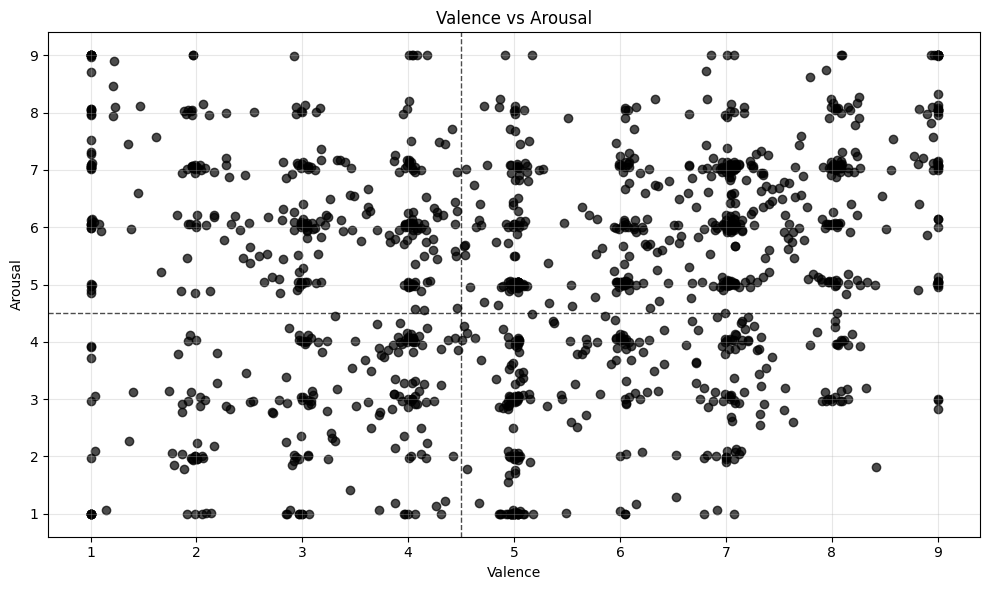

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'participant_ratings.csv'
data = pd.read_csv(file_path, index_col=0)

threshold = 4.5
data['Valence_Category'] = ['V+' if val > threshold else 'V-' for val in data['Valence']]
data['Arousal_Category'] = ['A+' if ar > threshold else 'A-' for ar in data['Arousal']]

data['Category'] = data['Arousal_Category'] + ', ' + data['Valence_Category']

# Plot
plt.figure(figsize=(10, 6))

# Scatter plot with black points
plt.scatter(data['Valence'], data['Arousal'], color='black', alpha=0.7)

plt.title('Valence vs Arousal')
plt.xlabel('Valence')
plt.ylabel('Arousal')

# Add thresholds
plt.axhline(threshold, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.axvline(threshold, color='black', linestyle='--', linewidth=1, alpha=0.7)

plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()


## Fusion au niveau des décisions (Decision Fusion)

#**Feature Exctraction**

In [ ]:
import numpy as np
import pandas as pd
import os
import pickle
from scipy.signal import welch
from scipy.integrate import simps
from tqdm import tqdm

def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = (2 / low) * sf
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = simps(psd[idx_band], dx=freq_res)
    return bp

def get_band_power(data, sf, band):
    bands = {
        "alpha": (8, 12),
        "beta": (12, 30),
        "gamma": (30, 64)
    }
    return bandpower(data, sf, bands[band]) if band in bands else None

base_path = '/content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python'
EEG_ch_names = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1',
                'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8',
                'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']
fs = 128

for channel_name in EEG_ch_names:
    channel_dir = os.path.join(base_path, f'eeg_band_power/{channel_name}')
    os.makedirs(channel_dir, exist_ok=True)

    for participant in tqdm(range(1, 33), desc=f'Processing channel {channel_name}'):
        file_path = os.path.join(base_path, f's{participant:02d}.dat')

        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f, encoding='bytes')[b'data']
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            continue

        participant_data = []
        for trial in range(40):
            eeg_signal = data[trial, EEG_ch_names.index(channel_name), :]

            alpha_power = get_band_power(eeg_signal, fs, "alpha")
            beta_power = get_band_power(eeg_signal, fs, "beta")
            gamma_power = get_band_power(eeg_signal, fs, "gamma")

            combined_features = {
                'trial': trial,
                'alpha_power': alpha_power,
                'beta_power': beta_power,
                'gamma_power': gamma_power
            }
            participant_data.append(combined_features)

        output_df = pd.DataFrame(participant_data)
        save_path = os.path.join(channel_dir, f's{participant:02d}_bandpower.csv')
        output_df.to_csv(save_path, index=False)

        print(f"Band power features for participant s{participant:02d} in channel {channel_name} saved at {save_path}")


Processing channel Fp1:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-9-f3e3fcfa910d>:16: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  bp = simps(psd[idx_band], dx=freq_res)
Processing channel Fp1:   3%|▎         | 1/32 [00:01<00:43,  1.41s/it]

Band power features for participant s01 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s01_bandpower.csv


Processing channel Fp1:   6%|▋         | 2/32 [00:03<00:50,  1.68s/it]

Band power features for participant s02 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s02_bandpower.csv


Processing channel Fp1:   9%|▉         | 3/32 [00:05<00:50,  1.73s/it]

Band power features for participant s03 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s03_bandpower.csv


Processing channel Fp1:  12%|█▎        | 4/32 [00:06<00:46,  1.67s/it]

Band power features for participant s04 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s04_bandpower.csv


Processing channel Fp1:  16%|█▌        | 5/32 [00:07<00:41,  1.53s/it]

Band power features for participant s05 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s05_bandpower.csv


Processing channel Fp1:  19%|█▉        | 6/32 [00:09<00:36,  1.41s/it]

Band power features for participant s06 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s06_bandpower.csv


Processing channel Fp1:  22%|██▏       | 7/32 [00:10<00:33,  1.36s/it]

Band power features for participant s07 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s07_bandpower.csv


Processing channel Fp1:  25%|██▌       | 8/32 [00:11<00:30,  1.28s/it]

Band power features for participant s08 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s08_bandpower.csv


Processing channel Fp1:  28%|██▊       | 9/32 [00:12<00:29,  1.28s/it]

Band power features for participant s09 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s09_bandpower.csv


Processing channel Fp1:  31%|███▏      | 10/32 [00:13<00:26,  1.22s/it]

Band power features for participant s10 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s10_bandpower.csv


Processing channel Fp1:  34%|███▍      | 11/32 [00:15<00:28,  1.35s/it]

Band power features for participant s11 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s11_bandpower.csv


Processing channel Fp1:  38%|███▊      | 12/32 [00:16<00:23,  1.17s/it]

Band power features for participant s12 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s12_bandpower.csv


Processing channel Fp1:  41%|████      | 13/32 [00:17<00:19,  1.05s/it]

Band power features for participant s13 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s13_bandpower.csv


Processing channel Fp1:  44%|████▍     | 14/32 [00:17<00:17,  1.01it/s]

Band power features for participant s14 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s14_bandpower.csv


Processing channel Fp1:  47%|████▋     | 15/32 [00:18<00:16,  1.02it/s]

Band power features for participant s15 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s15_bandpower.csv


Processing channel Fp1:  50%|█████     | 16/32 [00:20<00:19,  1.20s/it]

Band power features for participant s16 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s16_bandpower.csv


Processing channel Fp1:  53%|█████▎    | 17/32 [00:21<00:16,  1.13s/it]

Band power features for participant s17 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s17_bandpower.csv


Processing channel Fp1:  56%|█████▋    | 18/32 [00:22<00:15,  1.07s/it]

Band power features for participant s18 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s18_bandpower.csv


Processing channel Fp1:  59%|█████▉    | 19/32 [00:23<00:13,  1.00s/it]

Band power features for participant s19 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s19_bandpower.csv


Processing channel Fp1:  62%|██████▎   | 20/32 [00:24<00:11,  1.03it/s]

Band power features for participant s20 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s20_bandpower.csv


Processing channel Fp1:  66%|██████▌   | 21/32 [00:25<00:10,  1.06it/s]

Band power features for participant s21 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s21_bandpower.csv


Processing channel Fp1:  69%|██████▉   | 22/32 [00:26<00:09,  1.06it/s]

Band power features for participant s22 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s22_bandpower.csv


Processing channel Fp1:  72%|███████▏  | 23/32 [00:26<00:08,  1.06it/s]

Band power features for participant s23 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s23_bandpower.csv


Processing channel Fp1:  75%|███████▌  | 24/32 [00:27<00:06,  1.17it/s]

Band power features for participant s24 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s24_bandpower.csv


Processing channel Fp1:  78%|███████▊  | 25/32 [00:28<00:05,  1.37it/s]

Band power features for participant s25 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s25_bandpower.csv


Processing channel Fp1:  81%|████████▏ | 26/32 [00:28<00:03,  1.59it/s]

Band power features for participant s26 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s26_bandpower.csv


Processing channel Fp1:  84%|████████▍ | 27/32 [00:28<00:02,  1.77it/s]

Band power features for participant s27 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s27_bandpower.csv


Processing channel Fp1:  88%|████████▊ | 28/32 [00:29<00:02,  1.59it/s]

Band power features for participant s28 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s28_bandpower.csv


Processing channel Fp1:  91%|█████████ | 29/32 [00:30<00:01,  1.67it/s]

Band power features for participant s29 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s29_bandpower.csv


Processing channel Fp1:  94%|█████████▍| 30/32 [00:31<00:01,  1.36it/s]

Band power features for participant s30 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s30_bandpower.csv


Processing channel Fp1:  97%|█████████▋| 31/32 [00:31<00:00,  1.53it/s]

Band power features for participant s31 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s31_bandpower.csv


Processing channel Fp1: 100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


Band power features for participant s32 in channel Fp1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp1/s32_bandpower.csv


Processing channel AF3:   3%|▎         | 1/32 [00:00<00:18,  1.65it/s]

Band power features for participant s01 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s01_bandpower.csv


Processing channel AF3:   6%|▋         | 2/32 [00:01<00:17,  1.67it/s]

Band power features for participant s02 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s02_bandpower.csv


Processing channel AF3:   9%|▉         | 3/32 [00:01<00:17,  1.66it/s]

Band power features for participant s03 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s03_bandpower.csv


Processing channel AF3:  12%|█▎        | 4/32 [00:02<00:16,  1.65it/s]

Band power features for participant s04 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s04_bandpower.csv


Processing channel AF3:  16%|█▌        | 5/32 [00:03<00:16,  1.67it/s]

Band power features for participant s05 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s05_bandpower.csv


Processing channel AF3:  19%|█▉        | 6/32 [00:03<00:15,  1.65it/s]

Band power features for participant s06 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s06_bandpower.csv


Processing channel AF3:  22%|██▏       | 7/32 [00:04<00:15,  1.66it/s]

Band power features for participant s07 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s07_bandpower.csv


Processing channel AF3:  25%|██▌       | 8/32 [00:04<00:12,  1.90it/s]

Band power features for participant s08 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s08_bandpower.csv


Processing channel AF3:  28%|██▊       | 9/32 [00:04<00:11,  2.08it/s]

Band power features for participant s09 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s09_bandpower.csv


Processing channel AF3:  31%|███▏      | 10/32 [00:05<00:09,  2.22it/s]

Band power features for participant s10 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s10_bandpower.csv


Processing channel AF3:  34%|███▍      | 11/32 [00:05<00:09,  2.30it/s]

Band power features for participant s11 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s11_bandpower.csv


Processing channel AF3:  38%|███▊      | 12/32 [00:06<00:08,  2.35it/s]

Band power features for participant s12 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s12_bandpower.csv


Processing channel AF3:  41%|████      | 13/32 [00:06<00:07,  2.41it/s]

Band power features for participant s13 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s13_bandpower.csv


Processing channel AF3:  44%|████▍     | 14/32 [00:06<00:07,  2.48it/s]

Band power features for participant s14 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s14_bandpower.csv


Processing channel AF3:  47%|████▋     | 15/32 [00:07<00:06,  2.51it/s]

Band power features for participant s15 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s15_bandpower.csv


Processing channel AF3:  50%|█████     | 16/32 [00:07<00:06,  2.52it/s]

Band power features for participant s16 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s16_bandpower.csv


Processing channel AF3:  53%|█████▎    | 17/32 [00:08<00:05,  2.55it/s]

Band power features for participant s17 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s17_bandpower.csv


Processing channel AF3:  56%|█████▋    | 18/32 [00:08<00:05,  2.53it/s]

Band power features for participant s18 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s18_bandpower.csv


Processing channel AF3:  59%|█████▉    | 19/32 [00:08<00:05,  2.54it/s]

Band power features for participant s19 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s19_bandpower.csv


Processing channel AF3:  62%|██████▎   | 20/32 [00:09<00:04,  2.57it/s]

Band power features for participant s20 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s20_bandpower.csv


Processing channel AF3:  66%|██████▌   | 21/32 [00:09<00:04,  2.63it/s]

Band power features for participant s21 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s21_bandpower.csv


Processing channel AF3:  69%|██████▉   | 22/32 [00:09<00:03,  2.68it/s]

Band power features for participant s22 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s22_bandpower.csv


Processing channel AF3:  72%|███████▏  | 23/32 [00:10<00:03,  2.62it/s]

Band power features for participant s23 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s23_bandpower.csv


Processing channel AF3:  75%|███████▌  | 24/32 [00:10<00:03,  2.62it/s]

Band power features for participant s24 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s24_bandpower.csv


Processing channel AF3:  78%|███████▊  | 25/32 [00:11<00:02,  2.63it/s]

Band power features for participant s25 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s25_bandpower.csv


Processing channel AF3:  81%|████████▏ | 26/32 [00:11<00:02,  2.65it/s]

Band power features for participant s26 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s26_bandpower.csv


Processing channel AF3:  84%|████████▍ | 27/32 [00:11<00:01,  2.64it/s]

Band power features for participant s27 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s27_bandpower.csv


Processing channel AF3:  88%|████████▊ | 28/32 [00:12<00:01,  2.62it/s]

Band power features for participant s28 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s28_bandpower.csv


Processing channel AF3:  91%|█████████ | 29/32 [00:12<00:01,  2.60it/s]

Band power features for participant s29 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s29_bandpower.csv


Processing channel AF3:  94%|█████████▍| 30/32 [00:13<00:00,  2.64it/s]

Band power features for participant s30 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s30_bandpower.csv


Processing channel AF3:  97%|█████████▋| 31/32 [00:13<00:00,  2.60it/s]

Band power features for participant s31 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s31_bandpower.csv


Processing channel AF3: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


Band power features for participant s32 in channel AF3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF3/s32_bandpower.csv


Processing channel F3:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

Band power features for participant s01 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s01_bandpower.csv


Processing channel F3:   6%|▋         | 2/32 [00:01<00:15,  1.95it/s]

Band power features for participant s02 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s02_bandpower.csv


Processing channel F3:   9%|▉         | 3/32 [00:01<00:15,  1.84it/s]

Band power features for participant s03 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s03_bandpower.csv


Processing channel F3:  12%|█▎        | 4/32 [00:02<00:15,  1.84it/s]

Band power features for participant s04 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s04_bandpower.csv


Processing channel F3:  16%|█▌        | 5/32 [00:02<00:15,  1.78it/s]

Band power features for participant s05 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s05_bandpower.csv


Processing channel F3:  19%|█▉        | 6/32 [00:03<00:14,  1.79it/s]

Band power features for participant s06 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s06_bandpower.csv


Processing channel F3:  22%|██▏       | 7/32 [00:03<00:14,  1.73it/s]

Band power features for participant s07 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s07_bandpower.csv


Processing channel F3:  25%|██▌       | 8/32 [00:04<00:13,  1.74it/s]

Band power features for participant s08 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s08_bandpower.csv


Processing channel F3:  28%|██▊       | 9/32 [00:05<00:13,  1.72it/s]

Band power features for participant s09 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s09_bandpower.csv


Processing channel F3:  31%|███▏      | 10/32 [00:05<00:11,  1.93it/s]

Band power features for participant s10 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s10_bandpower.csv


Processing channel F3:  34%|███▍      | 11/32 [00:05<00:10,  2.09it/s]

Band power features for participant s11 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s11_bandpower.csv


Processing channel F3:  38%|███▊      | 12/32 [00:06<00:08,  2.26it/s]

Band power features for participant s12 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s12_bandpower.csv


Processing channel F3:  41%|████      | 13/32 [00:06<00:07,  2.41it/s]

Band power features for participant s13 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s13_bandpower.csv


Processing channel F3:  44%|████▍     | 14/32 [00:06<00:07,  2.45it/s]

Band power features for participant s14 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s14_bandpower.csv


Processing channel F3:  47%|████▋     | 15/32 [00:07<00:06,  2.54it/s]

Band power features for participant s15 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s15_bandpower.csv


Processing channel F3:  50%|█████     | 16/32 [00:07<00:06,  2.61it/s]

Band power features for participant s16 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s16_bandpower.csv


Processing channel F3:  53%|█████▎    | 17/32 [00:08<00:05,  2.62it/s]

Band power features for participant s17 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s17_bandpower.csv


Processing channel F3:  56%|█████▋    | 18/32 [00:08<00:05,  2.64it/s]

Band power features for participant s18 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s18_bandpower.csv


Processing channel F3:  59%|█████▉    | 19/32 [00:08<00:04,  2.69it/s]

Band power features for participant s19 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s19_bandpower.csv


Processing channel F3:  62%|██████▎   | 20/32 [00:09<00:04,  2.68it/s]

Band power features for participant s20 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s20_bandpower.csv


Processing channel F3:  66%|██████▌   | 21/32 [00:09<00:04,  2.64it/s]

Band power features for participant s21 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s21_bandpower.csv


Processing channel F3:  69%|██████▉   | 22/32 [00:09<00:03,  2.63it/s]

Band power features for participant s22 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s22_bandpower.csv


Processing channel F3:  72%|███████▏  | 23/32 [00:10<00:03,  2.58it/s]

Band power features for participant s23 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s23_bandpower.csv


Processing channel F3:  75%|███████▌  | 24/32 [00:10<00:03,  2.60it/s]

Band power features for participant s24 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s24_bandpower.csv


Processing channel F3:  78%|███████▊  | 25/32 [00:11<00:02,  2.56it/s]

Band power features for participant s25 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s25_bandpower.csv


Processing channel F3:  81%|████████▏ | 26/32 [00:11<00:02,  2.60it/s]

Band power features for participant s26 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s26_bandpower.csv


Processing channel F3:  84%|████████▍ | 27/32 [00:11<00:01,  2.58it/s]

Band power features for participant s27 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s27_bandpower.csv


Processing channel F3:  88%|████████▊ | 28/32 [00:12<00:01,  2.63it/s]

Band power features for participant s28 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s28_bandpower.csv


Processing channel F3:  91%|█████████ | 29/32 [00:12<00:01,  2.62it/s]

Band power features for participant s29 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s29_bandpower.csv


Processing channel F3:  94%|█████████▍| 30/32 [00:12<00:00,  2.62it/s]

Band power features for participant s30 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s30_bandpower.csv


Processing channel F3:  97%|█████████▋| 31/32 [00:13<00:00,  2.67it/s]

Band power features for participant s31 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s31_bandpower.csv


Processing channel F3: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]


Band power features for participant s32 in channel F3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F3/s32_bandpower.csv


Processing channel F7:   3%|▎         | 1/32 [00:00<00:11,  2.62it/s]

Band power features for participant s01 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s01_bandpower.csv


Processing channel F7:   6%|▋         | 2/32 [00:00<00:11,  2.59it/s]

Band power features for participant s02 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s02_bandpower.csv


Processing channel F7:   9%|▉         | 3/32 [00:01<00:11,  2.60it/s]

Band power features for participant s03 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s03_bandpower.csv


Processing channel F7:  12%|█▎        | 4/32 [00:01<00:13,  2.11it/s]

Band power features for participant s04 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s04_bandpower.csv


Processing channel F7:  16%|█▌        | 5/32 [00:02<00:13,  1.93it/s]

Band power features for participant s05 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s05_bandpower.csv


Processing channel F7:  19%|█▉        | 6/32 [00:02<00:13,  1.88it/s]

Band power features for participant s06 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s06_bandpower.csv


Processing channel F7:  22%|██▏       | 7/32 [00:03<00:14,  1.76it/s]

Band power features for participant s07 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s07_bandpower.csv


Processing channel F7:  25%|██▌       | 8/32 [00:04<00:13,  1.74it/s]

Band power features for participant s08 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s08_bandpower.csv


Processing channel F7:  28%|██▊       | 9/32 [00:04<00:13,  1.70it/s]

Band power features for participant s09 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s09_bandpower.csv


Processing channel F7:  31%|███▏      | 10/32 [00:05<00:12,  1.71it/s]

Band power features for participant s10 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s10_bandpower.csv


Processing channel F7:  34%|███▍      | 11/32 [00:05<00:12,  1.72it/s]

Band power features for participant s11 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s11_bandpower.csv


Processing channel F7:  38%|███▊      | 12/32 [00:06<00:10,  1.94it/s]

Band power features for participant s12 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s12_bandpower.csv


Processing channel F7:  41%|████      | 13/32 [00:06<00:09,  2.11it/s]

Band power features for participant s13 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s13_bandpower.csv


Processing channel F7:  44%|████▍     | 14/32 [00:07<00:07,  2.27it/s]

Band power features for participant s14 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s14_bandpower.csv


Processing channel F7:  47%|████▋     | 15/32 [00:07<00:07,  2.39it/s]

Band power features for participant s15 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s15_bandpower.csv


Processing channel F7:  50%|█████     | 16/32 [00:07<00:06,  2.44it/s]

Band power features for participant s16 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s16_bandpower.csv


Processing channel F7:  53%|█████▎    | 17/32 [00:08<00:05,  2.53it/s]

Band power features for participant s17 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s17_bandpower.csv


Processing channel F7:  56%|█████▋    | 18/32 [00:08<00:05,  2.60it/s]

Band power features for participant s18 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s18_bandpower.csv


Processing channel F7:  59%|█████▉    | 19/32 [00:08<00:04,  2.60it/s]

Band power features for participant s19 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s19_bandpower.csv


Processing channel F7:  62%|██████▎   | 20/32 [00:09<00:04,  2.65it/s]

Band power features for participant s20 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s20_bandpower.csv


Processing channel F7:  66%|██████▌   | 21/32 [00:09<00:04,  2.65it/s]

Band power features for participant s21 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s21_bandpower.csv


Processing channel F7:  69%|██████▉   | 22/32 [00:09<00:03,  2.68it/s]

Band power features for participant s22 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s22_bandpower.csv


Processing channel F7:  72%|███████▏  | 23/32 [00:10<00:03,  2.65it/s]

Band power features for participant s23 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s23_bandpower.csv


Processing channel F7:  75%|███████▌  | 24/32 [00:10<00:03,  2.64it/s]

Band power features for participant s24 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s24_bandpower.csv


Processing channel F7:  78%|███████▊  | 25/32 [00:11<00:02,  2.62it/s]

Band power features for participant s25 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s25_bandpower.csv


Processing channel F7:  81%|████████▏ | 26/32 [00:11<00:02,  2.51it/s]

Band power features for participant s26 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s26_bandpower.csv


Processing channel F7:  84%|████████▍ | 27/32 [00:12<00:02,  2.43it/s]

Band power features for participant s27 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s27_bandpower.csv


Processing channel F7:  88%|████████▊ | 28/32 [00:12<00:01,  2.47it/s]

Band power features for participant s28 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s28_bandpower.csv


Processing channel F7:  91%|█████████ | 29/32 [00:12<00:01,  2.49it/s]

Band power features for participant s29 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s29_bandpower.csv


Processing channel F7:  94%|█████████▍| 30/32 [00:13<00:00,  2.54it/s]

Band power features for participant s30 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s30_bandpower.csv


Processing channel F7:  97%|█████████▋| 31/32 [00:13<00:00,  2.59it/s]

Band power features for participant s31 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s31_bandpower.csv


Processing channel F7: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]


Band power features for participant s32 in channel F7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F7/s32_bandpower.csv


Processing channel FC5:   3%|▎         | 1/32 [00:00<00:11,  2.66it/s]

Band power features for participant s01 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s01_bandpower.csv


Processing channel FC5:   6%|▋         | 2/32 [00:00<00:11,  2.62it/s]

Band power features for participant s02 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s02_bandpower.csv


Processing channel FC5:   9%|▉         | 3/32 [00:01<00:11,  2.49it/s]

Band power features for participant s03 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s03_bandpower.csv


Processing channel FC5:  12%|█▎        | 4/32 [00:01<00:10,  2.56it/s]

Band power features for participant s04 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s04_bandpower.csv


Processing channel FC5:  16%|█▌        | 5/32 [00:02<00:11,  2.44it/s]

Band power features for participant s05 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s05_bandpower.csv


Processing channel FC5:  19%|█▉        | 6/32 [00:02<00:11,  2.17it/s]

Band power features for participant s06 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s06_bandpower.csv


Processing channel FC5:  22%|██▏       | 7/32 [00:03<00:12,  1.93it/s]

Band power features for participant s07 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s07_bandpower.csv


Processing channel FC5:  25%|██▌       | 8/32 [00:03<00:12,  1.85it/s]

Band power features for participant s08 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s08_bandpower.csv


Processing channel FC5:  28%|██▊       | 9/32 [00:04<00:12,  1.84it/s]

Band power features for participant s09 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s09_bandpower.csv


Processing channel FC5:  31%|███▏      | 10/32 [00:04<00:12,  1.74it/s]

Band power features for participant s10 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s10_bandpower.csv


Processing channel FC5:  34%|███▍      | 11/32 [00:05<00:12,  1.70it/s]

Band power features for participant s11 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s11_bandpower.csv


Processing channel FC5:  38%|███▊      | 12/32 [00:06<00:12,  1.65it/s]

Band power features for participant s12 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s12_bandpower.csv


Processing channel FC5:  41%|████      | 13/32 [00:06<00:10,  1.76it/s]

Band power features for participant s13 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s13_bandpower.csv


Processing channel FC5:  44%|████▍     | 14/32 [00:07<00:09,  1.95it/s]

Band power features for participant s14 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s14_bandpower.csv


Processing channel FC5:  47%|████▋     | 15/32 [00:07<00:08,  2.11it/s]

Band power features for participant s15 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s15_bandpower.csv


Processing channel FC5:  50%|█████     | 16/32 [00:07<00:07,  2.27it/s]

Band power features for participant s16 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s16_bandpower.csv


Processing channel FC5:  53%|█████▎    | 17/32 [00:08<00:06,  2.34it/s]

Band power features for participant s17 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s17_bandpower.csv


Processing channel FC5:  56%|█████▋    | 18/32 [00:08<00:05,  2.47it/s]

Band power features for participant s18 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s18_bandpower.csv


Processing channel FC5:  59%|█████▉    | 19/32 [00:08<00:05,  2.52it/s]

Band power features for participant s19 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s19_bandpower.csv


Processing channel FC5:  62%|██████▎   | 20/32 [00:09<00:04,  2.57it/s]

Band power features for participant s20 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s20_bandpower.csv


Processing channel FC5:  66%|██████▌   | 21/32 [00:09<00:04,  2.65it/s]

Band power features for participant s21 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s21_bandpower.csv


Processing channel FC5:  69%|██████▉   | 22/32 [00:10<00:03,  2.65it/s]

Band power features for participant s22 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s22_bandpower.csv


Processing channel FC5:  72%|███████▏  | 23/32 [00:10<00:03,  2.64it/s]

Band power features for participant s23 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s23_bandpower.csv


Processing channel FC5:  75%|███████▌  | 24/32 [00:10<00:03,  2.66it/s]

Band power features for participant s24 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s24_bandpower.csv


Processing channel FC5:  78%|███████▊  | 25/32 [00:11<00:02,  2.68it/s]

Band power features for participant s25 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s25_bandpower.csv


Processing channel FC5:  81%|████████▏ | 26/32 [00:11<00:02,  2.64it/s]

Band power features for participant s26 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s26_bandpower.csv


Processing channel FC5:  84%|████████▍ | 27/32 [00:11<00:01,  2.60it/s]

Band power features for participant s27 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s27_bandpower.csv


Processing channel FC5:  88%|████████▊ | 28/32 [00:12<00:01,  2.62it/s]

Band power features for participant s28 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s28_bandpower.csv


Processing channel FC5:  91%|█████████ | 29/32 [00:12<00:01,  2.64it/s]

Band power features for participant s29 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s29_bandpower.csv


Processing channel FC5:  94%|█████████▍| 30/32 [00:13<00:00,  2.61it/s]

Band power features for participant s30 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s30_bandpower.csv


Processing channel FC5:  97%|█████████▋| 31/32 [00:13<00:00,  2.62it/s]

Band power features for participant s31 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s31_bandpower.csv


Processing channel FC5: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


Band power features for participant s32 in channel FC5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC5/s32_bandpower.csv


Processing channel FC1:   3%|▎         | 1/32 [00:00<00:11,  2.77it/s]

Band power features for participant s01 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s01_bandpower.csv


Processing channel FC1:   6%|▋         | 2/32 [00:00<00:11,  2.71it/s]

Band power features for participant s02 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s02_bandpower.csv


Processing channel FC1:   9%|▉         | 3/32 [00:01<00:11,  2.64it/s]

Band power features for participant s03 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s03_bandpower.csv


Processing channel FC1:  12%|█▎        | 4/32 [00:01<00:10,  2.67it/s]

Band power features for participant s04 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s04_bandpower.csv


Processing channel FC1:  16%|█▌        | 5/32 [00:01<00:10,  2.66it/s]

Band power features for participant s05 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s05_bandpower.csv


Processing channel FC1:  19%|█▉        | 6/32 [00:02<00:09,  2.65it/s]

Band power features for participant s06 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s06_bandpower.csv


Processing channel FC1:  22%|██▏       | 7/32 [00:02<00:09,  2.54it/s]

Band power features for participant s07 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s07_bandpower.csv


Processing channel FC1:  25%|██▌       | 8/32 [00:03<00:11,  2.18it/s]

Band power features for participant s08 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s08_bandpower.csv


Processing channel FC1:  28%|██▊       | 9/32 [00:03<00:11,  2.02it/s]

Band power features for participant s09 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s09_bandpower.csv


Processing channel FC1:  31%|███▏      | 10/32 [00:04<00:11,  1.88it/s]

Band power features for participant s10 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s10_bandpower.csv


Processing channel FC1:  34%|███▍      | 11/32 [00:05<00:11,  1.76it/s]

Band power features for participant s11 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s11_bandpower.csv


Processing channel FC1:  38%|███▊      | 12/32 [00:05<00:11,  1.73it/s]

Band power features for participant s12 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s12_bandpower.csv


Processing channel FC1:  41%|████      | 13/32 [00:06<00:11,  1.70it/s]

Band power features for participant s13 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s13_bandpower.csv


Processing channel FC1:  44%|████▍     | 14/32 [00:06<00:10,  1.67it/s]

Band power features for participant s14 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s14_bandpower.csv


Processing channel FC1:  47%|████▋     | 15/32 [00:07<00:09,  1.74it/s]

Band power features for participant s15 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s15_bandpower.csv


Processing channel FC1:  50%|█████     | 16/32 [00:07<00:08,  1.97it/s]

Band power features for participant s16 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s16_bandpower.csv


Processing channel FC1:  53%|█████▎    | 17/32 [00:08<00:07,  2.11it/s]

Band power features for participant s17 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s17_bandpower.csv


Processing channel FC1:  56%|█████▋    | 18/32 [00:08<00:06,  2.28it/s]

Band power features for participant s18 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s18_bandpower.csv


Processing channel FC1:  59%|█████▉    | 19/32 [00:08<00:05,  2.38it/s]

Band power features for participant s19 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s19_bandpower.csv


Processing channel FC1:  62%|██████▎   | 20/32 [00:09<00:04,  2.44it/s]

Band power features for participant s20 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s20_bandpower.csv


Processing channel FC1:  66%|██████▌   | 21/32 [00:09<00:04,  2.54it/s]

Band power features for participant s21 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s21_bandpower.csv


Processing channel FC1:  69%|██████▉   | 22/32 [00:10<00:03,  2.56it/s]

Band power features for participant s22 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s22_bandpower.csv


Processing channel FC1:  72%|███████▏  | 23/32 [00:10<00:03,  2.62it/s]

Band power features for participant s23 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s23_bandpower.csv


Processing channel FC1:  75%|███████▌  | 24/32 [00:10<00:03,  2.63it/s]

Band power features for participant s24 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s24_bandpower.csv


Processing channel FC1:  78%|███████▊  | 25/32 [00:11<00:02,  2.59it/s]

Band power features for participant s25 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s25_bandpower.csv


Processing channel FC1:  81%|████████▏ | 26/32 [00:11<00:02,  2.60it/s]

Band power features for participant s26 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s26_bandpower.csv


Processing channel FC1:  84%|████████▍ | 27/32 [00:11<00:01,  2.59it/s]

Band power features for participant s27 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s27_bandpower.csv


Processing channel FC1:  88%|████████▊ | 28/32 [00:12<00:01,  2.60it/s]

Band power features for participant s28 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s28_bandpower.csv


Processing channel FC1:  91%|█████████ | 29/32 [00:12<00:01,  2.59it/s]

Band power features for participant s29 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s29_bandpower.csv


Processing channel FC1:  94%|█████████▍| 30/32 [00:13<00:00,  2.55it/s]

Band power features for participant s30 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s30_bandpower.csv


Processing channel FC1:  97%|█████████▋| 31/32 [00:13<00:00,  2.57it/s]

Band power features for participant s31 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s31_bandpower.csv


Processing channel FC1: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]


Band power features for participant s32 in channel FC1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC1/s32_bandpower.csv


Processing channel C3:   3%|▎         | 1/32 [00:00<00:12,  2.42it/s]

Band power features for participant s01 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s01_bandpower.csv


Processing channel C3:   6%|▋         | 2/32 [00:00<00:11,  2.59it/s]

Band power features for participant s02 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s02_bandpower.csv


Processing channel C3:   9%|▉         | 3/32 [00:01<00:11,  2.57it/s]

Band power features for participant s03 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s03_bandpower.csv


Processing channel C3:  12%|█▎        | 4/32 [00:01<00:10,  2.59it/s]

Band power features for participant s04 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s04_bandpower.csv


Processing channel C3:  16%|█▌        | 5/32 [00:01<00:10,  2.63it/s]

Band power features for participant s05 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s05_bandpower.csv


Processing channel C3:  19%|█▉        | 6/32 [00:02<00:09,  2.63it/s]

Band power features for participant s06 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s06_bandpower.csv


Processing channel C3:  22%|██▏       | 7/32 [00:02<00:09,  2.62it/s]

Band power features for participant s07 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s07_bandpower.csv


Processing channel C3:  25%|██▌       | 8/32 [00:03<00:09,  2.59it/s]

Band power features for participant s08 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s08_bandpower.csv


Processing channel C3:  28%|██▊       | 9/32 [00:03<00:09,  2.46it/s]

Band power features for participant s09 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s09_bandpower.csv


Processing channel C3:  31%|███▏      | 10/32 [00:04<00:10,  2.20it/s]

Band power features for participant s10 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s10_bandpower.csv


Processing channel C3:  34%|███▍      | 11/32 [00:04<00:10,  2.03it/s]

Band power features for participant s11 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s11_bandpower.csv


Processing channel C3:  38%|███▊      | 12/32 [00:05<00:10,  1.94it/s]

Band power features for participant s12 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s12_bandpower.csv


Processing channel C3:  41%|████      | 13/32 [00:05<00:10,  1.82it/s]

Band power features for participant s13 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s13_bandpower.csv


Processing channel C3:  44%|████▍     | 14/32 [00:06<00:10,  1.77it/s]

Band power features for participant s14 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s14_bandpower.csv


Processing channel C3:  47%|████▋     | 15/32 [00:07<00:09,  1.72it/s]

Band power features for participant s15 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s15_bandpower.csv


Processing channel C3:  50%|█████     | 16/32 [00:07<00:09,  1.70it/s]

Band power features for participant s16 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s16_bandpower.csv


Processing channel C3:  53%|█████▎    | 17/32 [00:08<00:08,  1.78it/s]

Band power features for participant s17 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s17_bandpower.csv


Processing channel C3:  56%|█████▋    | 18/32 [00:08<00:06,  2.00it/s]

Band power features for participant s18 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s18_bandpower.csv


Processing channel C3:  59%|█████▉    | 19/32 [00:08<00:06,  2.14it/s]

Band power features for participant s19 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s19_bandpower.csv


Processing channel C3:  62%|██████▎   | 20/32 [00:09<00:05,  2.29it/s]

Band power features for participant s20 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s20_bandpower.csv


Processing channel C3:  66%|██████▌   | 21/32 [00:09<00:04,  2.38it/s]

Band power features for participant s21 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s21_bandpower.csv


Processing channel C3:  69%|██████▉   | 22/32 [00:10<00:04,  2.44it/s]

Band power features for participant s22 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s22_bandpower.csv


Processing channel C3:  72%|███████▏  | 23/32 [00:10<00:03,  2.50it/s]

Band power features for participant s23 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s23_bandpower.csv


Processing channel C3:  75%|███████▌  | 24/32 [00:10<00:03,  2.29it/s]

Band power features for participant s24 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s24_bandpower.csv


Processing channel C3:  78%|███████▊  | 25/32 [00:11<00:02,  2.39it/s]

Band power features for participant s25 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s25_bandpower.csv


Processing channel C3:  81%|████████▏ | 26/32 [00:11<00:02,  2.45it/s]

Band power features for participant s26 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s26_bandpower.csv


Processing channel C3:  84%|████████▍ | 27/32 [00:12<00:02,  2.48it/s]

Band power features for participant s27 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s27_bandpower.csv


Processing channel C3:  88%|████████▊ | 28/32 [00:12<00:01,  2.55it/s]

Band power features for participant s28 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s28_bandpower.csv


Processing channel C3:  91%|█████████ | 29/32 [00:12<00:01,  2.56it/s]

Band power features for participant s29 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s29_bandpower.csv


Processing channel C3:  94%|█████████▍| 30/32 [00:13<00:00,  2.53it/s]

Band power features for participant s30 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s30_bandpower.csv


Processing channel C3:  97%|█████████▋| 31/32 [00:13<00:00,  2.50it/s]

Band power features for participant s31 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s31_bandpower.csv


Processing channel C3: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


Band power features for participant s32 in channel C3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C3/s32_bandpower.csv


Processing channel T7:   3%|▎         | 1/32 [00:00<00:11,  2.59it/s]

Band power features for participant s01 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s01_bandpower.csv


Processing channel T7:   6%|▋         | 2/32 [00:00<00:11,  2.57it/s]

Band power features for participant s02 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s02_bandpower.csv


Processing channel T7:   9%|▉         | 3/32 [00:01<00:11,  2.58it/s]

Band power features for participant s03 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s03_bandpower.csv


Processing channel T7:  12%|█▎        | 4/32 [00:01<00:10,  2.61it/s]

Band power features for participant s04 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s04_bandpower.csv


Processing channel T7:  16%|█▌        | 5/32 [00:01<00:10,  2.51it/s]

Band power features for participant s05 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s05_bandpower.csv


Processing channel T7:  19%|█▉        | 6/32 [00:02<00:10,  2.56it/s]

Band power features for participant s06 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s06_bandpower.csv


Processing channel T7:  22%|██▏       | 7/32 [00:02<00:09,  2.53it/s]

Band power features for participant s07 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s07_bandpower.csv


Processing channel T7:  25%|██▌       | 8/32 [00:03<00:09,  2.54it/s]

Band power features for participant s08 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s08_bandpower.csv


Processing channel T7:  28%|██▊       | 9/32 [00:03<00:08,  2.60it/s]

Band power features for participant s09 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s09_bandpower.csv


Processing channel T7:  31%|███▏      | 10/32 [00:03<00:08,  2.53it/s]

Band power features for participant s10 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s10_bandpower.csv


Processing channel T7:  34%|███▍      | 11/32 [00:04<00:09,  2.21it/s]

Band power features for participant s11 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s11_bandpower.csv


Processing channel T7:  38%|███▊      | 12/32 [00:06<00:17,  1.14it/s]

Band power features for participant s12 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s12_bandpower.csv


Processing channel T7:  41%|████      | 13/32 [00:06<00:15,  1.26it/s]

Band power features for participant s13 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s13_bandpower.csv


Processing channel T7:  44%|████▍     | 14/32 [00:07<00:13,  1.35it/s]

Band power features for participant s14 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s14_bandpower.csv


Processing channel T7:  47%|████▋     | 15/32 [00:08<00:12,  1.41it/s]

Band power features for participant s15 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s15_bandpower.csv


Processing channel T7:  50%|█████     | 16/32 [00:08<00:10,  1.57it/s]

Band power features for participant s16 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s16_bandpower.csv


Processing channel T7:  53%|█████▎    | 17/32 [00:09<00:08,  1.75it/s]

Band power features for participant s17 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s17_bandpower.csv


Processing channel T7:  56%|█████▋    | 18/32 [00:09<00:07,  1.96it/s]

Band power features for participant s18 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s18_bandpower.csv


Processing channel T7:  59%|█████▉    | 19/32 [00:09<00:06,  2.12it/s]

Band power features for participant s19 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s19_bandpower.csv


Processing channel T7:  62%|██████▎   | 20/32 [00:10<00:05,  2.25it/s]

Band power features for participant s20 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s20_bandpower.csv


Processing channel T7:  66%|██████▌   | 21/32 [00:10<00:04,  2.40it/s]

Band power features for participant s21 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s21_bandpower.csv


Processing channel T7:  69%|██████▉   | 22/32 [00:10<00:04,  2.45it/s]

Band power features for participant s22 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s22_bandpower.csv


Processing channel T7:  72%|███████▏  | 23/32 [00:11<00:03,  2.48it/s]

Band power features for participant s23 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s23_bandpower.csv


Processing channel T7:  75%|███████▌  | 24/32 [00:11<00:03,  2.55it/s]

Band power features for participant s24 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s24_bandpower.csv


Processing channel T7:  78%|███████▊  | 25/32 [00:12<00:02,  2.50it/s]

Band power features for participant s25 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s25_bandpower.csv


Processing channel T7:  81%|████████▏ | 26/32 [00:12<00:02,  2.55it/s]

Band power features for participant s26 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s26_bandpower.csv


Processing channel T7:  84%|████████▍ | 27/32 [00:12<00:01,  2.56it/s]

Band power features for participant s27 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s27_bandpower.csv


Processing channel T7:  88%|████████▊ | 28/32 [00:13<00:01,  2.57it/s]

Band power features for participant s28 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s28_bandpower.csv


Processing channel T7:  91%|█████████ | 29/32 [00:13<00:01,  2.60it/s]

Band power features for participant s29 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s29_bandpower.csv


Processing channel T7:  94%|█████████▍| 30/32 [00:14<00:00,  2.61it/s]

Band power features for participant s30 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s30_bandpower.csv


Processing channel T7:  97%|█████████▋| 31/32 [00:14<00:00,  2.58it/s]

Band power features for participant s31 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s31_bandpower.csv


Processing channel T7: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


Band power features for participant s32 in channel T7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T7/s32_bandpower.csv


Processing channel CP5:   3%|▎         | 1/32 [00:00<00:12,  2.43it/s]

Band power features for participant s01 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s01_bandpower.csv


Processing channel CP5:   6%|▋         | 2/32 [00:00<00:11,  2.57it/s]

Band power features for participant s02 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s02_bandpower.csv


Processing channel CP5:   9%|▉         | 3/32 [00:01<00:11,  2.56it/s]

Band power features for participant s03 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s03_bandpower.csv


Processing channel CP5:  12%|█▎        | 4/32 [00:01<00:10,  2.59it/s]

Band power features for participant s04 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s04_bandpower.csv


Processing channel CP5:  16%|█▌        | 5/32 [00:01<00:10,  2.60it/s]

Band power features for participant s05 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s05_bandpower.csv


Processing channel CP5:  19%|█▉        | 6/32 [00:02<00:10,  2.55it/s]

Band power features for participant s06 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s06_bandpower.csv


Processing channel CP5:  22%|██▏       | 7/32 [00:02<00:09,  2.53it/s]

Band power features for participant s07 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s07_bandpower.csv


Processing channel CP5:  25%|██▌       | 8/32 [00:03<00:09,  2.48it/s]

Band power features for participant s08 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s08_bandpower.csv


Processing channel CP5:  28%|██▊       | 9/32 [00:03<00:09,  2.51it/s]

Band power features for participant s09 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s09_bandpower.csv


Processing channel CP5:  31%|███▏      | 10/32 [00:04<00:09,  2.22it/s]

Band power features for participant s10 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s10_bandpower.csv


Processing channel CP5:  34%|███▍      | 11/32 [00:04<00:10,  2.00it/s]

Band power features for participant s11 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s11_bandpower.csv


Processing channel CP5:  38%|███▊      | 12/32 [00:05<00:10,  1.89it/s]

Band power features for participant s12 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s12_bandpower.csv


Processing channel CP5:  41%|████      | 13/32 [00:05<00:10,  1.81it/s]

Band power features for participant s13 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s13_bandpower.csv


Processing channel CP5:  44%|████▍     | 14/32 [00:06<00:10,  1.77it/s]

Band power features for participant s14 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s14_bandpower.csv


Processing channel CP5:  47%|████▋     | 15/32 [00:07<00:10,  1.68it/s]

Band power features for participant s15 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s15_bandpower.csv


Processing channel CP5:  50%|█████     | 16/32 [00:07<00:09,  1.66it/s]

Band power features for participant s16 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s16_bandpower.csv


Processing channel CP5:  53%|█████▎    | 17/32 [00:08<00:08,  1.71it/s]

Band power features for participant s17 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s17_bandpower.csv


Processing channel CP5:  56%|█████▋    | 18/32 [00:08<00:07,  1.91it/s]

Band power features for participant s18 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s18_bandpower.csv


Processing channel CP5:  59%|█████▉    | 19/32 [00:09<00:06,  2.06it/s]

Band power features for participant s19 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s19_bandpower.csv


Processing channel CP5:  62%|██████▎   | 20/32 [00:09<00:05,  2.22it/s]

Band power features for participant s20 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s20_bandpower.csv


Processing channel CP5:  66%|██████▌   | 21/32 [00:09<00:04,  2.33it/s]

Band power features for participant s21 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s21_bandpower.csv


Processing channel CP5:  69%|██████▉   | 22/32 [00:10<00:04,  2.40it/s]

Band power features for participant s22 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s22_bandpower.csv


Processing channel CP5:  72%|███████▏  | 23/32 [00:10<00:03,  2.49it/s]

Band power features for participant s23 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s23_bandpower.csv


Processing channel CP5:  75%|███████▌  | 24/32 [00:11<00:03,  2.51it/s]

Band power features for participant s24 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s24_bandpower.csv


Processing channel CP5:  78%|███████▊  | 25/32 [00:11<00:02,  2.53it/s]

Band power features for participant s25 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s25_bandpower.csv


Processing channel CP5:  81%|████████▏ | 26/32 [00:11<00:02,  2.56it/s]

Band power features for participant s26 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s26_bandpower.csv


Processing channel CP5:  84%|████████▍ | 27/32 [00:12<00:01,  2.53it/s]

Band power features for participant s27 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s27_bandpower.csv


Processing channel CP5:  88%|████████▊ | 28/32 [00:12<00:01,  2.54it/s]

Band power features for participant s28 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s28_bandpower.csv


Processing channel CP5:  91%|█████████ | 29/32 [00:12<00:01,  2.57it/s]

Band power features for participant s29 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s29_bandpower.csv


Processing channel CP5:  94%|█████████▍| 30/32 [00:13<00:00,  2.59it/s]

Band power features for participant s30 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s30_bandpower.csv


Processing channel CP5:  97%|█████████▋| 31/32 [00:13<00:00,  2.60it/s]

Band power features for participant s31 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s31_bandpower.csv


Processing channel CP5: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


Band power features for participant s32 in channel CP5 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP5/s32_bandpower.csv


Processing channel CP1:   3%|▎         | 1/32 [00:00<00:11,  2.62it/s]

Band power features for participant s01 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s01_bandpower.csv


Processing channel CP1:   6%|▋         | 2/32 [00:00<00:11,  2.60it/s]

Band power features for participant s02 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s02_bandpower.csv


Processing channel CP1:   9%|▉         | 3/32 [00:01<00:11,  2.52it/s]

Band power features for participant s03 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s03_bandpower.csv


Processing channel CP1:  12%|█▎        | 4/32 [00:01<00:10,  2.61it/s]

Band power features for participant s04 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s04_bandpower.csv


Processing channel CP1:  16%|█▌        | 5/32 [00:01<00:10,  2.53it/s]

Band power features for participant s05 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s05_bandpower.csv


Processing channel CP1:  19%|█▉        | 6/32 [00:02<00:10,  2.56it/s]

Band power features for participant s06 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s06_bandpower.csv


Processing channel CP1:  22%|██▏       | 7/32 [00:02<00:09,  2.59it/s]

Band power features for participant s07 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s07_bandpower.csv


Processing channel CP1:  25%|██▌       | 8/32 [00:03<00:09,  2.56it/s]

Band power features for participant s08 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s08_bandpower.csv


Processing channel CP1:  28%|██▊       | 9/32 [00:03<00:08,  2.57it/s]

Band power features for participant s09 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s09_bandpower.csv


Processing channel CP1:  31%|███▏      | 10/32 [00:03<00:08,  2.63it/s]

Band power features for participant s10 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s10_bandpower.csv


Processing channel CP1:  34%|███▍      | 11/32 [00:04<00:08,  2.42it/s]

Band power features for participant s11 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s11_bandpower.csv


Processing channel CP1:  38%|███▊      | 12/32 [00:04<00:09,  2.14it/s]

Band power features for participant s12 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s12_bandpower.csv


Processing channel CP1:  41%|████      | 13/32 [00:05<00:09,  2.02it/s]

Band power features for participant s13 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s13_bandpower.csv


Processing channel CP1:  44%|████▍     | 14/32 [00:06<00:09,  1.88it/s]

Band power features for participant s14 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s14_bandpower.csv


Processing channel CP1:  47%|████▋     | 15/32 [00:06<00:09,  1.86it/s]

Band power features for participant s15 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s15_bandpower.csv


Processing channel CP1:  50%|█████     | 16/32 [00:07<00:08,  1.78it/s]

Band power features for participant s16 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s16_bandpower.csv


Processing channel CP1:  53%|█████▎    | 17/32 [00:07<00:08,  1.74it/s]

Band power features for participant s17 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s17_bandpower.csv


Processing channel CP1:  56%|█████▋    | 18/32 [00:08<00:09,  1.51it/s]

Band power features for participant s18 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s18_bandpower.csv


Processing channel CP1:  59%|█████▉    | 19/32 [00:09<00:07,  1.74it/s]

Band power features for participant s19 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s19_bandpower.csv


Processing channel CP1:  62%|██████▎   | 20/32 [00:09<00:06,  1.92it/s]

Band power features for participant s20 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s20_bandpower.csv


Processing channel CP1:  66%|██████▌   | 21/32 [00:09<00:05,  2.11it/s]

Band power features for participant s21 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s21_bandpower.csv


Processing channel CP1:  69%|██████▉   | 22/32 [00:10<00:04,  2.18it/s]

Band power features for participant s22 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s22_bandpower.csv


Processing channel CP1:  72%|███████▏  | 23/32 [00:10<00:03,  2.33it/s]

Band power features for participant s23 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s23_bandpower.csv


Processing channel CP1:  75%|███████▌  | 24/32 [00:11<00:03,  2.43it/s]

Band power features for participant s24 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s24_bandpower.csv


Processing channel CP1:  78%|███████▊  | 25/32 [00:11<00:02,  2.47it/s]

Band power features for participant s25 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s25_bandpower.csv


Processing channel CP1:  81%|████████▏ | 26/32 [00:11<00:02,  2.51it/s]

Band power features for participant s26 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s26_bandpower.csv


Processing channel CP1:  84%|████████▍ | 27/32 [00:12<00:02,  2.50it/s]

Band power features for participant s27 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s27_bandpower.csv


Processing channel CP1:  88%|████████▊ | 28/32 [00:12<00:01,  2.52it/s]

Band power features for participant s28 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s28_bandpower.csv


Processing channel CP1:  91%|█████████ | 29/32 [00:12<00:01,  2.55it/s]

Band power features for participant s29 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s29_bandpower.csv


Processing channel CP1:  94%|█████████▍| 30/32 [00:13<00:00,  2.59it/s]

Band power features for participant s30 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s30_bandpower.csv


Processing channel CP1:  97%|█████████▋| 31/32 [00:13<00:00,  2.53it/s]

Band power features for participant s31 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s31_bandpower.csv


Processing channel CP1: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


Band power features for participant s32 in channel CP1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP1/s32_bandpower.csv


Processing channel P3:   3%|▎         | 1/32 [00:00<00:12,  2.56it/s]

Band power features for participant s01 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s01_bandpower.csv


Processing channel P3:   6%|▋         | 2/32 [00:00<00:11,  2.52it/s]

Band power features for participant s02 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s02_bandpower.csv


Processing channel P3:   9%|▉         | 3/32 [00:01<00:11,  2.56it/s]

Band power features for participant s03 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s03_bandpower.csv


Processing channel P3:  12%|█▎        | 4/32 [00:01<00:10,  2.55it/s]

Band power features for participant s04 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s04_bandpower.csv


Processing channel P3:  16%|█▌        | 5/32 [00:01<00:10,  2.53it/s]

Band power features for participant s05 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s05_bandpower.csv


Processing channel P3:  19%|█▉        | 6/32 [00:02<00:10,  2.56it/s]

Band power features for participant s06 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s06_bandpower.csv


Processing channel P3:  22%|██▏       | 7/32 [00:02<00:09,  2.52it/s]

Band power features for participant s07 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s07_bandpower.csv


Processing channel P3:  25%|██▌       | 8/32 [00:03<00:09,  2.57it/s]

Band power features for participant s08 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s08_bandpower.csv


Processing channel P3:  28%|██▊       | 9/32 [00:03<00:08,  2.57it/s]

Band power features for participant s09 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s09_bandpower.csv


Processing channel P3:  31%|███▏      | 10/32 [00:03<00:08,  2.54it/s]

Band power features for participant s10 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s10_bandpower.csv


Processing channel P3:  34%|███▍      | 11/32 [00:04<00:08,  2.55it/s]

Band power features for participant s11 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s11_bandpower.csv


Processing channel P3:  38%|███▊      | 12/32 [00:04<00:08,  2.38it/s]

Band power features for participant s12 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s12_bandpower.csv


Processing channel P3:  41%|████      | 13/32 [00:05<00:08,  2.13it/s]

Band power features for participant s13 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s13_bandpower.csv


Processing channel P3:  44%|████▍     | 14/32 [00:05<00:09,  2.00it/s]

Band power features for participant s14 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s14_bandpower.csv


Processing channel P3:  47%|████▋     | 15/32 [00:06<00:09,  1.87it/s]

Band power features for participant s15 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s15_bandpower.csv


Processing channel P3:  50%|█████     | 16/32 [00:07<00:08,  1.84it/s]

Band power features for participant s16 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s16_bandpower.csv


Processing channel P3:  53%|█████▎    | 17/32 [00:07<00:08,  1.77it/s]

Band power features for participant s17 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s17_bandpower.csv


Processing channel P3:  56%|█████▋    | 18/32 [00:08<00:08,  1.73it/s]

Band power features for participant s18 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s18_bandpower.csv


Processing channel P3:  59%|█████▉    | 19/32 [00:08<00:07,  1.68it/s]

Band power features for participant s19 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s19_bandpower.csv


Processing channel P3:  62%|██████▎   | 20/32 [00:09<00:06,  1.80it/s]

Band power features for participant s20 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s20_bandpower.csv


Processing channel P3:  66%|██████▌   | 21/32 [00:09<00:05,  1.97it/s]

Band power features for participant s21 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s21_bandpower.csv


Processing channel P3:  69%|██████▉   | 22/32 [00:10<00:04,  2.13it/s]

Band power features for participant s22 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s22_bandpower.csv


Processing channel P3:  72%|███████▏  | 23/32 [00:10<00:03,  2.27it/s]

Band power features for participant s23 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s23_bandpower.csv


Processing channel P3:  75%|███████▌  | 24/32 [00:10<00:03,  2.36it/s]

Band power features for participant s24 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s24_bandpower.csv


Processing channel P3:  78%|███████▊  | 25/32 [00:11<00:02,  2.46it/s]

Band power features for participant s25 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s25_bandpower.csv


Processing channel P3:  81%|████████▏ | 26/32 [00:11<00:02,  2.47it/s]

Band power features for participant s26 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s26_bandpower.csv


Processing channel P3:  84%|████████▍ | 27/32 [00:12<00:01,  2.53it/s]

Band power features for participant s27 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s27_bandpower.csv


Processing channel P3:  88%|████████▊ | 28/32 [00:12<00:01,  2.56it/s]

Band power features for participant s28 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s28_bandpower.csv


Processing channel P3:  91%|█████████ | 29/32 [00:12<00:01,  2.57it/s]

Band power features for participant s29 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s29_bandpower.csv


Processing channel P3:  94%|█████████▍| 30/32 [00:13<00:00,  2.59it/s]

Band power features for participant s30 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s30_bandpower.csv


Processing channel P3:  97%|█████████▋| 31/32 [00:13<00:00,  2.55it/s]

Band power features for participant s31 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s31_bandpower.csv


Processing channel P3: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


Band power features for participant s32 in channel P3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P3/s32_bandpower.csv


Processing channel P7:   3%|▎         | 1/32 [00:00<00:11,  2.61it/s]

Band power features for participant s01 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s01_bandpower.csv


Processing channel P7:   6%|▋         | 2/32 [00:00<00:11,  2.51it/s]

Band power features for participant s02 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s02_bandpower.csv


Processing channel P7:   9%|▉         | 3/32 [00:01<00:11,  2.57it/s]

Band power features for participant s03 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s03_bandpower.csv


Processing channel P7:  12%|█▎        | 4/32 [00:01<00:11,  2.46it/s]

Band power features for participant s04 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s04_bandpower.csv


Processing channel P7:  16%|█▌        | 5/32 [00:02<00:11,  2.44it/s]

Band power features for participant s05 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s05_bandpower.csv


Processing channel P7:  19%|█▉        | 6/32 [00:02<00:10,  2.51it/s]

Band power features for participant s06 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s06_bandpower.csv


Processing channel P7:  22%|██▏       | 7/32 [00:02<00:09,  2.51it/s]

Band power features for participant s07 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s07_bandpower.csv


Processing channel P7:  25%|██▌       | 8/32 [00:03<00:09,  2.52it/s]

Band power features for participant s08 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s08_bandpower.csv


Processing channel P7:  28%|██▊       | 9/32 [00:03<00:09,  2.53it/s]

Band power features for participant s09 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s09_bandpower.csv


Processing channel P7:  31%|███▏      | 10/32 [00:03<00:08,  2.52it/s]

Band power features for participant s10 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s10_bandpower.csv


Processing channel P7:  34%|███▍      | 11/32 [00:04<00:08,  2.56it/s]

Band power features for participant s11 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s11_bandpower.csv


Processing channel P7:  38%|███▊      | 12/32 [00:04<00:07,  2.57it/s]

Band power features for participant s12 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s12_bandpower.csv


Processing channel P7:  41%|████      | 13/32 [00:05<00:07,  2.48it/s]

Band power features for participant s13 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s13_bandpower.csv


Processing channel P7:  44%|████▍     | 14/32 [00:05<00:08,  2.12it/s]

Band power features for participant s14 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s14_bandpower.csv


Processing channel P7:  47%|████▋     | 15/32 [00:06<00:08,  1.95it/s]

Band power features for participant s15 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s15_bandpower.csv


Processing channel P7:  50%|█████     | 16/32 [00:07<00:08,  1.86it/s]

Band power features for participant s16 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s16_bandpower.csv


Processing channel P7:  53%|█████▎    | 17/32 [00:07<00:08,  1.82it/s]

Band power features for participant s17 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s17_bandpower.csv


Processing channel P7:  56%|█████▋    | 18/32 [00:08<00:08,  1.75it/s]

Band power features for participant s18 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s18_bandpower.csv


Processing channel P7:  59%|█████▉    | 19/32 [00:08<00:07,  1.72it/s]

Band power features for participant s19 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s19_bandpower.csv


Processing channel P7:  62%|██████▎   | 20/32 [00:09<00:07,  1.69it/s]

Band power features for participant s20 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s20_bandpower.csv


Processing channel P7:  66%|██████▌   | 21/32 [00:09<00:06,  1.78it/s]

Band power features for participant s21 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s21_bandpower.csv


Processing channel P7:  69%|██████▉   | 22/32 [00:10<00:05,  1.96it/s]

Band power features for participant s22 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s22_bandpower.csv


Processing channel P7:  72%|███████▏  | 23/32 [00:10<00:04,  2.12it/s]

Band power features for participant s23 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s23_bandpower.csv


Processing channel P7:  75%|███████▌  | 24/32 [00:11<00:03,  2.25it/s]

Band power features for participant s24 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s24_bandpower.csv


Processing channel P7:  78%|███████▊  | 25/32 [00:11<00:02,  2.34it/s]

Band power features for participant s25 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s25_bandpower.csv


Processing channel P7:  81%|████████▏ | 26/32 [00:11<00:02,  2.37it/s]

Band power features for participant s26 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s26_bandpower.csv


Processing channel P7:  84%|████████▍ | 27/32 [00:12<00:02,  2.43it/s]

Band power features for participant s27 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s27_bandpower.csv


Processing channel P7:  88%|████████▊ | 28/32 [00:12<00:01,  2.46it/s]

Band power features for participant s28 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s28_bandpower.csv


Processing channel P7:  91%|█████████ | 29/32 [00:13<00:01,  2.51it/s]

Band power features for participant s29 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s29_bandpower.csv


Processing channel P7:  94%|█████████▍| 30/32 [00:13<00:00,  2.53it/s]

Band power features for participant s30 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s30_bandpower.csv


Processing channel P7:  97%|█████████▋| 31/32 [00:13<00:00,  2.52it/s]

Band power features for participant s31 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s31_bandpower.csv


Processing channel P7: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


Band power features for participant s32 in channel P7 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P7/s32_bandpower.csv


Processing channel PO3:   3%|▎         | 1/32 [00:00<00:12,  2.45it/s]

Band power features for participant s01 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s01_bandpower.csv


Processing channel PO3:   6%|▋         | 2/32 [00:00<00:11,  2.58it/s]

Band power features for participant s02 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s02_bandpower.csv


Processing channel PO3:   9%|▉         | 3/32 [00:01<00:11,  2.50it/s]

Band power features for participant s03 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s03_bandpower.csv


Processing channel PO3:  12%|█▎        | 4/32 [00:01<00:11,  2.49it/s]

Band power features for participant s04 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s04_bandpower.csv


Processing channel PO3:  16%|█▌        | 5/32 [00:01<00:10,  2.52it/s]

Band power features for participant s05 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s05_bandpower.csv


Processing channel PO3:  19%|█▉        | 6/32 [00:02<00:10,  2.50it/s]

Band power features for participant s06 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s06_bandpower.csv


Processing channel PO3:  22%|██▏       | 7/32 [00:02<00:09,  2.53it/s]

Band power features for participant s07 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s07_bandpower.csv


Processing channel PO3:  25%|██▌       | 8/32 [00:03<00:09,  2.53it/s]

Band power features for participant s08 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s08_bandpower.csv


Processing channel PO3:  28%|██▊       | 9/32 [00:03<00:09,  2.56it/s]

Band power features for participant s09 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s09_bandpower.csv


Processing channel PO3:  31%|███▏      | 10/32 [00:03<00:08,  2.56it/s]

Band power features for participant s10 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s10_bandpower.csv


Processing channel PO3:  34%|███▍      | 11/32 [00:04<00:08,  2.53it/s]

Band power features for participant s11 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s11_bandpower.csv


Processing channel PO3:  38%|███▊      | 12/32 [00:04<00:07,  2.54it/s]

Band power features for participant s12 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s12_bandpower.csv


Processing channel PO3:  41%|████      | 13/32 [00:05<00:07,  2.53it/s]

Band power features for participant s13 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s13_bandpower.csv


Processing channel PO3:  44%|████▍     | 14/32 [00:05<00:07,  2.42it/s]

Band power features for participant s14 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s14_bandpower.csv


Processing channel PO3:  47%|████▋     | 15/32 [00:06<00:07,  2.17it/s]

Band power features for participant s15 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s15_bandpower.csv


Processing channel PO3:  50%|█████     | 16/32 [00:06<00:09,  1.75it/s]

Band power features for participant s16 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s16_bandpower.csv


Processing channel PO3:  53%|█████▎    | 17/32 [00:07<00:08,  1.71it/s]

Band power features for participant s17 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s17_bandpower.csv


Processing channel PO3:  56%|█████▋    | 18/32 [00:08<00:08,  1.64it/s]

Band power features for participant s18 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s18_bandpower.csv


Processing channel PO3:  59%|█████▉    | 19/32 [00:08<00:07,  1.63it/s]

Band power features for participant s19 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s19_bandpower.csv


Processing channel PO3:  62%|██████▎   | 20/32 [00:09<00:07,  1.62it/s]

Band power features for participant s20 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s20_bandpower.csv


Processing channel PO3:  66%|██████▌   | 21/32 [00:10<00:06,  1.62it/s]

Band power features for participant s21 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s21_bandpower.csv


Processing channel PO3:  69%|██████▉   | 22/32 [00:10<00:05,  1.80it/s]

Band power features for participant s22 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s22_bandpower.csv


Processing channel PO3:  72%|███████▏  | 23/32 [00:10<00:04,  2.00it/s]

Band power features for participant s23 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s23_bandpower.csv


Processing channel PO3:  75%|███████▌  | 24/32 [00:11<00:03,  2.15it/s]

Band power features for participant s24 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s24_bandpower.csv


Processing channel PO3:  78%|███████▊  | 25/32 [00:11<00:03,  2.25it/s]

Band power features for participant s25 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s25_bandpower.csv


Processing channel PO3:  81%|████████▏ | 26/32 [00:12<00:02,  2.34it/s]

Band power features for participant s26 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s26_bandpower.csv


Processing channel PO3:  84%|████████▍ | 27/32 [00:12<00:02,  2.42it/s]

Band power features for participant s27 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s27_bandpower.csv


Processing channel PO3:  88%|████████▊ | 28/32 [00:12<00:01,  2.45it/s]

Band power features for participant s28 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s28_bandpower.csv


Processing channel PO3:  91%|█████████ | 29/32 [00:13<00:01,  2.50it/s]

Band power features for participant s29 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s29_bandpower.csv


Processing channel PO3:  94%|█████████▍| 30/32 [00:13<00:00,  2.51it/s]

Band power features for participant s30 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s30_bandpower.csv


Processing channel PO3:  97%|█████████▋| 31/32 [00:14<00:00,  2.54it/s]

Band power features for participant s31 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s31_bandpower.csv


Processing channel PO3: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


Band power features for participant s32 in channel PO3 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO3/s32_bandpower.csv


Processing channel O1:   3%|▎         | 1/32 [00:00<00:12,  2.56it/s]

Band power features for participant s01 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s01_bandpower.csv


Processing channel O1:   6%|▋         | 2/32 [00:00<00:11,  2.52it/s]

Band power features for participant s02 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s02_bandpower.csv


Processing channel O1:   9%|▉         | 3/32 [00:01<00:11,  2.54it/s]

Band power features for participant s03 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s03_bandpower.csv


Processing channel O1:  12%|█▎        | 4/32 [00:01<00:11,  2.49it/s]

Band power features for participant s04 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s04_bandpower.csv


Processing channel O1:  16%|█▌        | 5/32 [00:01<00:10,  2.50it/s]

Band power features for participant s05 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s05_bandpower.csv


Processing channel O1:  19%|█▉        | 6/32 [00:02<00:10,  2.49it/s]

Band power features for participant s06 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s06_bandpower.csv


Processing channel O1:  22%|██▏       | 7/32 [00:02<00:10,  2.50it/s]

Band power features for participant s07 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s07_bandpower.csv


Processing channel O1:  25%|██▌       | 8/32 [00:03<00:09,  2.51it/s]

Band power features for participant s08 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s08_bandpower.csv


Processing channel O1:  28%|██▊       | 9/32 [00:03<00:09,  2.48it/s]

Band power features for participant s09 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s09_bandpower.csv


Processing channel O1:  31%|███▏      | 10/32 [00:03<00:08,  2.51it/s]

Band power features for participant s10 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s10_bandpower.csv


Processing channel O1:  34%|███▍      | 11/32 [00:04<00:08,  2.50it/s]

Band power features for participant s11 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s11_bandpower.csv


Processing channel O1:  38%|███▊      | 12/32 [00:04<00:07,  2.53it/s]

Band power features for participant s12 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s12_bandpower.csv


Processing channel O1:  41%|████      | 13/32 [00:05<00:07,  2.51it/s]

Band power features for participant s13 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s13_bandpower.csv


Processing channel O1:  44%|████▍     | 14/32 [00:05<00:07,  2.52it/s]

Band power features for participant s14 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s14_bandpower.csv


Processing channel O1:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

Band power features for participant s15 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s15_bandpower.csv


Processing channel O1:  50%|█████     | 16/32 [00:06<00:07,  2.10it/s]

Band power features for participant s16 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s16_bandpower.csv


Processing channel O1:  53%|█████▎    | 17/32 [00:07<00:07,  1.96it/s]

Band power features for participant s17 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s17_bandpower.csv


Processing channel O1:  56%|█████▋    | 18/32 [00:07<00:07,  1.85it/s]

Band power features for participant s18 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s18_bandpower.csv


Processing channel O1:  59%|█████▉    | 19/32 [00:08<00:07,  1.80it/s]

Band power features for participant s19 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s19_bandpower.csv


Processing channel O1:  62%|██████▎   | 20/32 [00:09<00:06,  1.72it/s]

Band power features for participant s20 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s20_bandpower.csv


Processing channel O1:  66%|██████▌   | 21/32 [00:09<00:06,  1.66it/s]

Band power features for participant s21 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s21_bandpower.csv


Processing channel O1:  69%|██████▉   | 22/32 [00:10<00:05,  1.72it/s]

Band power features for participant s22 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s22_bandpower.csv


Processing channel O1:  72%|███████▏  | 23/32 [00:10<00:04,  1.89it/s]

Band power features for participant s23 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s23_bandpower.csv


Processing channel O1:  75%|███████▌  | 24/32 [00:11<00:03,  2.07it/s]

Band power features for participant s24 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s24_bandpower.csv


Processing channel O1:  78%|███████▊  | 25/32 [00:11<00:03,  2.23it/s]

Band power features for participant s25 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s25_bandpower.csv


Processing channel O1:  81%|████████▏ | 26/32 [00:11<00:02,  2.29it/s]

Band power features for participant s26 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s26_bandpower.csv


Processing channel O1:  84%|████████▍ | 27/32 [00:12<00:02,  2.38it/s]

Band power features for participant s27 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s27_bandpower.csv


Processing channel O1:  88%|████████▊ | 28/32 [00:12<00:01,  2.48it/s]

Band power features for participant s28 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s28_bandpower.csv


Processing channel O1:  91%|█████████ | 29/32 [00:13<00:01,  2.42it/s]

Band power features for participant s29 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s29_bandpower.csv


Processing channel O1:  94%|█████████▍| 30/32 [00:13<00:00,  2.42it/s]

Band power features for participant s30 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s30_bandpower.csv


Processing channel O1:  97%|█████████▋| 31/32 [00:13<00:00,  2.44it/s]

Band power features for participant s31 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s31_bandpower.csv


Processing channel O1: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


Band power features for participant s32 in channel O1 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O1/s32_bandpower.csv


Processing channel Oz:   3%|▎         | 1/32 [00:00<00:12,  2.53it/s]

Band power features for participant s01 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s01_bandpower.csv


Processing channel Oz:   6%|▋         | 2/32 [00:00<00:12,  2.49it/s]

Band power features for participant s02 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s02_bandpower.csv


Processing channel Oz:   9%|▉         | 3/32 [00:01<00:11,  2.54it/s]

Band power features for participant s03 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s03_bandpower.csv


Processing channel Oz:  12%|█▎        | 4/32 [00:01<00:11,  2.52it/s]

Band power features for participant s04 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s04_bandpower.csv


Processing channel Oz:  16%|█▌        | 5/32 [00:01<00:10,  2.51it/s]

Band power features for participant s05 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s05_bandpower.csv


Processing channel Oz:  19%|█▉        | 6/32 [00:02<00:10,  2.54it/s]

Band power features for participant s06 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s06_bandpower.csv


Processing channel Oz:  22%|██▏       | 7/32 [00:02<00:10,  2.48it/s]

Band power features for participant s07 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s07_bandpower.csv


Processing channel Oz:  25%|██▌       | 8/32 [00:03<00:09,  2.50it/s]

Band power features for participant s08 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s08_bandpower.csv


Processing channel Oz:  28%|██▊       | 9/32 [00:03<00:09,  2.43it/s]

Band power features for participant s09 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s09_bandpower.csv


Processing channel Oz:  31%|███▏      | 10/32 [00:04<00:08,  2.48it/s]

Band power features for participant s10 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s10_bandpower.csv


Processing channel Oz:  34%|███▍      | 11/32 [00:04<00:08,  2.48it/s]

Band power features for participant s11 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s11_bandpower.csv


Processing channel Oz:  38%|███▊      | 12/32 [00:04<00:08,  2.50it/s]

Band power features for participant s12 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s12_bandpower.csv


Processing channel Oz:  41%|████      | 13/32 [00:05<00:07,  2.54it/s]

Band power features for participant s13 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s13_bandpower.csv


Processing channel Oz:  44%|████▍     | 14/32 [00:05<00:07,  2.55it/s]

Band power features for participant s14 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s14_bandpower.csv


Processing channel Oz:  47%|████▋     | 15/32 [00:06<00:07,  2.36it/s]

Band power features for participant s15 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s15_bandpower.csv


Processing channel Oz:  50%|█████     | 16/32 [00:06<00:07,  2.03it/s]

Band power features for participant s16 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s16_bandpower.csv


Processing channel Oz:  53%|█████▎    | 17/32 [00:07<00:07,  1.92it/s]

Band power features for participant s17 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s17_bandpower.csv


Processing channel Oz:  56%|█████▋    | 18/32 [00:07<00:07,  1.82it/s]

Band power features for participant s18 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s18_bandpower.csv


Processing channel Oz:  59%|█████▉    | 19/32 [00:08<00:07,  1.76it/s]

Band power features for participant s19 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s19_bandpower.csv


Processing channel Oz:  62%|██████▎   | 20/32 [00:09<00:07,  1.70it/s]

Band power features for participant s20 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s20_bandpower.csv


Processing channel Oz:  66%|██████▌   | 21/32 [00:09<00:06,  1.68it/s]

Band power features for participant s21 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s21_bandpower.csv


Processing channel Oz:  69%|██████▉   | 22/32 [00:10<00:05,  1.67it/s]

Band power features for participant s22 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s22_bandpower.csv


Processing channel Oz:  72%|███████▏  | 23/32 [00:10<00:05,  1.79it/s]

Band power features for participant s23 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s23_bandpower.csv


Processing channel Oz:  75%|███████▌  | 24/32 [00:11<00:04,  1.96it/s]

Band power features for participant s24 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s24_bandpower.csv


Processing channel Oz:  78%|███████▊  | 25/32 [00:11<00:03,  2.12it/s]

Band power features for participant s25 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s25_bandpower.csv


Processing channel Oz:  81%|████████▏ | 26/32 [00:12<00:03,  1.68it/s]

Band power features for participant s26 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s26_bandpower.csv


Processing channel Oz:  84%|████████▍ | 27/32 [00:13<00:02,  1.72it/s]

Band power features for participant s27 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s27_bandpower.csv


Processing channel Oz:  88%|████████▊ | 28/32 [00:13<00:02,  1.91it/s]

Band power features for participant s28 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s28_bandpower.csv


Processing channel Oz:  91%|█████████ | 29/32 [00:13<00:01,  2.06it/s]

Band power features for participant s29 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s29_bandpower.csv


Processing channel Oz:  94%|█████████▍| 30/32 [00:14<00:00,  2.19it/s]

Band power features for participant s30 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s30_bandpower.csv


Processing channel Oz:  97%|█████████▋| 31/32 [00:14<00:00,  2.31it/s]

Band power features for participant s31 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s31_bandpower.csv


Processing channel Oz: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]


Band power features for participant s32 in channel Oz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Oz/s32_bandpower.csv


Processing channel Pz:   3%|▎         | 1/32 [00:00<00:12,  2.47it/s]

Band power features for participant s01 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s01_bandpower.csv


Processing channel Pz:   6%|▋         | 2/32 [00:00<00:12,  2.47it/s]

Band power features for participant s02 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s02_bandpower.csv


Processing channel Pz:   9%|▉         | 3/32 [00:01<00:11,  2.51it/s]

Band power features for participant s03 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s03_bandpower.csv


Processing channel Pz:  12%|█▎        | 4/32 [00:01<00:11,  2.39it/s]

Band power features for participant s04 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s04_bandpower.csv


Processing channel Pz:  16%|█▌        | 5/32 [00:02<00:11,  2.44it/s]

Band power features for participant s05 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s05_bandpower.csv


Processing channel Pz:  19%|█▉        | 6/32 [00:02<00:10,  2.41it/s]

Band power features for participant s06 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s06_bandpower.csv


Processing channel Pz:  22%|██▏       | 7/32 [00:02<00:10,  2.43it/s]

Band power features for participant s07 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s07_bandpower.csv


Processing channel Pz:  25%|██▌       | 8/32 [00:03<00:09,  2.45it/s]

Band power features for participant s08 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s08_bandpower.csv


Processing channel Pz:  28%|██▊       | 9/32 [00:03<00:09,  2.40it/s]

Band power features for participant s09 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s09_bandpower.csv


Processing channel Pz:  31%|███▏      | 10/32 [00:04<00:09,  2.29it/s]

Band power features for participant s10 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s10_bandpower.csv


Processing channel Pz:  34%|███▍      | 11/32 [00:04<00:08,  2.35it/s]

Band power features for participant s11 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s11_bandpower.csv


Processing channel Pz:  38%|███▊      | 12/32 [00:04<00:08,  2.41it/s]

Band power features for participant s12 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s12_bandpower.csv


Processing channel Pz:  41%|████      | 13/32 [00:05<00:07,  2.44it/s]

Band power features for participant s13 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s13_bandpower.csv


Processing channel Pz:  44%|████▍     | 14/32 [00:05<00:07,  2.25it/s]

Band power features for participant s14 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s14_bandpower.csv


Processing channel Pz:  47%|████▋     | 15/32 [00:06<00:08,  2.04it/s]

Band power features for participant s15 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s15_bandpower.csv


Processing channel Pz:  50%|█████     | 16/32 [00:07<00:08,  1.95it/s]

Band power features for participant s16 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s16_bandpower.csv


Processing channel Pz:  53%|█████▎    | 17/32 [00:07<00:08,  1.82it/s]

Band power features for participant s17 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s17_bandpower.csv


Processing channel Pz:  56%|█████▋    | 18/32 [00:08<00:07,  1.78it/s]

Band power features for participant s18 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s18_bandpower.csv


Processing channel Pz:  59%|█████▉    | 19/32 [00:08<00:07,  1.72it/s]

Band power features for participant s19 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s19_bandpower.csv


Processing channel Pz:  62%|██████▎   | 20/32 [00:09<00:07,  1.67it/s]

Band power features for participant s20 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s20_bandpower.csv


Processing channel Pz:  66%|██████▌   | 21/32 [00:10<00:06,  1.69it/s]

Band power features for participant s21 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s21_bandpower.csv


Processing channel Pz:  69%|██████▉   | 22/32 [00:10<00:05,  1.90it/s]

Band power features for participant s22 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s22_bandpower.csv


Processing channel Pz:  72%|███████▏  | 23/32 [00:10<00:04,  2.06it/s]

Band power features for participant s23 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s23_bandpower.csv


Processing channel Pz:  75%|███████▌  | 24/32 [00:11<00:03,  2.21it/s]

Band power features for participant s24 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s24_bandpower.csv


Processing channel Pz:  78%|███████▊  | 25/32 [00:11<00:03,  2.28it/s]

Band power features for participant s25 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s25_bandpower.csv


Processing channel Pz:  81%|████████▏ | 26/32 [00:12<00:02,  2.39it/s]

Band power features for participant s26 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s26_bandpower.csv


Processing channel Pz:  84%|████████▍ | 27/32 [00:12<00:02,  2.41it/s]

Band power features for participant s27 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s27_bandpower.csv


Processing channel Pz:  88%|████████▊ | 28/32 [00:12<00:01,  2.39it/s]

Band power features for participant s28 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s28_bandpower.csv


Processing channel Pz:  91%|█████████ | 29/32 [00:13<00:01,  2.39it/s]

Band power features for participant s29 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s29_bandpower.csv


Processing channel Pz:  94%|█████████▍| 30/32 [00:13<00:00,  2.42it/s]

Band power features for participant s30 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s30_bandpower.csv


Processing channel Pz:  97%|█████████▋| 31/32 [00:14<00:00,  2.43it/s]

Band power features for participant s31 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s31_bandpower.csv


Processing channel Pz: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Band power features for participant s32 in channel Pz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Pz/s32_bandpower.csv


Processing channel Fp2:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]

Band power features for participant s01 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s01_bandpower.csv


Processing channel Fp2:   6%|▋         | 2/32 [00:00<00:11,  2.52it/s]

Band power features for participant s02 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s02_bandpower.csv


Processing channel Fp2:   9%|▉         | 3/32 [00:01<00:11,  2.49it/s]

Band power features for participant s03 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s03_bandpower.csv


Processing channel Fp2:  12%|█▎        | 4/32 [00:01<00:11,  2.40it/s]

Band power features for participant s04 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s04_bandpower.csv


Processing channel Fp2:  16%|█▌        | 5/32 [00:02<00:11,  2.45it/s]

Band power features for participant s05 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s05_bandpower.csv


Processing channel Fp2:  19%|█▉        | 6/32 [00:02<00:10,  2.44it/s]

Band power features for participant s06 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s06_bandpower.csv


Processing channel Fp2:  22%|██▏       | 7/32 [00:02<00:09,  2.50it/s]

Band power features for participant s07 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s07_bandpower.csv


Processing channel Fp2:  25%|██▌       | 8/32 [00:03<00:09,  2.54it/s]

Band power features for participant s08 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s08_bandpower.csv


Processing channel Fp2:  28%|██▊       | 9/32 [00:03<00:09,  2.44it/s]

Band power features for participant s09 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s09_bandpower.csv


Processing channel Fp2:  31%|███▏      | 10/32 [00:04<00:08,  2.45it/s]

Band power features for participant s10 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s10_bandpower.csv


Processing channel Fp2:  34%|███▍      | 11/32 [00:04<00:08,  2.44it/s]

Band power features for participant s11 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s11_bandpower.csv


Processing channel Fp2:  38%|███▊      | 12/32 [00:04<00:08,  2.40it/s]

Band power features for participant s12 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s12_bandpower.csv


Processing channel Fp2:  41%|████      | 13/32 [00:05<00:07,  2.42it/s]

Band power features for participant s13 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s13_bandpower.csv


Processing channel Fp2:  44%|████▍     | 14/32 [00:05<00:08,  2.14it/s]

Band power features for participant s14 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s14_bandpower.csv


Processing channel Fp2:  47%|████▋     | 15/32 [00:06<00:08,  1.97it/s]

Band power features for participant s15 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s15_bandpower.csv


Processing channel Fp2:  50%|█████     | 16/32 [00:07<00:08,  1.88it/s]

Band power features for participant s16 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s16_bandpower.csv


Processing channel Fp2:  53%|█████▎    | 17/32 [00:07<00:08,  1.80it/s]

Band power features for participant s17 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s17_bandpower.csv


Processing channel Fp2:  56%|█████▋    | 18/32 [00:08<00:08,  1.71it/s]

Band power features for participant s18 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s18_bandpower.csv


Processing channel Fp2:  59%|█████▉    | 19/32 [00:09<00:08,  1.58it/s]

Band power features for participant s19 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s19_bandpower.csv


Processing channel Fp2:  62%|██████▎   | 20/32 [00:09<00:07,  1.59it/s]

Band power features for participant s20 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s20_bandpower.csv


Processing channel Fp2:  66%|██████▌   | 21/32 [00:10<00:06,  1.62it/s]

Band power features for participant s21 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s21_bandpower.csv


Processing channel Fp2:  69%|██████▉   | 22/32 [00:10<00:06,  1.60it/s]

Band power features for participant s22 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s22_bandpower.csv


Processing channel Fp2:  72%|███████▏  | 23/32 [00:11<00:05,  1.80it/s]

Band power features for participant s23 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s23_bandpower.csv


Processing channel Fp2:  75%|███████▌  | 24/32 [00:11<00:04,  1.96it/s]

Band power features for participant s24 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s24_bandpower.csv


Processing channel Fp2:  78%|███████▊  | 25/32 [00:12<00:03,  2.12it/s]

Band power features for participant s25 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s25_bandpower.csv


Processing channel Fp2:  81%|████████▏ | 26/32 [00:12<00:02,  2.25it/s]

Band power features for participant s26 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s26_bandpower.csv


Processing channel Fp2:  84%|████████▍ | 27/32 [00:12<00:02,  2.32it/s]

Band power features for participant s27 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s27_bandpower.csv


Processing channel Fp2:  88%|████████▊ | 28/32 [00:13<00:01,  2.40it/s]

Band power features for participant s28 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s28_bandpower.csv


Processing channel Fp2:  91%|█████████ | 29/32 [00:13<00:01,  2.44it/s]

Band power features for participant s29 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s29_bandpower.csv


Processing channel Fp2:  94%|█████████▍| 30/32 [00:14<00:00,  2.45it/s]

Band power features for participant s30 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s30_bandpower.csv


Processing channel Fp2:  97%|█████████▋| 31/32 [00:14<00:00,  2.50it/s]

Band power features for participant s31 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s31_bandpower.csv


Processing channel Fp2: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


Band power features for participant s32 in channel Fp2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fp2/s32_bandpower.csv


Processing channel AF4:   3%|▎         | 1/32 [00:00<00:12,  2.49it/s]

Band power features for participant s01 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s01_bandpower.csv


Processing channel AF4:   6%|▋         | 2/32 [00:00<00:12,  2.47it/s]

Band power features for participant s02 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s02_bandpower.csv


Processing channel AF4:   9%|▉         | 3/32 [00:01<00:11,  2.48it/s]

Band power features for participant s03 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s03_bandpower.csv


Processing channel AF4:  12%|█▎        | 4/32 [00:01<00:11,  2.51it/s]

Band power features for participant s04 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s04_bandpower.csv


Processing channel AF4:  16%|█▌        | 5/32 [00:01<00:10,  2.55it/s]

Band power features for participant s05 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s05_bandpower.csv


Processing channel AF4:  19%|█▉        | 6/32 [00:02<00:10,  2.54it/s]

Band power features for participant s06 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s06_bandpower.csv


Processing channel AF4:  22%|██▏       | 7/32 [00:02<00:09,  2.58it/s]

Band power features for participant s07 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s07_bandpower.csv


Processing channel AF4:  25%|██▌       | 8/32 [00:03<00:09,  2.56it/s]

Band power features for participant s08 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s08_bandpower.csv


Processing channel AF4:  28%|██▊       | 9/32 [00:03<00:09,  2.55it/s]

Band power features for participant s09 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s09_bandpower.csv


Processing channel AF4:  31%|███▏      | 10/32 [00:03<00:08,  2.59it/s]

Band power features for participant s10 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s10_bandpower.csv


Processing channel AF4:  34%|███▍      | 11/32 [00:04<00:08,  2.54it/s]

Band power features for participant s11 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s11_bandpower.csv


Processing channel AF4:  38%|███▊      | 12/32 [00:04<00:07,  2.55it/s]

Band power features for participant s12 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s12_bandpower.csv


Processing channel AF4:  41%|████      | 13/32 [00:05<00:07,  2.49it/s]

Band power features for participant s13 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s13_bandpower.csv


Processing channel AF4:  44%|████▍     | 14/32 [00:05<00:07,  2.49it/s]

Band power features for participant s14 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s14_bandpower.csv


Processing channel AF4:  47%|████▋     | 15/32 [00:05<00:06,  2.50it/s]

Band power features for participant s15 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s15_bandpower.csv


Processing channel AF4:  50%|█████     | 16/32 [00:06<00:07,  2.14it/s]

Band power features for participant s16 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s16_bandpower.csv


Processing channel AF4:  53%|█████▎    | 17/32 [00:07<00:07,  1.96it/s]

Band power features for participant s17 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s17_bandpower.csv


Processing channel AF4:  56%|█████▋    | 18/32 [00:07<00:07,  1.88it/s]

Band power features for participant s18 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s18_bandpower.csv


Processing channel AF4:  59%|█████▉    | 19/32 [00:08<00:07,  1.78it/s]

Band power features for participant s19 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s19_bandpower.csv


Processing channel AF4:  62%|██████▎   | 20/32 [00:09<00:06,  1.73it/s]

Band power features for participant s20 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s20_bandpower.csv


Processing channel AF4:  66%|██████▌   | 21/32 [00:09<00:06,  1.70it/s]

Band power features for participant s21 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s21_bandpower.csv


Processing channel AF4:  69%|██████▉   | 22/32 [00:10<00:06,  1.66it/s]

Band power features for participant s22 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s22_bandpower.csv


Processing channel AF4:  72%|███████▏  | 23/32 [00:10<00:05,  1.71it/s]

Band power features for participant s23 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s23_bandpower.csv


Processing channel AF4:  75%|███████▌  | 24/32 [00:11<00:04,  1.93it/s]

Band power features for participant s24 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s24_bandpower.csv


Processing channel AF4:  78%|███████▊  | 25/32 [00:11<00:03,  2.04it/s]

Band power features for participant s25 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s25_bandpower.csv


Processing channel AF4:  81%|████████▏ | 26/32 [00:11<00:02,  2.19it/s]

Band power features for participant s26 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s26_bandpower.csv


Processing channel AF4:  84%|████████▍ | 27/32 [00:12<00:02,  2.29it/s]

Band power features for participant s27 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s27_bandpower.csv


Processing channel AF4:  88%|████████▊ | 28/32 [00:12<00:01,  2.35it/s]

Band power features for participant s28 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s28_bandpower.csv


Processing channel AF4:  91%|█████████ | 29/32 [00:13<00:01,  2.46it/s]

Band power features for participant s29 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s29_bandpower.csv


Processing channel AF4:  94%|█████████▍| 30/32 [00:13<00:00,  2.48it/s]

Band power features for participant s30 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s30_bandpower.csv


Processing channel AF4:  97%|█████████▋| 31/32 [00:13<00:00,  2.52it/s]

Band power features for participant s31 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s31_bandpower.csv


Processing channel AF4: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]


Band power features for participant s32 in channel AF4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/AF4/s32_bandpower.csv


Processing channel Fz:   3%|▎         | 1/32 [00:00<00:13,  2.33it/s]

Band power features for participant s01 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s01_bandpower.csv


Processing channel Fz:   6%|▋         | 2/32 [00:00<00:13,  2.27it/s]

Band power features for participant s02 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s02_bandpower.csv


Processing channel Fz:   9%|▉         | 3/32 [00:01<00:12,  2.28it/s]

Band power features for participant s03 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s03_bandpower.csv


Processing channel Fz:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

Band power features for participant s04 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s04_bandpower.csv


Processing channel Fz:  16%|█▌        | 5/32 [00:02<00:11,  2.43it/s]

Band power features for participant s05 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s05_bandpower.csv


Processing channel Fz:  19%|█▉        | 6/32 [00:02<00:10,  2.43it/s]

Band power features for participant s06 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s06_bandpower.csv


Processing channel Fz:  22%|██▏       | 7/32 [00:02<00:10,  2.46it/s]

Band power features for participant s07 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s07_bandpower.csv


Processing channel Fz:  25%|██▌       | 8/32 [00:03<00:09,  2.48it/s]

Band power features for participant s08 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s08_bandpower.csv


Processing channel Fz:  28%|██▊       | 9/32 [00:03<00:09,  2.49it/s]

Band power features for participant s09 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s09_bandpower.csv


Processing channel Fz:  31%|███▏      | 10/32 [00:04<00:08,  2.51it/s]

Band power features for participant s10 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s10_bandpower.csv


Processing channel Fz:  34%|███▍      | 11/32 [00:04<00:08,  2.50it/s]

Band power features for participant s11 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s11_bandpower.csv


Processing channel Fz:  38%|███▊      | 12/32 [00:04<00:07,  2.53it/s]

Band power features for participant s12 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s12_bandpower.csv


Processing channel Fz:  41%|████      | 13/32 [00:05<00:07,  2.50it/s]

Band power features for participant s13 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s13_bandpower.csv


Processing channel Fz:  44%|████▍     | 14/32 [00:05<00:07,  2.51it/s]

Band power features for participant s14 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s14_bandpower.csv


Processing channel Fz:  47%|████▋     | 15/32 [00:06<00:06,  2.49it/s]

Band power features for participant s15 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s15_bandpower.csv


Processing channel Fz:  50%|█████     | 16/32 [00:06<00:06,  2.32it/s]

Band power features for participant s16 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s16_bandpower.csv


Processing channel Fz:  53%|█████▎    | 17/32 [00:07<00:07,  2.06it/s]

Band power features for participant s17 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s17_bandpower.csv


Processing channel Fz:  56%|█████▋    | 18/32 [00:07<00:07,  1.93it/s]

Band power features for participant s18 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s18_bandpower.csv


Processing channel Fz:  59%|█████▉    | 19/32 [00:08<00:07,  1.82it/s]

Band power features for participant s19 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s19_bandpower.csv


Processing channel Fz:  62%|██████▎   | 20/32 [00:09<00:06,  1.80it/s]

Band power features for participant s20 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s20_bandpower.csv


Processing channel Fz:  66%|██████▌   | 21/32 [00:09<00:06,  1.72it/s]

Band power features for participant s21 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s21_bandpower.csv


Processing channel Fz:  69%|██████▉   | 22/32 [00:10<00:05,  1.68it/s]

Band power features for participant s22 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s22_bandpower.csv


Processing channel Fz:  72%|███████▏  | 23/32 [00:10<00:05,  1.65it/s]

Band power features for participant s23 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s23_bandpower.csv


Processing channel Fz:  75%|███████▌  | 24/32 [00:11<00:04,  1.74it/s]

Band power features for participant s24 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s24_bandpower.csv


Processing channel Fz:  78%|███████▊  | 25/32 [00:11<00:03,  1.93it/s]

Band power features for participant s25 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s25_bandpower.csv


Processing channel Fz:  81%|████████▏ | 26/32 [00:12<00:02,  2.07it/s]

Band power features for participant s26 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s26_bandpower.csv


Processing channel Fz:  84%|████████▍ | 27/32 [00:12<00:02,  2.22it/s]

Band power features for participant s27 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s27_bandpower.csv


Processing channel Fz:  88%|████████▊ | 28/32 [00:12<00:01,  2.25it/s]

Band power features for participant s28 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s28_bandpower.csv


Processing channel Fz:  91%|█████████ | 29/32 [00:13<00:01,  2.37it/s]

Band power features for participant s29 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s29_bandpower.csv


Processing channel Fz:  94%|█████████▍| 30/32 [00:13<00:00,  2.42it/s]

Band power features for participant s30 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s30_bandpower.csv


Processing channel Fz:  97%|█████████▋| 31/32 [00:14<00:00,  2.44it/s]

Band power features for participant s31 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s31_bandpower.csv


Processing channel Fz: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Band power features for participant s32 in channel Fz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Fz/s32_bandpower.csv


Processing channel F4:   3%|▎         | 1/32 [00:00<00:12,  2.45it/s]

Band power features for participant s01 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s01_bandpower.csv


Processing channel F4:   6%|▋         | 2/32 [00:00<00:12,  2.47it/s]

Band power features for participant s02 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s02_bandpower.csv


Processing channel F4:   9%|▉         | 3/32 [00:01<00:11,  2.52it/s]

Band power features for participant s03 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s03_bandpower.csv


Processing channel F4:  12%|█▎        | 4/32 [00:01<00:11,  2.43it/s]

Band power features for participant s04 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s04_bandpower.csv


Processing channel F4:  16%|█▌        | 5/32 [00:02<00:10,  2.47it/s]

Band power features for participant s05 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s05_bandpower.csv


Processing channel F4:  19%|█▉        | 6/32 [00:02<00:10,  2.45it/s]

Band power features for participant s06 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s06_bandpower.csv


Processing channel F4:  22%|██▏       | 7/32 [00:02<00:10,  2.47it/s]

Band power features for participant s07 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s07_bandpower.csv


Processing channel F4:  25%|██▌       | 8/32 [00:03<00:09,  2.48it/s]

Band power features for participant s08 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s08_bandpower.csv


Processing channel F4:  28%|██▊       | 9/32 [00:03<00:09,  2.44it/s]

Band power features for participant s09 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s09_bandpower.csv


Processing channel F4:  31%|███▏      | 10/32 [00:04<00:08,  2.46it/s]

Band power features for participant s10 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s10_bandpower.csv


Processing channel F4:  34%|███▍      | 11/32 [00:04<00:08,  2.47it/s]

Band power features for participant s11 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s11_bandpower.csv


Processing channel F4:  38%|███▊      | 12/32 [00:04<00:08,  2.49it/s]

Band power features for participant s12 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s12_bandpower.csv


Processing channel F4:  41%|████      | 13/32 [00:05<00:07,  2.49it/s]

Band power features for participant s13 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s13_bandpower.csv


Processing channel F4:  44%|████▍     | 14/32 [00:05<00:07,  2.47it/s]

Band power features for participant s14 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s14_bandpower.csv


Processing channel F4:  47%|████▋     | 15/32 [00:06<00:06,  2.47it/s]

Band power features for participant s15 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s15_bandpower.csv


Processing channel F4:  50%|█████     | 16/32 [00:06<00:06,  2.46it/s]

Band power features for participant s16 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s16_bandpower.csv


Processing channel F4:  53%|█████▎    | 17/32 [00:07<00:06,  2.19it/s]

Band power features for participant s17 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s17_bandpower.csv


Processing channel F4:  56%|█████▋    | 18/32 [00:07<00:07,  1.91it/s]

Band power features for participant s18 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s18_bandpower.csv


Processing channel F4:  59%|█████▉    | 19/32 [00:08<00:07,  1.82it/s]

Band power features for participant s19 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s19_bandpower.csv


Processing channel F4:  62%|██████▎   | 20/32 [00:08<00:06,  1.77it/s]

Band power features for participant s20 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s20_bandpower.csv


Processing channel F4:  66%|██████▌   | 21/32 [00:09<00:06,  1.75it/s]

Band power features for participant s21 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s21_bandpower.csv


Processing channel F4:  69%|██████▉   | 22/32 [00:10<00:05,  1.67it/s]

Band power features for participant s22 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s22_bandpower.csv


Processing channel F4:  72%|███████▏  | 23/32 [00:10<00:05,  1.65it/s]

Band power features for participant s23 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s23_bandpower.csv


Processing channel F4:  75%|███████▌  | 24/32 [00:11<00:04,  1.69it/s]

Band power features for participant s24 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s24_bandpower.csv


Processing channel F4:  78%|███████▊  | 25/32 [00:11<00:03,  1.87it/s]

Band power features for participant s25 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s25_bandpower.csv


Processing channel F4:  81%|████████▏ | 26/32 [00:12<00:02,  2.04it/s]

Band power features for participant s26 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s26_bandpower.csv


Processing channel F4:  84%|████████▍ | 27/32 [00:12<00:02,  2.16it/s]

Band power features for participant s27 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s27_bandpower.csv


Processing channel F4:  88%|████████▊ | 28/32 [00:12<00:01,  2.28it/s]

Band power features for participant s28 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s28_bandpower.csv


Processing channel F4:  91%|█████████ | 29/32 [00:13<00:01,  2.31it/s]

Band power features for participant s29 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s29_bandpower.csv


Processing channel F4:  94%|█████████▍| 30/32 [00:13<00:00,  2.40it/s]

Band power features for participant s30 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s30_bandpower.csv


Processing channel F4:  97%|█████████▋| 31/32 [00:14<00:00,  2.42it/s]

Band power features for participant s31 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s31_bandpower.csv


Processing channel F4: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Band power features for participant s32 in channel F4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F4/s32_bandpower.csv


Processing channel F8:   3%|▎         | 1/32 [00:00<00:12,  2.53it/s]

Band power features for participant s01 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s01_bandpower.csv


Processing channel F8:   6%|▋         | 2/32 [00:00<00:11,  2.51it/s]

Band power features for participant s02 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s02_bandpower.csv


Processing channel F8:   9%|▉         | 3/32 [00:01<00:11,  2.56it/s]

Band power features for participant s03 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s03_bandpower.csv


Processing channel F8:  12%|█▎        | 4/32 [00:01<00:11,  2.44it/s]

Band power features for participant s04 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s04_bandpower.csv


Processing channel F8:  16%|█▌        | 5/32 [00:02<00:10,  2.47it/s]

Band power features for participant s05 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s05_bandpower.csv


Processing channel F8:  19%|█▉        | 6/32 [00:02<00:10,  2.49it/s]

Band power features for participant s06 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s06_bandpower.csv


Processing channel F8:  22%|██▏       | 7/32 [00:02<00:10,  2.49it/s]

Band power features for participant s07 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s07_bandpower.csv


Processing channel F8:  25%|██▌       | 8/32 [00:03<00:09,  2.51it/s]

Band power features for participant s08 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s08_bandpower.csv


Processing channel F8:  28%|██▊       | 9/32 [00:03<00:09,  2.45it/s]

Band power features for participant s09 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s09_bandpower.csv


Processing channel F8:  31%|███▏      | 10/32 [00:04<00:08,  2.47it/s]

Band power features for participant s10 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s10_bandpower.csv


Processing channel F8:  34%|███▍      | 11/32 [00:04<00:08,  2.48it/s]

Band power features for participant s11 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s11_bandpower.csv


Processing channel F8:  38%|███▊      | 12/32 [00:04<00:07,  2.51it/s]

Band power features for participant s12 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s12_bandpower.csv


Processing channel F8:  41%|████      | 13/32 [00:05<00:07,  2.52it/s]

Band power features for participant s13 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s13_bandpower.csv


Processing channel F8:  44%|████▍     | 14/32 [00:05<00:07,  2.49it/s]

Band power features for participant s14 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s14_bandpower.csv


Processing channel F8:  47%|████▋     | 15/32 [00:06<00:06,  2.50it/s]

Band power features for participant s15 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s15_bandpower.csv


Processing channel F8:  50%|█████     | 16/32 [00:06<00:06,  2.53it/s]

Band power features for participant s16 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s16_bandpower.csv


Processing channel F8:  53%|█████▎    | 17/32 [00:06<00:06,  2.36it/s]

Band power features for participant s17 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s17_bandpower.csv


Processing channel F8:  56%|█████▋    | 18/32 [00:07<00:06,  2.02it/s]

Band power features for participant s18 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s18_bandpower.csv


Processing channel F8:  59%|█████▉    | 19/32 [00:08<00:06,  1.93it/s]

Band power features for participant s19 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s19_bandpower.csv


Processing channel F8:  62%|██████▎   | 20/32 [00:08<00:06,  1.84it/s]

Band power features for participant s20 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s20_bandpower.csv


Processing channel F8:  66%|██████▌   | 21/32 [00:09<00:06,  1.77it/s]

Band power features for participant s21 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s21_bandpower.csv


Processing channel F8:  69%|██████▉   | 22/32 [00:09<00:05,  1.71it/s]

Band power features for participant s22 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s22_bandpower.csv


Processing channel F8:  72%|███████▏  | 23/32 [00:10<00:05,  1.69it/s]

Band power features for participant s23 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s23_bandpower.csv


Processing channel F8:  75%|███████▌  | 24/32 [00:11<00:04,  1.64it/s]

Band power features for participant s24 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s24_bandpower.csv


Processing channel F8:  78%|███████▊  | 25/32 [00:11<00:04,  1.73it/s]

Band power features for participant s25 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s25_bandpower.csv


Processing channel F8:  81%|████████▏ | 26/32 [00:12<00:03,  1.91it/s]

Band power features for participant s26 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s26_bandpower.csv


Processing channel F8:  84%|████████▍ | 27/32 [00:12<00:02,  2.01it/s]

Band power features for participant s27 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s27_bandpower.csv


Processing channel F8:  88%|████████▊ | 28/32 [00:13<00:01,  2.06it/s]

Band power features for participant s28 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s28_bandpower.csv


Processing channel F8:  91%|█████████ | 29/32 [00:13<00:01,  2.19it/s]

Band power features for participant s29 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s29_bandpower.csv


Processing channel F8:  94%|█████████▍| 30/32 [00:13<00:00,  2.30it/s]

Band power features for participant s30 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s30_bandpower.csv


Processing channel F8:  97%|█████████▋| 31/32 [00:14<00:00,  2.34it/s]

Band power features for participant s31 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s31_bandpower.csv


Processing channel F8: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Band power features for participant s32 in channel F8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/F8/s32_bandpower.csv


Processing channel FC6:   3%|▎         | 1/32 [00:00<00:12,  2.41it/s]

Band power features for participant s01 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s01_bandpower.csv


Processing channel FC6:   6%|▋         | 2/32 [00:00<00:12,  2.48it/s]

Band power features for participant s02 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s02_bandpower.csv


Processing channel FC6:   9%|▉         | 3/32 [00:01<00:11,  2.51it/s]

Band power features for participant s03 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s03_bandpower.csv


Processing channel FC6:  12%|█▎        | 4/32 [00:01<00:11,  2.48it/s]

Band power features for participant s04 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s04_bandpower.csv


Processing channel FC6:  16%|█▌        | 5/32 [00:02<00:10,  2.47it/s]

Band power features for participant s05 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s05_bandpower.csv


Processing channel FC6:  19%|█▉        | 6/32 [00:02<00:10,  2.46it/s]

Band power features for participant s06 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s06_bandpower.csv


Processing channel FC6:  22%|██▏       | 7/32 [00:02<00:09,  2.51it/s]

Band power features for participant s07 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s07_bandpower.csv


Processing channel FC6:  25%|██▌       | 8/32 [00:03<00:09,  2.49it/s]

Band power features for participant s08 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s08_bandpower.csv


Processing channel FC6:  28%|██▊       | 9/32 [00:03<00:09,  2.48it/s]

Band power features for participant s09 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s09_bandpower.csv


Processing channel FC6:  31%|███▏      | 10/32 [00:04<00:08,  2.48it/s]

Band power features for participant s10 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s10_bandpower.csv


Processing channel FC6:  34%|███▍      | 11/32 [00:04<00:08,  2.44it/s]

Band power features for participant s11 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s11_bandpower.csv


Processing channel FC6:  38%|███▊      | 12/32 [00:04<00:08,  2.48it/s]

Band power features for participant s12 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s12_bandpower.csv


Processing channel FC6:  41%|████      | 13/32 [00:05<00:07,  2.51it/s]

Band power features for participant s13 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s13_bandpower.csv


Processing channel FC6:  44%|████▍     | 14/32 [00:05<00:07,  2.48it/s]

Band power features for participant s14 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s14_bandpower.csv


Processing channel FC6:  47%|████▋     | 15/32 [00:06<00:06,  2.51it/s]

Band power features for participant s15 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s15_bandpower.csv


Processing channel FC6:  50%|█████     | 16/32 [00:06<00:06,  2.49it/s]

Band power features for participant s16 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s16_bandpower.csv


Processing channel FC6:  53%|█████▎    | 17/32 [00:06<00:05,  2.51it/s]

Band power features for participant s17 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s17_bandpower.csv


Processing channel FC6:  56%|█████▋    | 18/32 [00:07<00:06,  2.19it/s]

Band power features for participant s18 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s18_bandpower.csv


Processing channel FC6:  59%|█████▉    | 19/32 [00:08<00:06,  1.99it/s]

Band power features for participant s19 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s19_bandpower.csv


Processing channel FC6:  62%|██████▎   | 20/32 [00:08<00:06,  1.83it/s]

Band power features for participant s20 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s20_bandpower.csv


Processing channel FC6:  66%|██████▌   | 21/32 [00:09<00:06,  1.77it/s]

Band power features for participant s21 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s21_bandpower.csv


Processing channel FC6:  69%|██████▉   | 22/32 [00:09<00:05,  1.71it/s]

Band power features for participant s22 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s22_bandpower.csv


Processing channel FC6:  72%|███████▏  | 23/32 [00:10<00:05,  1.67it/s]

Band power features for participant s23 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s23_bandpower.csv


Processing channel FC6:  75%|███████▌  | 24/32 [00:11<00:04,  1.62it/s]

Band power features for participant s24 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s24_bandpower.csv


Processing channel FC6:  78%|███████▊  | 25/32 [00:11<00:04,  1.70it/s]

Band power features for participant s25 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s25_bandpower.csv


Processing channel FC6:  81%|████████▏ | 26/32 [00:12<00:03,  1.88it/s]

Band power features for participant s26 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s26_bandpower.csv


Processing channel FC6:  84%|████████▍ | 27/32 [00:12<00:02,  2.06it/s]

Band power features for participant s27 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s27_bandpower.csv


Processing channel FC6:  88%|████████▊ | 28/32 [00:12<00:01,  2.18it/s]

Band power features for participant s28 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s28_bandpower.csv


Processing channel FC6:  91%|█████████ | 29/32 [00:13<00:01,  2.26it/s]

Band power features for participant s29 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s29_bandpower.csv


Processing channel FC6:  94%|█████████▍| 30/32 [00:13<00:00,  2.35it/s]

Band power features for participant s30 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s30_bandpower.csv


Processing channel FC6:  97%|█████████▋| 31/32 [00:14<00:00,  2.37it/s]

Band power features for participant s31 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s31_bandpower.csv


Processing channel FC6: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s]


Band power features for participant s32 in channel FC6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC6/s32_bandpower.csv


Processing channel FC2:   3%|▎         | 1/32 [00:00<00:12,  2.41it/s]

Band power features for participant s01 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s01_bandpower.csv


Processing channel FC2:   6%|▋         | 2/32 [00:00<00:12,  2.48it/s]

Band power features for participant s02 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s02_bandpower.csv


Processing channel FC2:   9%|▉         | 3/32 [00:01<00:11,  2.52it/s]

Band power features for participant s03 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s03_bandpower.csv


Processing channel FC2:  12%|█▎        | 4/32 [00:01<00:11,  2.45it/s]

Band power features for participant s04 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s04_bandpower.csv


Processing channel FC2:  16%|█▌        | 5/32 [00:02<00:10,  2.47it/s]

Band power features for participant s05 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s05_bandpower.csv


Processing channel FC2:  19%|█▉        | 6/32 [00:02<00:10,  2.37it/s]

Band power features for participant s06 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s06_bandpower.csv


Processing channel FC2:  22%|██▏       | 7/32 [00:02<00:10,  2.41it/s]

Band power features for participant s07 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s07_bandpower.csv


Processing channel FC2:  25%|██▌       | 8/32 [00:03<00:09,  2.41it/s]

Band power features for participant s08 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s08_bandpower.csv


Processing channel FC2:  28%|██▊       | 9/32 [00:03<00:09,  2.38it/s]

Band power features for participant s09 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s09_bandpower.csv


Processing channel FC2:  31%|███▏      | 10/32 [00:04<00:09,  2.40it/s]

Band power features for participant s10 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s10_bandpower.csv


Processing channel FC2:  34%|███▍      | 11/32 [00:04<00:08,  2.41it/s]

Band power features for participant s11 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s11_bandpower.csv


Processing channel FC2:  38%|███▊      | 12/32 [00:04<00:08,  2.39it/s]

Band power features for participant s12 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s12_bandpower.csv


Processing channel FC2:  41%|████      | 13/32 [00:05<00:07,  2.45it/s]

Band power features for participant s13 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s13_bandpower.csv


Processing channel FC2:  44%|████▍     | 14/32 [00:05<00:07,  2.42it/s]

Band power features for participant s14 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s14_bandpower.csv


Processing channel FC2:  47%|████▋     | 15/32 [00:06<00:06,  2.44it/s]

Band power features for participant s15 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s15_bandpower.csv


Processing channel FC2:  50%|█████     | 16/32 [00:06<00:06,  2.42it/s]

Band power features for participant s16 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s16_bandpower.csv


Processing channel FC2:  53%|█████▎    | 17/32 [00:07<00:06,  2.39it/s]

Band power features for participant s17 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s17_bandpower.csv


Processing channel FC2:  56%|█████▋    | 18/32 [00:07<00:06,  2.09it/s]

Band power features for participant s18 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s18_bandpower.csv


Processing channel FC2:  59%|█████▉    | 19/32 [00:08<00:06,  1.98it/s]

Band power features for participant s19 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s19_bandpower.csv


Processing channel FC2:  62%|██████▎   | 20/32 [00:08<00:06,  1.86it/s]

Band power features for participant s20 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s20_bandpower.csv


Processing channel FC2:  66%|██████▌   | 21/32 [00:09<00:06,  1.78it/s]

Band power features for participant s21 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s21_bandpower.csv


Processing channel FC2:  69%|██████▉   | 22/32 [00:10<00:05,  1.72it/s]

Band power features for participant s22 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s22_bandpower.csv


Processing channel FC2:  72%|███████▏  | 23/32 [00:10<00:05,  1.69it/s]

Band power features for participant s23 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s23_bandpower.csv


Processing channel FC2:  75%|███████▌  | 24/32 [00:11<00:04,  1.63it/s]

Band power features for participant s24 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s24_bandpower.csv


Processing channel FC2:  78%|███████▊  | 25/32 [00:11<00:03,  1.75it/s]

Band power features for participant s25 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s25_bandpower.csv


Processing channel FC2:  81%|████████▏ | 26/32 [00:12<00:03,  1.93it/s]

Band power features for participant s26 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s26_bandpower.csv


Processing channel FC2:  84%|████████▍ | 27/32 [00:12<00:02,  2.07it/s]

Band power features for participant s27 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s27_bandpower.csv


Processing channel FC2:  88%|████████▊ | 28/32 [00:13<00:01,  2.20it/s]

Band power features for participant s28 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s28_bandpower.csv


Processing channel FC2:  91%|█████████ | 29/32 [00:13<00:01,  2.31it/s]

Band power features for participant s29 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s29_bandpower.csv


Processing channel FC2:  94%|█████████▍| 30/32 [00:13<00:00,  2.36it/s]

Band power features for participant s30 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s30_bandpower.csv


Processing channel FC2:  97%|█████████▋| 31/32 [00:14<00:00,  2.36it/s]

Band power features for participant s31 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s31_bandpower.csv


Processing channel FC2: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Band power features for participant s32 in channel FC2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/FC2/s32_bandpower.csv


Processing channel Cz:   3%|▎         | 1/32 [00:00<00:12,  2.48it/s]

Band power features for participant s01 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s01_bandpower.csv


Processing channel Cz:   6%|▋         | 2/32 [00:00<00:12,  2.50it/s]

Band power features for participant s02 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s02_bandpower.csv


Processing channel Cz:   9%|▉         | 3/32 [00:01<00:11,  2.47it/s]

Band power features for participant s03 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s03_bandpower.csv


Processing channel Cz:  12%|█▎        | 4/32 [00:01<00:11,  2.43it/s]

Band power features for participant s04 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s04_bandpower.csv


Processing channel Cz:  16%|█▌        | 5/32 [00:02<00:11,  2.42it/s]

Band power features for participant s05 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s05_bandpower.csv


Processing channel Cz:  19%|█▉        | 6/32 [00:02<00:10,  2.43it/s]

Band power features for participant s06 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s06_bandpower.csv


Processing channel Cz:  22%|██▏       | 7/32 [00:02<00:10,  2.45it/s]

Band power features for participant s07 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s07_bandpower.csv


Processing channel Cz:  25%|██▌       | 8/32 [00:03<00:09,  2.44it/s]

Band power features for participant s08 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s08_bandpower.csv


Processing channel Cz:  28%|██▊       | 9/32 [00:03<00:09,  2.43it/s]

Band power features for participant s09 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s09_bandpower.csv


Processing channel Cz:  31%|███▏      | 10/32 [00:04<00:08,  2.46it/s]

Band power features for participant s10 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s10_bandpower.csv


Processing channel Cz:  34%|███▍      | 11/32 [00:04<00:08,  2.43it/s]

Band power features for participant s11 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s11_bandpower.csv


Processing channel Cz:  38%|███▊      | 12/32 [00:04<00:08,  2.45it/s]

Band power features for participant s12 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s12_bandpower.csv


Processing channel Cz:  41%|████      | 13/32 [00:05<00:07,  2.45it/s]

Band power features for participant s13 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s13_bandpower.csv


Processing channel Cz:  44%|████▍     | 14/32 [00:05<00:07,  2.43it/s]

Band power features for participant s14 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s14_bandpower.csv


Processing channel Cz:  47%|████▋     | 15/32 [00:06<00:07,  2.42it/s]

Band power features for participant s15 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s15_bandpower.csv


Processing channel Cz:  50%|█████     | 16/32 [00:06<00:06,  2.42it/s]

Band power features for participant s16 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s16_bandpower.csv


Processing channel Cz:  53%|█████▎    | 17/32 [00:06<00:06,  2.39it/s]

Band power features for participant s17 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s17_bandpower.csv


Processing channel Cz:  56%|█████▋    | 18/32 [00:07<00:06,  2.09it/s]

Band power features for participant s18 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s18_bandpower.csv


Processing channel Cz:  59%|█████▉    | 19/32 [00:08<00:06,  1.93it/s]

Band power features for participant s19 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s19_bandpower.csv


Processing channel Cz:  62%|██████▎   | 20/32 [00:08<00:06,  1.87it/s]

Band power features for participant s20 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s20_bandpower.csv


Processing channel Cz:  66%|██████▌   | 21/32 [00:09<00:06,  1.77it/s]

Band power features for participant s21 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s21_bandpower.csv


Processing channel Cz:  69%|██████▉   | 22/32 [00:10<00:06,  1.55it/s]

Band power features for participant s22 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s22_bandpower.csv


Processing channel Cz:  72%|███████▏  | 23/32 [00:10<00:05,  1.56it/s]

Band power features for participant s23 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s23_bandpower.csv


Processing channel Cz:  75%|███████▌  | 24/32 [00:11<00:05,  1.56it/s]

Band power features for participant s24 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s24_bandpower.csv


Processing channel Cz:  78%|███████▊  | 25/32 [00:12<00:04,  1.67it/s]

Band power features for participant s25 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s25_bandpower.csv


Processing channel Cz:  81%|████████▏ | 26/32 [00:12<00:03,  1.86it/s]

Band power features for participant s26 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s26_bandpower.csv


Processing channel Cz:  84%|████████▍ | 27/32 [00:12<00:02,  1.99it/s]

Band power features for participant s27 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s27_bandpower.csv


Processing channel Cz:  88%|████████▊ | 28/32 [00:13<00:01,  2.11it/s]

Band power features for participant s28 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s28_bandpower.csv


Processing channel Cz:  91%|█████████ | 29/32 [00:13<00:01,  2.24it/s]

Band power features for participant s29 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s29_bandpower.csv


Processing channel Cz:  94%|█████████▍| 30/32 [00:14<00:00,  2.28it/s]

Band power features for participant s30 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s30_bandpower.csv


Processing channel Cz:  97%|█████████▋| 31/32 [00:14<00:00,  2.38it/s]

Band power features for participant s31 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s31_bandpower.csv


Processing channel Cz: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


Band power features for participant s32 in channel Cz saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/Cz/s32_bandpower.csv


Processing channel C4:   3%|▎         | 1/32 [00:00<00:14,  2.18it/s]

Band power features for participant s01 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s01_bandpower.csv


Processing channel C4:   6%|▋         | 2/32 [00:00<00:12,  2.40it/s]

Band power features for participant s02 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s02_bandpower.csv


Processing channel C4:   9%|▉         | 3/32 [00:01<00:11,  2.45it/s]

Band power features for participant s03 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s03_bandpower.csv


Processing channel C4:  12%|█▎        | 4/32 [00:01<00:11,  2.46it/s]

Band power features for participant s04 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s04_bandpower.csv


Processing channel C4:  16%|█▌        | 5/32 [00:02<00:10,  2.53it/s]

Band power features for participant s05 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s05_bandpower.csv


Processing channel C4:  19%|█▉        | 6/32 [00:02<00:10,  2.43it/s]

Band power features for participant s06 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s06_bandpower.csv


Processing channel C4:  22%|██▏       | 7/32 [00:02<00:10,  2.43it/s]

Band power features for participant s07 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s07_bandpower.csv


Processing channel C4:  25%|██▌       | 8/32 [00:03<00:09,  2.46it/s]

Band power features for participant s08 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s08_bandpower.csv


Processing channel C4:  28%|██▊       | 9/32 [00:03<00:09,  2.50it/s]

Band power features for participant s09 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s09_bandpower.csv


Processing channel C4:  31%|███▏      | 10/32 [00:04<00:08,  2.55it/s]

Band power features for participant s10 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s10_bandpower.csv


Processing channel C4:  34%|███▍      | 11/32 [00:04<00:08,  2.48it/s]

Band power features for participant s11 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s11_bandpower.csv


Processing channel C4:  38%|███▊      | 12/32 [00:04<00:08,  2.46it/s]

Band power features for participant s12 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s12_bandpower.csv


Processing channel C4:  41%|████      | 13/32 [00:05<00:07,  2.40it/s]

Band power features for participant s13 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s13_bandpower.csv


Processing channel C4:  44%|████▍     | 14/32 [00:05<00:07,  2.45it/s]

Band power features for participant s14 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s14_bandpower.csv


Processing channel C4:  47%|████▋     | 15/32 [00:06<00:06,  2.43it/s]

Band power features for participant s15 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s15_bandpower.csv


Processing channel C4:  50%|█████     | 16/32 [00:06<00:06,  2.44it/s]

Band power features for participant s16 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s16_bandpower.csv


Processing channel C4:  53%|█████▎    | 17/32 [00:06<00:06,  2.45it/s]

Band power features for participant s17 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s17_bandpower.csv


Processing channel C4:  56%|█████▋    | 18/32 [00:07<00:06,  2.11it/s]

Band power features for participant s18 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s18_bandpower.csv


Processing channel C4:  59%|█████▉    | 19/32 [00:08<00:06,  1.95it/s]

Band power features for participant s19 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s19_bandpower.csv


Processing channel C4:  62%|██████▎   | 20/32 [00:08<00:06,  1.86it/s]

Band power features for participant s20 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s20_bandpower.csv


Processing channel C4:  66%|██████▌   | 21/32 [00:09<00:06,  1.80it/s]

Band power features for participant s21 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s21_bandpower.csv


Processing channel C4:  69%|██████▉   | 22/32 [00:09<00:05,  1.72it/s]

Band power features for participant s22 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s22_bandpower.csv


Processing channel C4:  72%|███████▏  | 23/32 [00:10<00:05,  1.66it/s]

Band power features for participant s23 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s23_bandpower.csv


Processing channel C4:  75%|███████▌  | 24/32 [00:11<00:04,  1.63it/s]

Band power features for participant s24 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s24_bandpower.csv


Processing channel C4:  78%|███████▊  | 25/32 [00:11<00:04,  1.69it/s]

Band power features for participant s25 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s25_bandpower.csv


Processing channel C4:  81%|████████▏ | 26/32 [00:12<00:03,  1.87it/s]

Band power features for participant s26 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s26_bandpower.csv


Processing channel C4:  84%|████████▍ | 27/32 [00:12<00:02,  2.03it/s]

Band power features for participant s27 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s27_bandpower.csv


Processing channel C4:  88%|████████▊ | 28/32 [00:13<00:01,  2.16it/s]

Band power features for participant s28 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s28_bandpower.csv


Processing channel C4:  91%|█████████ | 29/32 [00:13<00:01,  2.25it/s]

Band power features for participant s29 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s29_bandpower.csv


Processing channel C4:  94%|█████████▍| 30/32 [00:13<00:00,  2.32it/s]

Band power features for participant s30 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s30_bandpower.csv


Processing channel C4:  97%|█████████▋| 31/32 [00:14<00:00,  2.38it/s]

Band power features for participant s31 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s31_bandpower.csv


Processing channel C4: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Band power features for participant s32 in channel C4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/C4/s32_bandpower.csv


Processing channel T8:   3%|▎         | 1/32 [00:00<00:13,  2.36it/s]

Band power features for participant s01 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s01_bandpower.csv


Processing channel T8:   6%|▋         | 2/32 [00:00<00:12,  2.33it/s]

Band power features for participant s02 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s02_bandpower.csv


Processing channel T8:   9%|▉         | 3/32 [00:01<00:12,  2.37it/s]

Band power features for participant s03 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s03_bandpower.csv


Processing channel T8:  12%|█▎        | 4/32 [00:01<00:11,  2.35it/s]

Band power features for participant s04 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s04_bandpower.csv


Processing channel T8:  16%|█▌        | 5/32 [00:02<00:11,  2.39it/s]

Band power features for participant s05 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s05_bandpower.csv


Processing channel T8:  19%|█▉        | 6/32 [00:02<00:10,  2.42it/s]

Band power features for participant s06 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s06_bandpower.csv


Processing channel T8:  22%|██▏       | 7/32 [00:02<00:10,  2.40it/s]

Band power features for participant s07 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s07_bandpower.csv


Processing channel T8:  25%|██▌       | 8/32 [00:03<00:09,  2.43it/s]

Band power features for participant s08 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s08_bandpower.csv


Processing channel T8:  28%|██▊       | 9/32 [00:03<00:09,  2.47it/s]

Band power features for participant s09 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s09_bandpower.csv


Processing channel T8:  31%|███▏      | 10/32 [00:04<00:08,  2.46it/s]

Band power features for participant s10 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s10_bandpower.csv


Processing channel T8:  34%|███▍      | 11/32 [00:04<00:08,  2.47it/s]

Band power features for participant s11 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s11_bandpower.csv


Processing channel T8:  38%|███▊      | 12/32 [00:04<00:07,  2.50it/s]

Band power features for participant s12 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s12_bandpower.csv


Processing channel T8:  41%|████      | 13/32 [00:05<00:07,  2.49it/s]

Band power features for participant s13 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s13_bandpower.csv


Processing channel T8:  44%|████▍     | 14/32 [00:05<00:07,  2.48it/s]

Band power features for participant s14 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s14_bandpower.csv


Processing channel T8:  47%|████▋     | 15/32 [00:06<00:06,  2.47it/s]

Band power features for participant s15 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s15_bandpower.csv


Processing channel T8:  50%|█████     | 16/32 [00:06<00:06,  2.46it/s]

Band power features for participant s16 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s16_bandpower.csv


Processing channel T8:  53%|█████▎    | 17/32 [00:06<00:06,  2.49it/s]

Band power features for participant s17 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s17_bandpower.csv


Processing channel T8:  56%|█████▋    | 18/32 [00:07<00:06,  2.24it/s]

Band power features for participant s18 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s18_bandpower.csv


Processing channel T8:  59%|█████▉    | 19/32 [00:08<00:06,  2.01it/s]

Band power features for participant s19 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s19_bandpower.csv


Processing channel T8:  62%|██████▎   | 20/32 [00:08<00:06,  1.88it/s]

Band power features for participant s20 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s20_bandpower.csv


Processing channel T8:  66%|██████▌   | 21/32 [00:09<00:06,  1.77it/s]

Band power features for participant s21 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s21_bandpower.csv


Processing channel T8:  69%|██████▉   | 22/32 [00:09<00:05,  1.74it/s]

Band power features for participant s22 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s22_bandpower.csv


Processing channel T8:  72%|███████▏  | 23/32 [00:10<00:05,  1.68it/s]

Band power features for participant s23 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s23_bandpower.csv


Processing channel T8:  75%|███████▌  | 24/32 [00:11<00:04,  1.65it/s]

Band power features for participant s24 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s24_bandpower.csv


Processing channel T8:  78%|███████▊  | 25/32 [00:11<00:04,  1.66it/s]

Band power features for participant s25 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s25_bandpower.csv


Processing channel T8:  81%|████████▏ | 26/32 [00:12<00:03,  1.86it/s]

Band power features for participant s26 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s26_bandpower.csv


Processing channel T8:  84%|████████▍ | 27/32 [00:12<00:02,  2.01it/s]

Band power features for participant s27 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s27_bandpower.csv


Processing channel T8:  88%|████████▊ | 28/32 [00:13<00:01,  2.16it/s]

Band power features for participant s28 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s28_bandpower.csv


Processing channel T8:  91%|█████████ | 29/32 [00:13<00:01,  2.28it/s]

Band power features for participant s29 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s29_bandpower.csv


Processing channel T8:  94%|█████████▍| 30/32 [00:13<00:00,  2.31it/s]

Band power features for participant s30 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s30_bandpower.csv


Processing channel T8:  97%|█████████▋| 31/32 [00:14<00:00,  2.41it/s]

Band power features for participant s31 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s31_bandpower.csv


Processing channel T8: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Band power features for participant s32 in channel T8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/T8/s32_bandpower.csv


Processing channel CP6:   3%|▎         | 1/32 [00:00<00:12,  2.44it/s]

Band power features for participant s01 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s01_bandpower.csv


Processing channel CP6:   6%|▋         | 2/32 [00:00<00:11,  2.53it/s]

Band power features for participant s02 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s02_bandpower.csv


Processing channel CP6:   9%|▉         | 3/32 [00:01<00:11,  2.49it/s]

Band power features for participant s03 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s03_bandpower.csv


Processing channel CP6:  12%|█▎        | 4/32 [00:01<00:11,  2.50it/s]

Band power features for participant s04 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s04_bandpower.csv


Processing channel CP6:  16%|█▌        | 5/32 [00:01<00:10,  2.52it/s]

Band power features for participant s05 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s05_bandpower.csv


Processing channel CP6:  19%|█▉        | 6/32 [00:02<00:10,  2.50it/s]

Band power features for participant s06 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s06_bandpower.csv


Processing channel CP6:  22%|██▏       | 7/32 [00:02<00:09,  2.54it/s]

Band power features for participant s07 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s07_bandpower.csv


Processing channel CP6:  25%|██▌       | 8/32 [00:03<00:09,  2.52it/s]

Band power features for participant s08 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s08_bandpower.csv


Processing channel CP6:  28%|██▊       | 9/32 [00:03<00:09,  2.52it/s]

Band power features for participant s09 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s09_bandpower.csv


Processing channel CP6:  31%|███▏      | 10/32 [00:04<00:08,  2.45it/s]

Band power features for participant s10 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s10_bandpower.csv


Processing channel CP6:  34%|███▍      | 11/32 [00:04<00:08,  2.45it/s]

Band power features for participant s11 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s11_bandpower.csv


Processing channel CP6:  38%|███▊      | 12/32 [00:04<00:08,  2.50it/s]

Band power features for participant s12 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s12_bandpower.csv


Processing channel CP6:  41%|████      | 13/32 [00:05<00:07,  2.45it/s]

Band power features for participant s13 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s13_bandpower.csv


Processing channel CP6:  44%|████▍     | 14/32 [00:05<00:07,  2.48it/s]

Band power features for participant s14 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s14_bandpower.csv


Processing channel CP6:  47%|████▋     | 15/32 [00:06<00:06,  2.50it/s]

Band power features for participant s15 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s15_bandpower.csv


Processing channel CP6:  50%|█████     | 16/32 [00:06<00:06,  2.44it/s]

Band power features for participant s16 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s16_bandpower.csv


Processing channel CP6:  53%|█████▎    | 17/32 [00:06<00:06,  2.27it/s]

Band power features for participant s17 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s17_bandpower.csv


Processing channel CP6:  56%|█████▋    | 18/32 [00:07<00:06,  2.06it/s]

Band power features for participant s18 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s18_bandpower.csv


Processing channel CP6:  59%|█████▉    | 19/32 [00:08<00:06,  1.92it/s]

Band power features for participant s19 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s19_bandpower.csv


Processing channel CP6:  62%|██████▎   | 20/32 [00:08<00:06,  1.79it/s]

Band power features for participant s20 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s20_bandpower.csv


Processing channel CP6:  66%|██████▌   | 21/32 [00:09<00:06,  1.71it/s]

Band power features for participant s21 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s21_bandpower.csv


Processing channel CP6:  69%|██████▉   | 22/32 [00:10<00:05,  1.70it/s]

Band power features for participant s22 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s22_bandpower.csv


Processing channel CP6:  72%|███████▏  | 23/32 [00:10<00:05,  1.66it/s]

Band power features for participant s23 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s23_bandpower.csv


Processing channel CP6:  75%|███████▌  | 24/32 [00:11<00:04,  1.65it/s]

Band power features for participant s24 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s24_bandpower.csv


Processing channel CP6:  78%|███████▊  | 25/32 [00:11<00:04,  1.72it/s]

Band power features for participant s25 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s25_bandpower.csv


Processing channel CP6:  81%|████████▏ | 26/32 [00:12<00:03,  1.91it/s]

Band power features for participant s26 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s26_bandpower.csv


Processing channel CP6:  84%|████████▍ | 27/32 [00:12<00:02,  2.04it/s]

Band power features for participant s27 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s27_bandpower.csv


Processing channel CP6:  88%|████████▊ | 28/32 [00:13<00:01,  2.14it/s]

Band power features for participant s28 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s28_bandpower.csv


Processing channel CP6:  91%|█████████ | 29/32 [00:13<00:01,  2.26it/s]

Band power features for participant s29 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s29_bandpower.csv


Processing channel CP6:  94%|█████████▍| 30/32 [00:13<00:00,  2.32it/s]

Band power features for participant s30 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s30_bandpower.csv


Processing channel CP6:  97%|█████████▋| 31/32 [00:14<00:00,  2.36it/s]

Band power features for participant s31 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s31_bandpower.csv


Processing channel CP6: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


Band power features for participant s32 in channel CP6 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP6/s32_bandpower.csv


Processing channel CP2:   3%|▎         | 1/32 [00:00<00:12,  2.39it/s]

Band power features for participant s01 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s01_bandpower.csv


Processing channel CP2:   6%|▋         | 2/32 [00:00<00:12,  2.49it/s]

Band power features for participant s02 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s02_bandpower.csv


Processing channel CP2:   9%|▉         | 3/32 [00:01<00:11,  2.52it/s]

Band power features for participant s03 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s03_bandpower.csv


Processing channel CP2:  12%|█▎        | 4/32 [00:01<00:11,  2.48it/s]

Band power features for participant s04 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s04_bandpower.csv


Processing channel CP2:  16%|█▌        | 5/32 [00:01<00:10,  2.53it/s]

Band power features for participant s05 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s05_bandpower.csv


Processing channel CP2:  19%|█▉        | 6/32 [00:02<00:10,  2.47it/s]

Band power features for participant s06 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s06_bandpower.csv


Processing channel CP2:  22%|██▏       | 7/32 [00:02<00:09,  2.52it/s]

Band power features for participant s07 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s07_bandpower.csv


Processing channel CP2:  25%|██▌       | 8/32 [00:03<00:09,  2.52it/s]

Band power features for participant s08 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s08_bandpower.csv


Processing channel CP2:  28%|██▊       | 9/32 [00:03<00:09,  2.52it/s]

Band power features for participant s09 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s09_bandpower.csv


Processing channel CP2:  31%|███▏      | 10/32 [00:03<00:08,  2.51it/s]

Band power features for participant s10 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s10_bandpower.csv


Processing channel CP2:  34%|███▍      | 11/32 [00:04<00:08,  2.48it/s]

Band power features for participant s11 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s11_bandpower.csv


Processing channel CP2:  38%|███▊      | 12/32 [00:04<00:08,  2.50it/s]

Band power features for participant s12 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s12_bandpower.csv


Processing channel CP2:  41%|████      | 13/32 [00:05<00:07,  2.50it/s]

Band power features for participant s13 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s13_bandpower.csv


Processing channel CP2:  44%|████▍     | 14/32 [00:05<00:07,  2.50it/s]

Band power features for participant s14 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s14_bandpower.csv


Processing channel CP2:  47%|████▋     | 15/32 [00:05<00:06,  2.52it/s]

Band power features for participant s15 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s15_bandpower.csv


Processing channel CP2:  50%|█████     | 16/32 [00:06<00:06,  2.44it/s]

Band power features for participant s16 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s16_bandpower.csv


Processing channel CP2:  53%|█████▎    | 17/32 [00:06<00:06,  2.46it/s]

Band power features for participant s17 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s17_bandpower.csv


Processing channel CP2:  56%|█████▋    | 18/32 [00:07<00:06,  2.18it/s]

Band power features for participant s18 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s18_bandpower.csv


Processing channel CP2:  59%|█████▉    | 19/32 [00:08<00:06,  1.99it/s]

Band power features for participant s19 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s19_bandpower.csv


Processing channel CP2:  62%|██████▎   | 20/32 [00:08<00:06,  1.87it/s]

Band power features for participant s20 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s20_bandpower.csv


Processing channel CP2:  66%|██████▌   | 21/32 [00:09<00:06,  1.76it/s]

Band power features for participant s21 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s21_bandpower.csv


Processing channel CP2:  69%|██████▉   | 22/32 [00:09<00:05,  1.72it/s]

Band power features for participant s22 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s22_bandpower.csv


Processing channel CP2:  72%|███████▏  | 23/32 [00:10<00:05,  1.66it/s]

Band power features for participant s23 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s23_bandpower.csv


Processing channel CP2:  75%|███████▌  | 24/32 [00:11<00:04,  1.64it/s]

Band power features for participant s24 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s24_bandpower.csv


Processing channel CP2:  78%|███████▊  | 25/32 [00:11<00:04,  1.63it/s]

Band power features for participant s25 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s25_bandpower.csv


Processing channel CP2:  81%|████████▏ | 26/32 [00:12<00:03,  1.77it/s]

Band power features for participant s26 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s26_bandpower.csv


Processing channel CP2:  84%|████████▍ | 27/32 [00:12<00:02,  1.92it/s]

Band power features for participant s27 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s27_bandpower.csv


Processing channel CP2:  88%|████████▊ | 28/32 [00:13<00:01,  2.05it/s]

Band power features for participant s28 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s28_bandpower.csv


Processing channel CP2:  91%|█████████ | 29/32 [00:13<00:01,  2.15it/s]

Band power features for participant s29 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s29_bandpower.csv


Processing channel CP2:  94%|█████████▍| 30/32 [00:13<00:00,  2.25it/s]

Band power features for participant s30 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s30_bandpower.csv


Processing channel CP2:  97%|█████████▋| 31/32 [00:14<00:00,  2.31it/s]

Band power features for participant s31 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s31_bandpower.csv


Processing channel CP2: 100%|██████████| 32/32 [00:14<00:00,  2.18it/s]


Band power features for participant s32 in channel CP2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/CP2/s32_bandpower.csv


Processing channel P4:   3%|▎         | 1/32 [00:00<00:12,  2.52it/s]

Band power features for participant s01 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s01_bandpower.csv


Processing channel P4:   6%|▋         | 2/32 [00:00<00:12,  2.46it/s]

Band power features for participant s02 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s02_bandpower.csv


Processing channel P4:   9%|▉         | 3/32 [00:01<00:11,  2.46it/s]

Band power features for participant s03 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s03_bandpower.csv


Processing channel P4:  12%|█▎        | 4/32 [00:01<00:11,  2.49it/s]

Band power features for participant s04 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s04_bandpower.csv


Processing channel P4:  16%|█▌        | 5/32 [00:02<00:10,  2.50it/s]

Band power features for participant s05 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s05_bandpower.csv


Processing channel P4:  19%|█▉        | 6/32 [00:02<00:10,  2.48it/s]

Band power features for participant s06 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s06_bandpower.csv


Processing channel P4:  22%|██▏       | 7/32 [00:02<00:10,  2.48it/s]

Band power features for participant s07 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s07_bandpower.csv


Processing channel P4:  25%|██▌       | 8/32 [00:03<00:09,  2.53it/s]

Band power features for participant s08 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s08_bandpower.csv


Processing channel P4:  28%|██▊       | 9/32 [00:03<00:09,  2.54it/s]

Band power features for participant s09 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s09_bandpower.csv


Processing channel P4:  31%|███▏      | 10/32 [00:03<00:08,  2.55it/s]

Band power features for participant s10 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s10_bandpower.csv


Processing channel P4:  34%|███▍      | 11/32 [00:04<00:08,  2.53it/s]

Band power features for participant s11 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s11_bandpower.csv


Processing channel P4:  38%|███▊      | 12/32 [00:04<00:07,  2.51it/s]

Band power features for participant s12 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s12_bandpower.csv


Processing channel P4:  41%|████      | 13/32 [00:05<00:07,  2.50it/s]

Band power features for participant s13 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s13_bandpower.csv


Processing channel P4:  44%|████▍     | 14/32 [00:05<00:07,  2.52it/s]

Band power features for participant s14 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s14_bandpower.csv


Processing channel P4:  47%|████▋     | 15/32 [00:05<00:06,  2.56it/s]

Band power features for participant s15 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s15_bandpower.csv


Processing channel P4:  50%|█████     | 16/32 [00:06<00:06,  2.52it/s]

Band power features for participant s16 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s16_bandpower.csv


Processing channel P4:  53%|█████▎    | 17/32 [00:06<00:05,  2.51it/s]

Band power features for participant s17 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s17_bandpower.csv


Processing channel P4:  56%|█████▋    | 18/32 [00:07<00:05,  2.40it/s]

Band power features for participant s18 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s18_bandpower.csv


Processing channel P4:  59%|█████▉    | 19/32 [00:07<00:06,  2.10it/s]

Band power features for participant s19 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s19_bandpower.csv


Processing channel P4:  62%|██████▎   | 20/32 [00:08<00:06,  1.96it/s]

Band power features for participant s20 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s20_bandpower.csv


Processing channel P4:  66%|██████▌   | 21/32 [00:08<00:05,  1.91it/s]

Band power features for participant s21 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s21_bandpower.csv


Processing channel P4:  69%|██████▉   | 22/32 [00:09<00:05,  1.82it/s]

Band power features for participant s22 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s22_bandpower.csv


Processing channel P4:  72%|███████▏  | 23/32 [00:10<00:05,  1.77it/s]

Band power features for participant s23 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s23_bandpower.csv


Processing channel P4:  75%|███████▌  | 24/32 [00:10<00:04,  1.74it/s]

Band power features for participant s24 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s24_bandpower.csv


Processing channel P4:  78%|███████▊  | 25/32 [00:11<00:04,  1.70it/s]

Band power features for participant s25 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s25_bandpower.csv


Processing channel P4:  81%|████████▏ | 26/32 [00:12<00:03,  1.69it/s]

Band power features for participant s26 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s26_bandpower.csv


Processing channel P4:  84%|████████▍ | 27/32 [00:12<00:02,  1.86it/s]

Band power features for participant s27 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s27_bandpower.csv


Processing channel P4:  88%|████████▊ | 28/32 [00:12<00:01,  2.02it/s]

Band power features for participant s28 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s28_bandpower.csv


Processing channel P4:  91%|█████████ | 29/32 [00:13<00:01,  2.16it/s]

Band power features for participant s29 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s29_bandpower.csv


Processing channel P4:  94%|█████████▍| 30/32 [00:13<00:00,  2.22it/s]

Band power features for participant s30 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s30_bandpower.csv


Processing channel P4:  97%|█████████▋| 31/32 [00:14<00:00,  2.32it/s]

Band power features for participant s31 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s31_bandpower.csv


Processing channel P4: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


Band power features for participant s32 in channel P4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P4/s32_bandpower.csv


Processing channel P8:   3%|▎         | 1/32 [00:00<00:13,  2.38it/s]

Band power features for participant s01 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s01_bandpower.csv


Processing channel P8:   6%|▋         | 2/32 [00:00<00:12,  2.49it/s]

Band power features for participant s02 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s02_bandpower.csv


Processing channel P8:   9%|▉         | 3/32 [00:01<00:11,  2.48it/s]

Band power features for participant s03 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s03_bandpower.csv


Processing channel P8:  12%|█▎        | 4/32 [00:01<00:11,  2.52it/s]

Band power features for participant s04 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s04_bandpower.csv


Processing channel P8:  16%|█▌        | 5/32 [00:01<00:10,  2.60it/s]

Band power features for participant s05 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s05_bandpower.csv


Processing channel P8:  19%|█▉        | 6/32 [00:02<00:10,  2.56it/s]

Band power features for participant s06 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s06_bandpower.csv


Processing channel P8:  22%|██▏       | 7/32 [00:02<00:09,  2.58it/s]

Band power features for participant s07 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s07_bandpower.csv


Processing channel P8:  25%|██▌       | 8/32 [00:03<00:09,  2.54it/s]

Band power features for participant s08 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s08_bandpower.csv


Processing channel P8:  28%|██▊       | 9/32 [00:03<00:09,  2.42it/s]

Band power features for participant s09 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s09_bandpower.csv


Processing channel P8:  31%|███▏      | 10/32 [00:04<00:09,  2.28it/s]

Band power features for participant s10 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s10_bandpower.csv


Processing channel P8:  34%|███▍      | 11/32 [00:04<00:09,  2.33it/s]

Band power features for participant s11 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s11_bandpower.csv


Processing channel P8:  38%|███▊      | 12/32 [00:04<00:08,  2.37it/s]

Band power features for participant s12 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s12_bandpower.csv


Processing channel P8:  41%|████      | 13/32 [00:05<00:07,  2.39it/s]

Band power features for participant s13 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s13_bandpower.csv


Processing channel P8:  44%|████▍     | 14/32 [00:05<00:07,  2.45it/s]

Band power features for participant s14 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s14_bandpower.csv


Processing channel P8:  47%|████▋     | 15/32 [00:06<00:06,  2.49it/s]

Band power features for participant s15 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s15_bandpower.csv


Processing channel P8:  50%|█████     | 16/32 [00:06<00:06,  2.51it/s]

Band power features for participant s16 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s16_bandpower.csv


Processing channel P8:  53%|█████▎    | 17/32 [00:06<00:05,  2.55it/s]

Band power features for participant s17 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s17_bandpower.csv


Processing channel P8:  56%|█████▋    | 18/32 [00:07<00:05,  2.55it/s]

Band power features for participant s18 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s18_bandpower.csv


Processing channel P8:  59%|█████▉    | 19/32 [00:07<00:05,  2.47it/s]

Band power features for participant s19 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s19_bandpower.csv


Processing channel P8:  62%|██████▎   | 20/32 [00:08<00:05,  2.13it/s]

Band power features for participant s20 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s20_bandpower.csv


Processing channel P8:  66%|██████▌   | 21/32 [00:08<00:05,  1.90it/s]

Band power features for participant s21 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s21_bandpower.csv


Processing channel P8:  69%|██████▉   | 22/32 [00:09<00:05,  1.82it/s]

Band power features for participant s22 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s22_bandpower.csv


Processing channel P8:  72%|███████▏  | 23/32 [00:10<00:04,  1.81it/s]

Band power features for participant s23 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s23_bandpower.csv


Processing channel P8:  75%|███████▌  | 24/32 [00:10<00:04,  1.74it/s]

Band power features for participant s24 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s24_bandpower.csv


Processing channel P8:  78%|███████▊  | 25/32 [00:11<00:04,  1.69it/s]

Band power features for participant s25 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s25_bandpower.csv


Processing channel P8:  81%|████████▏ | 26/32 [00:12<00:03,  1.65it/s]

Band power features for participant s26 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s26_bandpower.csv


Processing channel P8:  84%|████████▍ | 27/32 [00:12<00:02,  1.69it/s]

Band power features for participant s27 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s27_bandpower.csv


Processing channel P8:  88%|████████▊ | 28/32 [00:12<00:02,  1.87it/s]

Band power features for participant s28 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s28_bandpower.csv


Processing channel P8:  91%|█████████ | 29/32 [00:13<00:01,  2.02it/s]

Band power features for participant s29 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s29_bandpower.csv


Processing channel P8:  94%|█████████▍| 30/32 [00:13<00:00,  2.18it/s]

Band power features for participant s30 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s30_bandpower.csv


Processing channel P8:  97%|█████████▋| 31/32 [00:14<00:00,  2.28it/s]

Band power features for participant s31 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s31_bandpower.csv


Processing channel P8: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]


Band power features for participant s32 in channel P8 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/P8/s32_bandpower.csv


Processing channel PO4:   3%|▎         | 1/32 [00:00<00:12,  2.40it/s]

Band power features for participant s01 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s01_bandpower.csv


Processing channel PO4:   6%|▋         | 2/32 [00:00<00:12,  2.45it/s]

Band power features for participant s02 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s02_bandpower.csv


Processing channel PO4:   9%|▉         | 3/32 [00:01<00:11,  2.46it/s]

Band power features for participant s03 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s03_bandpower.csv


Processing channel PO4:  12%|█▎        | 4/32 [00:01<00:11,  2.48it/s]

Band power features for participant s04 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s04_bandpower.csv


Processing channel PO4:  16%|█▌        | 5/32 [00:01<00:10,  2.54it/s]

Band power features for participant s05 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s05_bandpower.csv


Processing channel PO4:  19%|█▉        | 6/32 [00:02<00:10,  2.56it/s]

Band power features for participant s06 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s06_bandpower.csv


Processing channel PO4:  22%|██▏       | 7/32 [00:02<00:09,  2.55it/s]

Band power features for participant s07 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s07_bandpower.csv


Processing channel PO4:  25%|██▌       | 8/32 [00:03<00:09,  2.58it/s]

Band power features for participant s08 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s08_bandpower.csv


Processing channel PO4:  28%|██▊       | 9/32 [00:03<00:09,  2.50it/s]

Band power features for participant s09 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s09_bandpower.csv


Processing channel PO4:  31%|███▏      | 10/32 [00:03<00:08,  2.53it/s]

Band power features for participant s10 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s10_bandpower.csv


Processing channel PO4:  34%|███▍      | 11/32 [00:04<00:08,  2.50it/s]

Band power features for participant s11 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s11_bandpower.csv


Processing channel PO4:  38%|███▊      | 12/32 [00:04<00:08,  2.45it/s]

Band power features for participant s12 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s12_bandpower.csv


Processing channel PO4:  41%|████      | 13/32 [00:05<00:07,  2.50it/s]

Band power features for participant s13 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s13_bandpower.csv


Processing channel PO4:  44%|████▍     | 14/32 [00:05<00:07,  2.42it/s]

Band power features for participant s14 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s14_bandpower.csv


Processing channel PO4:  47%|████▋     | 15/32 [00:05<00:06,  2.50it/s]

Band power features for participant s15 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s15_bandpower.csv


Processing channel PO4:  50%|█████     | 16/32 [00:06<00:06,  2.53it/s]

Band power features for participant s16 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s16_bandpower.csv


Processing channel PO4:  53%|█████▎    | 17/32 [00:06<00:05,  2.55it/s]

Band power features for participant s17 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s17_bandpower.csv


Processing channel PO4:  56%|█████▋    | 18/32 [00:07<00:05,  2.58it/s]

Band power features for participant s18 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s18_bandpower.csv


Processing channel PO4:  59%|█████▉    | 19/32 [00:07<00:05,  2.58it/s]

Band power features for participant s19 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s19_bandpower.csv


Processing channel PO4:  62%|██████▎   | 20/32 [00:07<00:04,  2.53it/s]

Band power features for participant s20 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s20_bandpower.csv


Processing channel PO4:  66%|██████▌   | 21/32 [00:08<00:05,  2.16it/s]

Band power features for participant s21 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s21_bandpower.csv


Processing channel PO4:  69%|██████▉   | 22/32 [00:09<00:05,  1.98it/s]

Band power features for participant s22 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s22_bandpower.csv


Processing channel PO4:  72%|███████▏  | 23/32 [00:09<00:04,  1.84it/s]

Band power features for participant s23 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s23_bandpower.csv


Processing channel PO4:  75%|███████▌  | 24/32 [00:10<00:04,  1.81it/s]

Band power features for participant s24 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s24_bandpower.csv


Processing channel PO4:  78%|███████▊  | 25/32 [00:11<00:04,  1.73it/s]

Band power features for participant s25 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s25_bandpower.csv


Processing channel PO4:  81%|████████▏ | 26/32 [00:11<00:03,  1.72it/s]

Band power features for participant s26 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s26_bandpower.csv


Processing channel PO4:  84%|████████▍ | 27/32 [00:12<00:02,  1.68it/s]

Band power features for participant s27 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s27_bandpower.csv


Processing channel PO4:  88%|████████▊ | 28/32 [00:12<00:02,  1.68it/s]

Band power features for participant s28 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s28_bandpower.csv


Processing channel PO4:  91%|█████████ | 29/32 [00:13<00:01,  1.89it/s]

Band power features for participant s29 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s29_bandpower.csv


Processing channel PO4:  94%|█████████▍| 30/32 [00:13<00:00,  2.05it/s]

Band power features for participant s30 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s30_bandpower.csv


Processing channel PO4:  97%|█████████▋| 31/32 [00:13<00:00,  2.16it/s]

Band power features for participant s31 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s31_bandpower.csv


Processing channel PO4: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s]


Band power features for participant s32 in channel PO4 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/PO4/s32_bandpower.csv


Processing channel O2:   3%|▎         | 1/32 [00:00<00:13,  2.28it/s]

Band power features for participant s01 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s01_bandpower.csv


Processing channel O2:   6%|▋         | 2/32 [00:00<00:12,  2.45it/s]

Band power features for participant s02 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s02_bandpower.csv


Processing channel O2:   9%|▉         | 3/32 [00:01<00:11,  2.44it/s]

Band power features for participant s03 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s03_bandpower.csv


Processing channel O2:  12%|█▎        | 4/32 [00:01<00:11,  2.43it/s]

Band power features for participant s04 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s04_bandpower.csv


Processing channel O2:  16%|█▌        | 5/32 [00:02<00:10,  2.46it/s]

Band power features for participant s05 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s05_bandpower.csv


Processing channel O2:  19%|█▉        | 6/32 [00:02<00:10,  2.49it/s]

Band power features for participant s06 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s06_bandpower.csv


Processing channel O2:  22%|██▏       | 7/32 [00:02<00:09,  2.51it/s]

Band power features for participant s07 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s07_bandpower.csv


Processing channel O2:  25%|██▌       | 8/32 [00:03<00:09,  2.51it/s]

Band power features for participant s08 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s08_bandpower.csv


Processing channel O2:  28%|██▊       | 9/32 [00:03<00:09,  2.47it/s]

Band power features for participant s09 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s09_bandpower.csv


Processing channel O2:  31%|███▏      | 10/32 [00:04<00:08,  2.47it/s]

Band power features for participant s10 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s10_bandpower.csv


Processing channel O2:  34%|███▍      | 11/32 [00:04<00:08,  2.48it/s]

Band power features for participant s11 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s11_bandpower.csv


Processing channel O2:  38%|███▊      | 12/32 [00:04<00:08,  2.48it/s]

Band power features for participant s12 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s12_bandpower.csv


Processing channel O2:  41%|████      | 13/32 [00:05<00:07,  2.44it/s]

Band power features for participant s13 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s13_bandpower.csv


Processing channel O2:  44%|████▍     | 14/32 [00:05<00:07,  2.45it/s]

Band power features for participant s14 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s14_bandpower.csv


Processing channel O2:  47%|████▋     | 15/32 [00:06<00:06,  2.46it/s]

Band power features for participant s15 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s15_bandpower.csv


Processing channel O2:  50%|█████     | 16/32 [00:06<00:06,  2.45it/s]

Band power features for participant s16 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s16_bandpower.csv


Processing channel O2:  53%|█████▎    | 17/32 [00:06<00:06,  2.47it/s]

Band power features for participant s17 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s17_bandpower.csv


Processing channel O2:  56%|█████▋    | 18/32 [00:07<00:05,  2.47it/s]

Band power features for participant s18 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s18_bandpower.csv


Processing channel O2:  59%|█████▉    | 19/32 [00:07<00:05,  2.49it/s]

Band power features for participant s19 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s19_bandpower.csv


Processing channel O2:  62%|██████▎   | 20/32 [00:08<00:04,  2.53it/s]

Band power features for participant s20 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s20_bandpower.csv


Processing channel O2:  66%|██████▌   | 21/32 [00:08<00:04,  2.39it/s]

Band power features for participant s21 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s21_bandpower.csv


Processing channel O2:  69%|██████▉   | 22/32 [00:09<00:04,  2.16it/s]

Band power features for participant s22 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s22_bandpower.csv


Processing channel O2:  72%|███████▏  | 23/32 [00:09<00:04,  2.00it/s]

Band power features for participant s23 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s23_bandpower.csv


Processing channel O2:  75%|███████▌  | 24/32 [00:10<00:04,  1.83it/s]

Band power features for participant s24 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s24_bandpower.csv


Processing channel O2:  78%|███████▊  | 25/32 [00:10<00:03,  1.80it/s]

Band power features for participant s25 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s25_bandpower.csv


Processing channel O2:  81%|████████▏ | 26/32 [00:11<00:03,  1.74it/s]

Band power features for participant s26 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s26_bandpower.csv


Processing channel O2:  84%|████████▍ | 27/32 [00:12<00:02,  1.70it/s]

Band power features for participant s27 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s27_bandpower.csv


Processing channel O2:  88%|████████▊ | 28/32 [00:12<00:02,  1.66it/s]

Band power features for participant s28 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s28_bandpower.csv


Processing channel O2:  91%|█████████ | 29/32 [00:13<00:01,  1.74it/s]

Band power features for participant s29 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s29_bandpower.csv


Processing channel O2:  94%|█████████▍| 30/32 [00:13<00:01,  1.94it/s]

Band power features for participant s30 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s30_bandpower.csv


Processing channel O2:  97%|█████████▋| 31/32 [00:14<00:00,  2.06it/s]

Band power features for participant s31 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s31_bandpower.csv


Processing channel O2: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s]

Band power features for participant s32 in channel O2 saved at /content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power/O2/s32_bandpower.csv


# **Classification**



# ANN

1. Valence

Processing channel: Fp1
Processing channel: AF3
Processing channel: F3
Processing channel: F7
Processing channel: FC5
Processing channel: FC1
Processing channel: C3
Processing channel: T7
Processing channel: CP5
Processing channel: CP1
Processing channel: P3
Processing channel: P7
Processing channel: PO3
Processing channel: O1
Processing channel: Oz
Processing channel: Pz
Processing channel: Fp2
Processing channel: AF4
Processing channel: Fz
Processing channel: F4
Processing channel: F8
Processing channel: FC6
Processing channel: FC2
Processing channel: Cz
Processing channel: C4
Processing channel: T8
Processing channel: CP6
Processing channel: CP2
Processing channel: P4
Processing channel: P8
Processing channel: PO4
Processing channel: O2


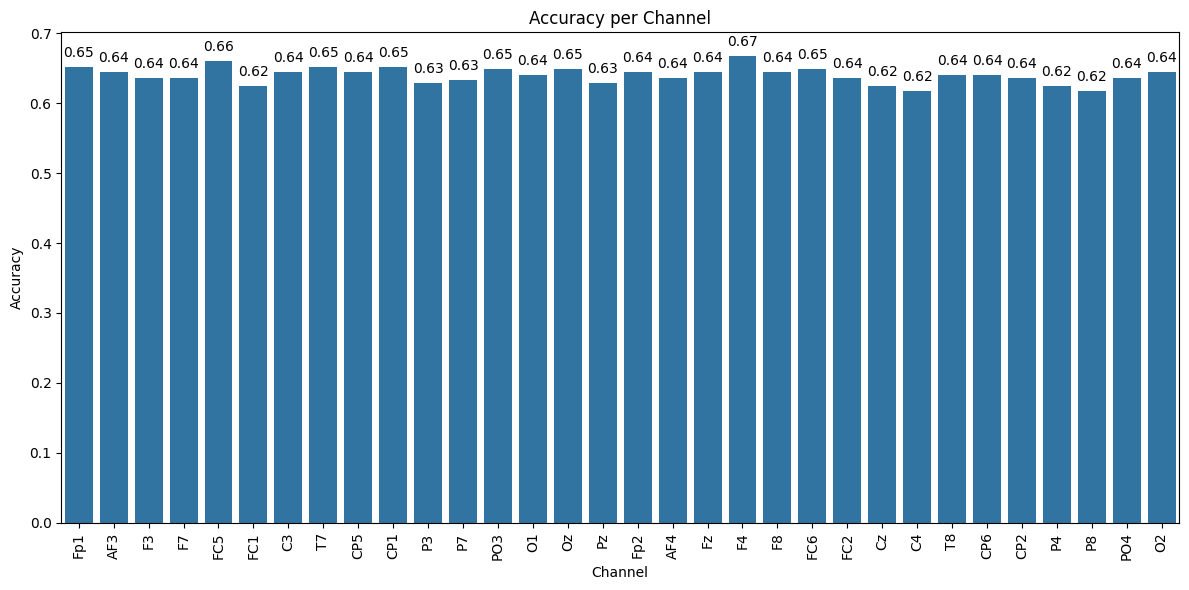

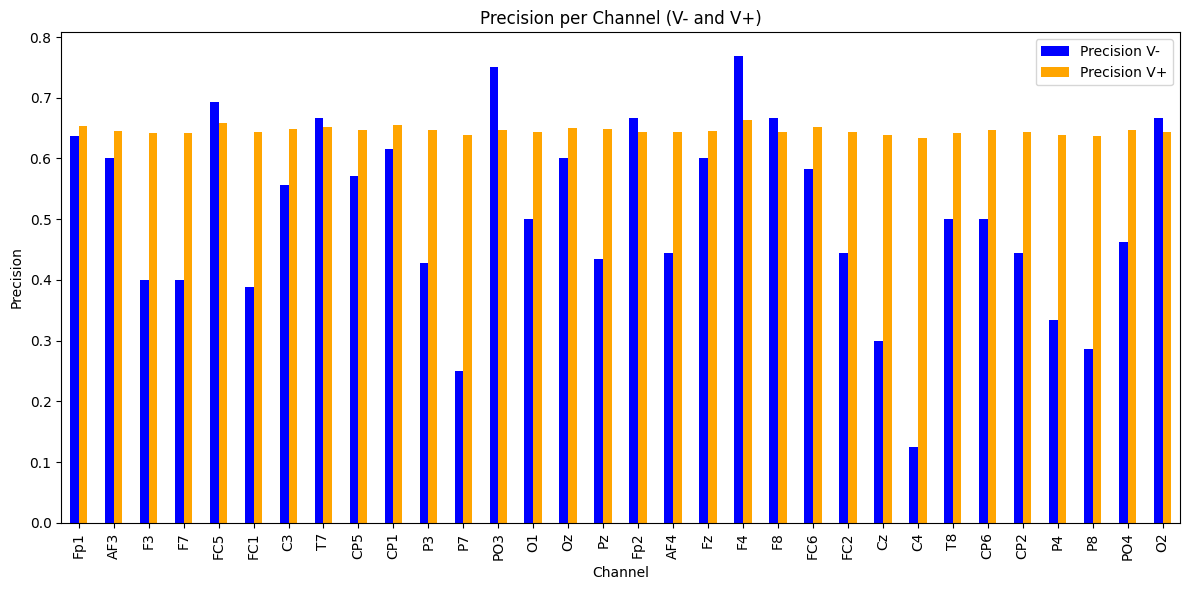

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.relu = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.lastlayer = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.lastlayer(x)
        return torch.sigmoid(x)

def crossval_train(x_train, y_train, num_epochs, learning_rate, batch_size, num_classes, n_folds, verbose=False):
    skf = StratifiedKFold(n_splits=n_folds)
    best_models = []

    for train_index, val_index in skf.split(x_train.cpu().numpy(), y_train.cpu().numpy()):
        x_tr, x_val = x_train[train_index], x_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        train_set = torch.utils.data.TensorDataset(x_tr, y_tr)
        val_set = torch.utils.data.TensorDataset(x_val, y_val)

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        model = EmotionClassifier(x_train.shape[1], num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs.squeeze(), labels).item()

            if verbose:
                print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss / len(val_loader)}")

        best_models.append(model)

    return best_models[-1]

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()

        accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
        precision = precision_score(y_test.cpu().numpy(), predicted.cpu().numpy(), average=None)
        f1 = f1_score(y_test.cpu().numpy(), predicted.cpu().numpy(), average=None)

    return accuracy, precision, f1

scaler = StandardScaler()

accuracies = []
precisions_v_minus = []
precisions_v_plus = []
channel_names = []

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        print(f"Processing channel: {ch_name}")
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        torch.manual_seed(999)

        best_model = crossval_train(X_train_tensor, y_train_tensor, num_epochs=50, learning_rate=0.001, batch_size=64, num_classes=1, n_folds=5)
        accuracy, precision, f1 = evaluate_model(best_model, X_test_tensor, y_test_tensor)

        accuracies.append(accuracy)
        precisions_v_minus.append(precision[0])
        precisions_v_plus.append(precision[1])

channels = channel_names

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=channels, y=accuracies)
plt.title("Accuracy per Channel")
plt.xlabel("Channel")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)

for i, value in enumerate(accuracies):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

precision_df = pd.DataFrame({
    'Channel': channels,
    'Precision V-': precisions_v_minus,
    'Precision V+': precisions_v_plus
})

precision_df.set_index('Channel', inplace=True)
precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

plt.title("Precision per Channel (V- and V+)")
plt.xlabel("Channel")
plt.ylabel("Precision")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Accuracy after probabilistic fusion: 0.65
Accuracy after majority vote fusion: 0.64
Accuracy after belief-based fusion: 0.65


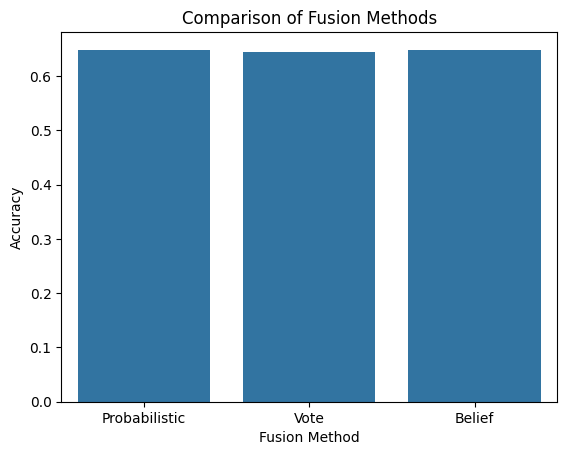

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.relu = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.lastlayer = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.lastlayer(x)
        return torch.sigmoid(x)

def crossval_train(x_train, y_train, num_epochs, learning_rate, batch_size, num_classes, n_folds, verbose=False):
    skf = StratifiedKFold(n_splits=n_folds)
    best_models = []

    for train_index, val_index in skf.split(x_train.cpu().numpy(), y_train.cpu().numpy()):
        x_tr, x_val = x_train[train_index], x_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        train_set = torch.utils.data.TensorDataset(x_tr, y_tr)
        val_set = torch.utils.data.TensorDataset(x_val, y_val)

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        model = EmotionClassifier(x_train.shape[1], num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs.squeeze(), labels).item()

            if verbose:
                print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss / len(val_loader)}")

        best_models.append(model)

    return best_models[-1]


def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        fused_beliefs = fused_beliefs * probs / (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
    return fused_beliefs

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
    return accuracy

scaler = StandardScaler()
accuracies = []
probabilities_list = []
predictions_list = []

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        pass
        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        torch.manual_seed(999)

        best_model = crossval_train(X_train_tensor, y_train_tensor, num_epochs=50, learning_rate=0.001, batch_size=64, num_classes=1, n_folds=5)

        with torch.no_grad():
            probabilities = best_model(X_test_tensor).cpu().numpy()
            predictions = (probabilities > 0.5).astype(int)

        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

fused_probabilities = fusion_probabiliste(probabilities_list)
fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
accuracy_prob = accuracy_score(y_test, fused_predictions_prob)
print(f"Accuracy after probabilistic fusion: {accuracy_prob:.2f}")

fused_predictions_vote = fusion_par_vote(predictions_list)
accuracy_vote = accuracy_score(y_test, fused_predictions_vote)
print(f"Accuracy after majority vote fusion: {accuracy_vote:.2f}")

fused_beliefs = fusion_bba(probabilities_list)
fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
accuracy_bba = accuracy_score(y_test, fused_predictions_bba)
print(f"Accuracy after belief-based fusion: {accuracy_bba:.2f}")

fusion_results = pd.DataFrame({
    'Fusion Method': ['Probabilistic', 'Vote', 'Belief'],
    'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
})

sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
plt.title('Comparison of Fusion Methods')
plt.ylabel('Accuracy')
plt.show()

2. Arousal

Processing channel: Fp1
Processing channel: AF3
Processing channel: F3
Processing channel: F7
Processing channel: FC5
Processing channel: FC1
Processing channel: C3
Processing channel: T7
Processing channel: CP5
Processing channel: CP1
Processing channel: P3
Processing channel: P7
Processing channel: PO3
Processing channel: O1
Processing channel: Oz
Processing channel: Pz
Processing channel: Fp2
Processing channel: AF4
Processing channel: Fz
Processing channel: F4
Processing channel: F8
Processing channel: FC6
Processing channel: FC2
Processing channel: Cz
Processing channel: C4
Processing channel: T8
Processing channel: CP6
Processing channel: CP2
Processing channel: P4
Processing channel: P8
Processing channel: PO4
Processing channel: O2


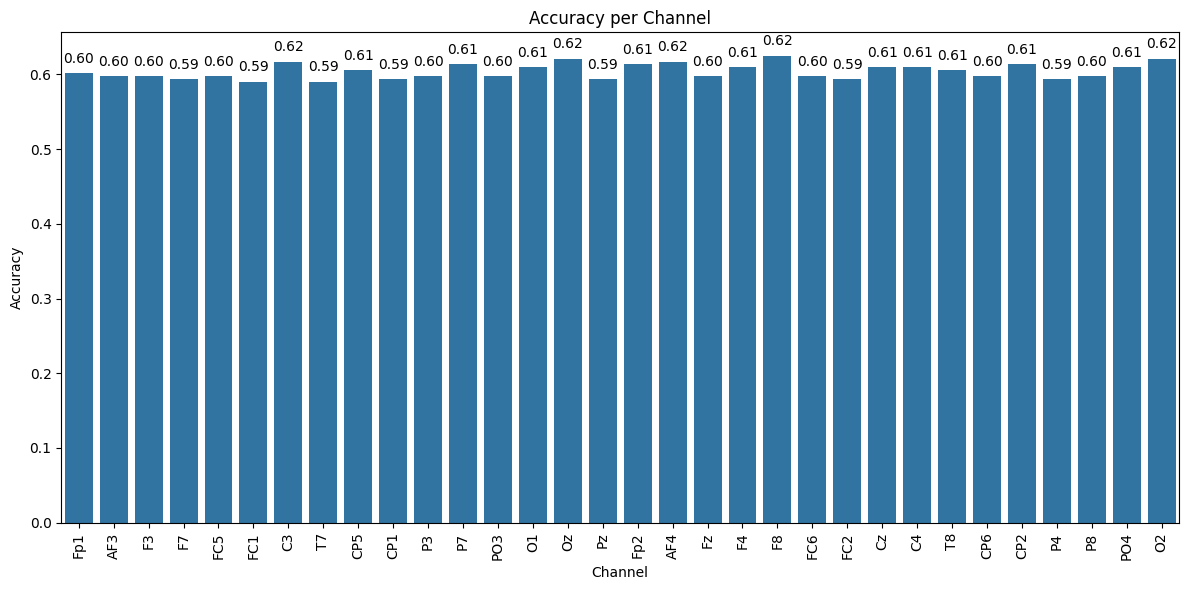

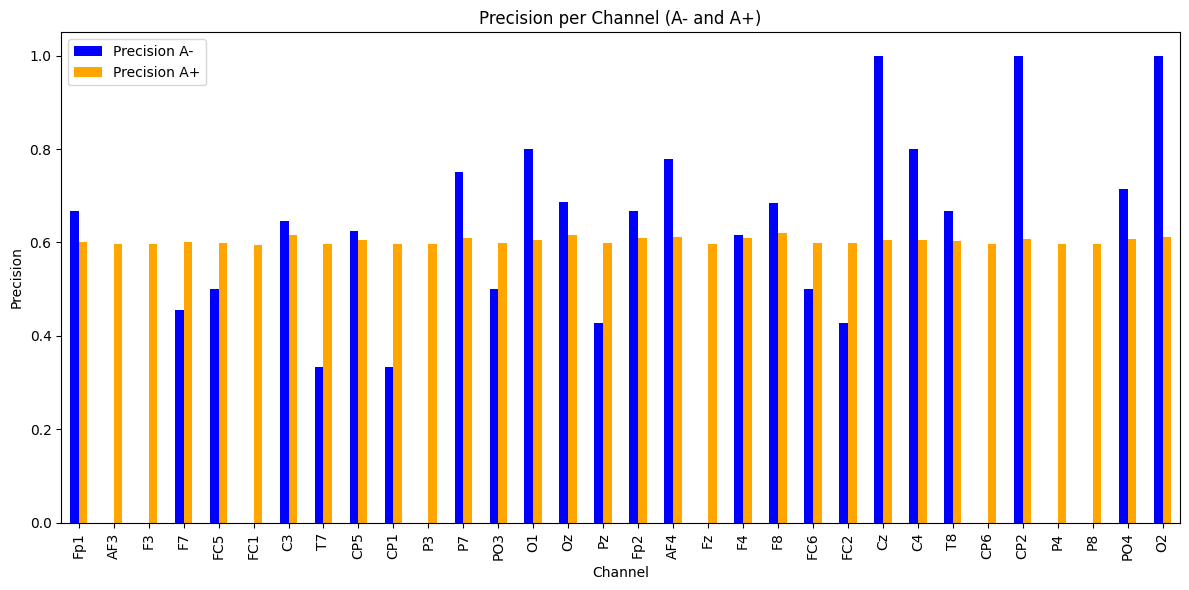

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.relu = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.lastlayer = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.lastlayer(x)
        return torch.sigmoid(x)

def crossval_train(x_train, y_train, num_epochs, learning_rate, batch_size, num_classes, n_folds, verbose=False):
    skf = StratifiedKFold(n_splits=n_folds)
    best_models = []

    for train_index, val_index in skf.split(x_train.cpu().numpy(), y_train.cpu().numpy()):
        x_tr, x_val = x_train[train_index], x_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        train_set = torch.utils.data.TensorDataset(x_tr, y_tr)
        val_set = torch.utils.data.TensorDataset(x_val, y_val)

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        model = EmotionClassifier(x_train.shape[1], num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs.squeeze(), labels).item()

            if verbose:
                print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss / len(val_loader)}")

        best_models.append(model)

    return best_models[-1]

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()

        accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
        precision = precision_score(y_test.cpu().numpy(), predicted.cpu().numpy(), average=None, zero_division=0)
        f1 = f1_score(y_test.cpu().numpy(), predicted.cpu().numpy(), average=None)

    return accuracy, precision, f1

scaler = StandardScaler()

accuracies = []
precisions_a_minus = []
precisions_a_plus = []
channel_names = []

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        print(f"Processing channel: {ch_name}")
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        torch.manual_seed(999)

        best_model = crossval_train(X_train_tensor, y_train_tensor, num_epochs=50, learning_rate=0.001, batch_size=64, num_classes=1, n_folds=5)
        accuracy, precision, f1 = evaluate_model(best_model, X_test_tensor, y_test_tensor)

        accuracies.append(accuracy)
        precisions_a_minus.append(precision[0])
        precisions_a_plus.append(precision[1])

channels = channel_names

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=channels, y=accuracies)
plt.title("Accuracy per Channel")
plt.xlabel("Channel")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)

for i, value in enumerate(accuracies):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

precision_df = pd.DataFrame({
    'Channel': channels,
    'Precision A-': precisions_a_minus,
    'Precision A+': precisions_a_plus
})

precision_df.set_index('Channel', inplace=True)
precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

plt.title("Precision per Channel (A- and A+)")
plt.xlabel("Channel")
plt.ylabel("Precision")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Accuracy after probabilistic fusion: 0.60
Accuracy after majority vote fusion: 0.60
Accuracy after belief-based fusion: 0.60


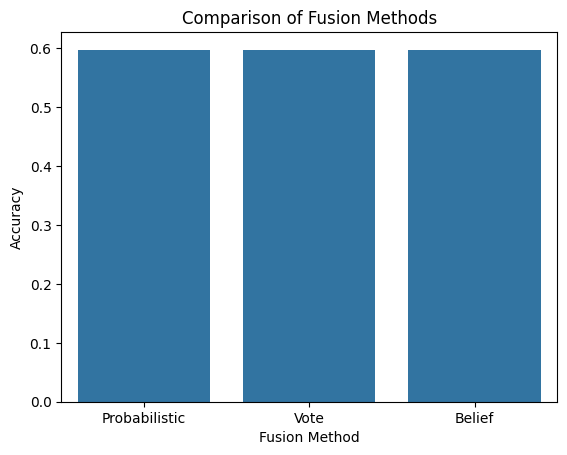

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.relu = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.lastlayer = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.lastlayer(x)
        return torch.sigmoid(x)

def crossval_train(x_train, y_train, num_epochs, learning_rate, batch_size, num_classes, n_folds, verbose=False):
    skf = StratifiedKFold(n_splits=n_folds)
    best_models = []

    for train_index, val_index in skf.split(x_train.cpu().numpy(), y_train.cpu().numpy()):
        x_tr, x_val = x_train[train_index], x_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        train_set = torch.utils.data.TensorDataset(x_tr, y_tr)
        val_set = torch.utils.data.TensorDataset(x_val, y_val)

        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        model = EmotionClassifier(x_train.shape[1], num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs.squeeze(), labels).item()

            if verbose:
                print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss / len(val_loader)}")

        best_models.append(model)

    return best_models[-1]


def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        fused_beliefs = fused_beliefs * probs / (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
    return fused_beliefs

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = accuracy_score(y_test.cpu().numpy(), predicted.cpu().numpy())
    return accuracy

scaler = StandardScaler()
accuracies = []
probabilities_list = []
predictions_list = []

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        pass
        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        torch.manual_seed(999)

        best_model = crossval_train(X_train_tensor, y_train_tensor, num_epochs=50, learning_rate=0.001, batch_size=64, num_classes=1, n_folds=5)

        with torch.no_grad():
            probabilities = best_model(X_test_tensor).cpu().numpy()
            predictions = (probabilities > 0.5).astype(int)

        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

fused_probabilities = fusion_probabiliste(probabilities_list)
fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
accuracy_prob = accuracy_score(y_test, fused_predictions_prob)
print(f"Accuracy after probabilistic fusion: {accuracy_prob:.2f}")

fused_predictions_vote = fusion_par_vote(predictions_list)
accuracy_vote = accuracy_score(y_test, fused_predictions_vote)
print(f"Accuracy after majority vote fusion: {accuracy_vote:.2f}")

fused_beliefs = fusion_bba(probabilities_list)
fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
accuracy_bba = accuracy_score(y_test, fused_predictions_bba)
print(f"Accuracy after belief-based fusion: {accuracy_bba:.2f}")

fusion_results = pd.DataFrame({
    'Fusion Method': ['Probabilistic', 'Vote', 'Belief'],
    'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
})

sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
plt.title('Comparison of Fusion Methods')
plt.ylabel('Accuracy')
plt.show()

# SVM

1. Valence

Processing channel: Fp1
Processing channel: AF3
Processing channel: F3
Processing channel: F7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: FC5
Processing channel: FC1
Processing channel: C3
Processing channel: T7
Processing channel: CP5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: CP1
Processing channel: P3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: P7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: PO3
Processing channel: O1
Processing channel: Oz
Processing channel: Pz


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: Fp2
Processing channel: AF4
Processing channel: Fz
Processing channel: F4
Processing channel: F8
Processing channel: FC6
Processing channel: FC2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: Cz


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: C4
Processing channel: T8
Processing channel: CP6


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: CP2
Processing channel: P4
Processing channel: P8
Processing channel: PO4
Processing channel: O2


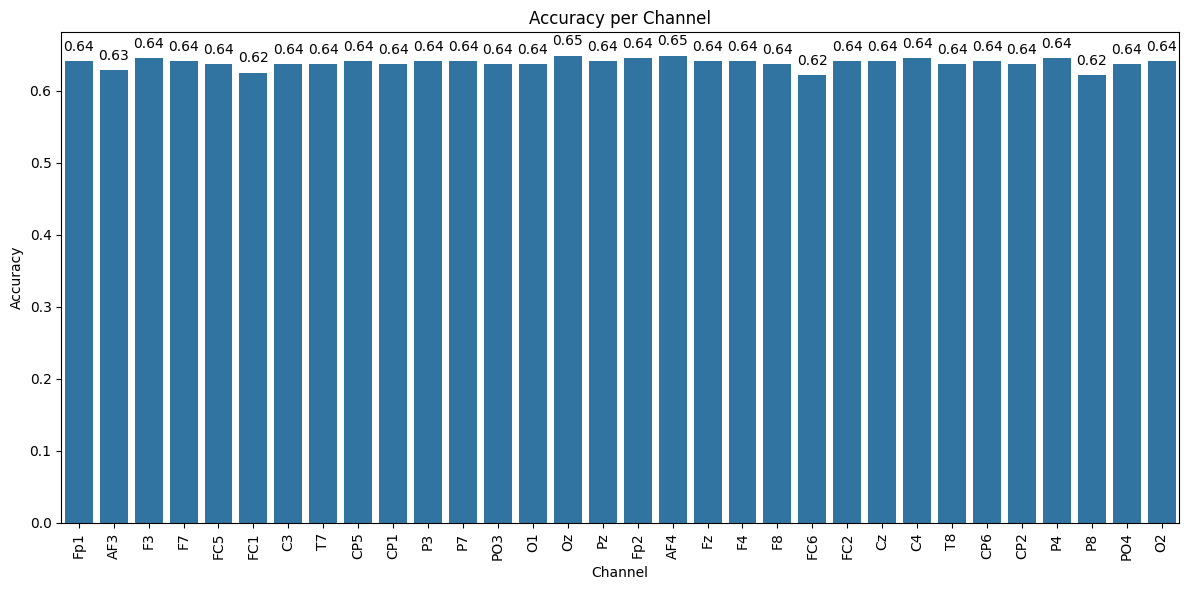

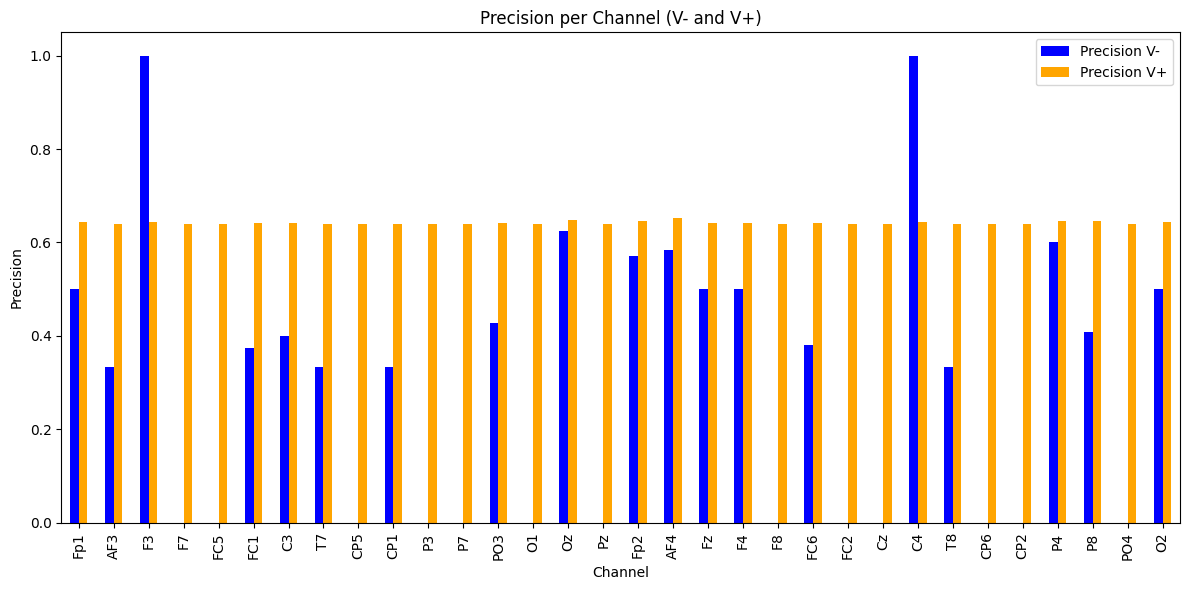

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

folder_path = '/content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

scaler = StandardScaler()
accuracies = []
precisions_v_minus = []
precisions_v_plus = []
channel_names = []

def evaluate_svm(model, X_test, y_test):
    predicted = model.predict(X_test)

    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted, average=None)
    f1 = f1_score(y_test, predicted, average=None)

    return accuracy, precision, f1

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        print(f"Processing channel: {ch_name}")
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 0.001, 0.01, 0.1, 1],
            'kernel': ['rbf', 'linear']
        }
        grid = GridSearchCV(SVC(probability=True), param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        accuracy, precision, f1 = evaluate_svm(best_model, X_test, y_test)

        accuracies.append(accuracy)
        precisions_v_minus.append(precision[0])
        precisions_v_plus.append(precision[1])

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=channel_names, y=accuracies)
plt.title("Accuracy per Channel")
plt.xlabel("Channel")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)

for i, value in enumerate(accuracies):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

precision_df = pd.DataFrame({
    'Channel': channel_names,
    'Precision V-': precisions_v_minus,
    'Precision V+': precisions_v_plus
})

precision_df.set_index('Channel', inplace=True)
precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

plt.title("Precision per Channel (V- and V+)")
plt.xlabel("Channel")
plt.ylabel("Precision")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

2. Arousal

Processing channel: Fp1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: AF3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: F3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: F7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: FC5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: FC1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: C3
Processing channel: T7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: CP5
Processing channel: CP1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: P3
Processing channel: P7
Processing channel: PO3


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: O1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: Oz
Processing channel: Pz


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: Fp2
Processing channel: AF4
Processing channel: Fz


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: F4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: F8


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: FC6
Processing channel: FC2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: Cz
Processing channel: C4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: T8
Processing channel: CP6
Processing channel: CP2
Processing channel: P4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: P8
Processing channel: PO4


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing channel: O2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


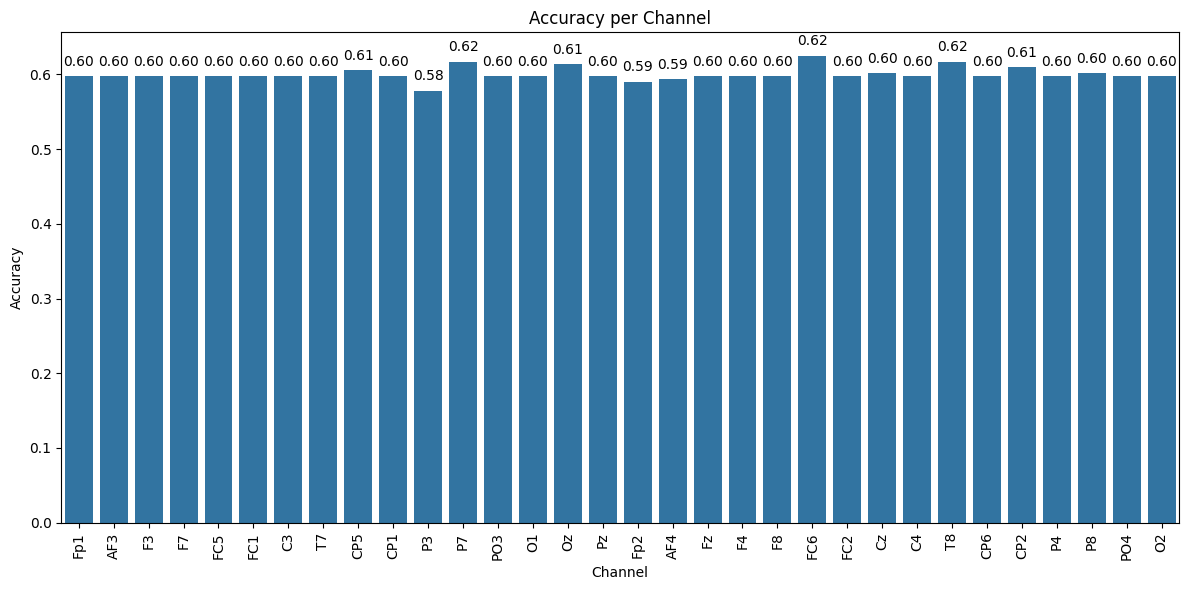

NameError: name 'precisions_v_minus' is not defined

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

folder_path = '/content/drive/MyDrive/DEAP_preprocessed/data_preprocessed_python/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

scaler = StandardScaler()
accuracies = []
precisions_a_minus = []
precisions_a_plus = []
channel_names = []

def evaluate_svm(model, X_test, y_test):
    predicted = model.predict(X_test)

    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted, average=None)
    f1 = f1_score(y_test, predicted, average=None)

    return accuracy, precision, f1

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        print(f"Processing channel: {ch_name}")
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 0.001, 0.01, 0.1, 1],
            'kernel': ['rbf', 'linear']
        }
        grid = GridSearchCV(SVC(probability=True), param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        accuracy, precision, f1 = evaluate_svm(best_model, X_test, y_test)

        accuracies.append(accuracy)
        precisions_a_minus.append(precision[0])
        precisions_a_plus.append(precision[1])

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=channel_names, y=accuracies)
plt.title("Accuracy per Channel")
plt.xlabel("Channel")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)

for i, value in enumerate(accuracies):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

precision_df = pd.DataFrame({
    'Channel': channel_names,
    'Precision A-': precisions_v_minus,
    'Precision A+': precisions_v_plus
})

precision_df.set_index('Channel', inplace=True)
precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

plt.title("Precision per Channel (V- and V+)")
plt.xlabel("Channel")
plt.ylabel("Precision")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Random Forest

1. Valence

Processing channel: Fp1
Processing channel: AF3
Processing channel: F3
Processing channel: F7
Processing channel: FC5
Processing channel: FC1
Processing channel: C3
Processing channel: T7
Processing channel: CP5
Processing channel: CP1
Processing channel: P3
Processing channel: P7
Processing channel: PO3
Processing channel: O1
Processing channel: Oz
Processing channel: Pz
Processing channel: Fp2
Processing channel: AF4
Processing channel: Fz
Processing channel: F4
Processing channel: F8
Processing channel: FC6
Processing channel: FC2
Processing channel: Cz
Processing channel: C4
Processing channel: T8
Processing channel: CP6
Processing channel: CP2
Processing channel: P4
Processing channel: P8
Processing channel: PO4
Processing channel: O2


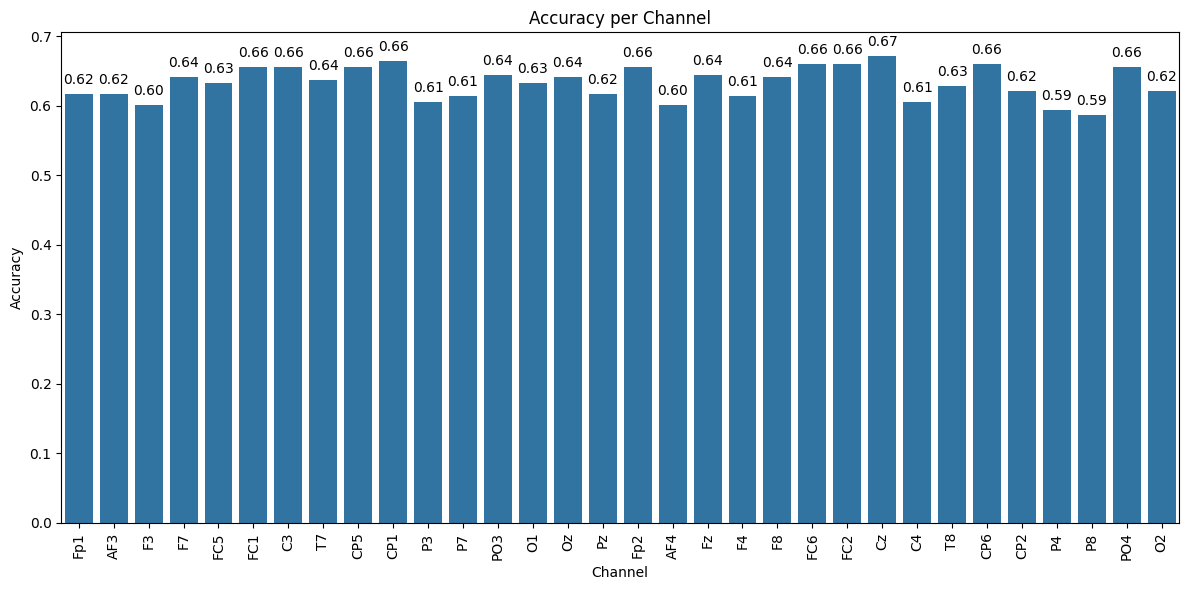

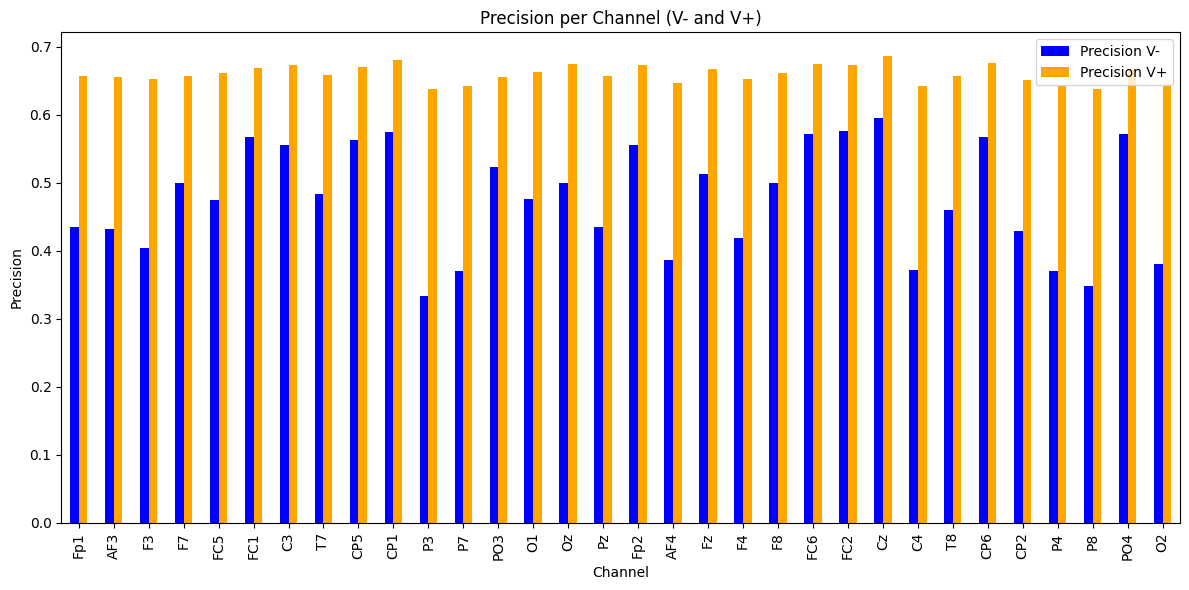

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

accuracies = []
precisions_v_minus = []
precisions_v_plus = []
channel_names = []

scaler = StandardScaler()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        print(f"Processing channel: {ch_name}")
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_rf = grid_search.best_estimator_

        y_pred = best_rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=None)

        accuracies.append(accuracy)
        precisions_v_minus.append(precision[0])
        precisions_v_plus.append(precision[1])

channels = channel_names

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=channels, y=accuracies)
plt.title("Accuracy per Channel")
plt.xlabel("Channel")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)

for i, value in enumerate(accuracies):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

precision_df = pd.DataFrame({
    'Channel': channels,
    'Precision V-': precisions_v_minus,
    'Precision V+': precisions_v_plus
})

precision_df.set_index('Channel', inplace=True)
precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

plt.title("Precision per Channel (V- and V+)")
plt.xlabel("Channel")
plt.ylabel("Precision")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Accuracy after probabilistic fusion: 0.65
Accuracy after majority vote fusion: 0.65
Accuracy after belief-based fusion: 0.65


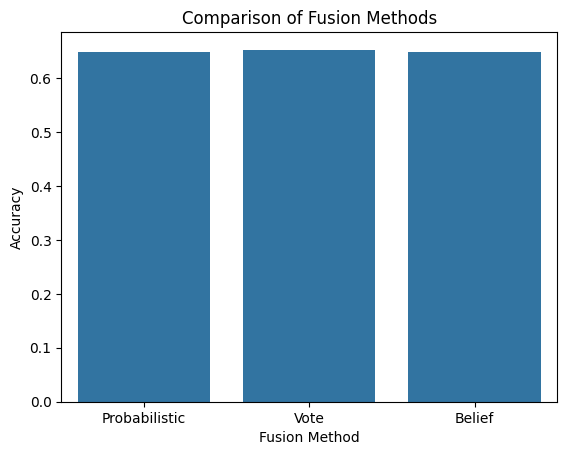

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import StratifiedKFold

def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        fused_beliefs = fused_beliefs * probs / (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
    return fused_beliefs

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

scaler = StandardScaler()
accuracies = []
precisions_v_minus = []
precisions_v_plus = []
probabilities_list = []
predictions_list = []
channel_names = []

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_rf = grid_search.best_estimator_

        y_pred = best_rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=None)

        accuracies.append(accuracy)
        precisions_v_minus.append(precision[0])
        precisions_v_plus.append(precision[1])

        probabilities = best_rf.predict_proba(X_test)[:, 1]
        predictions = (probabilities > 0.5).astype(int)
        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

fused_probabilities = fusion_probabiliste(probabilities_list)
fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
accuracy_prob = accuracy_score(y_test, fused_predictions_prob)
print(f"Accuracy after probabilistic fusion: {accuracy_prob:.2f}")

fused_predictions_vote = fusion_par_vote(predictions_list)
accuracy_vote = accuracy_score(y_test, fused_predictions_vote)
print(f"Accuracy after majority vote fusion: {accuracy_vote:.2f}")

fused_beliefs = fusion_bba(probabilities_list)
fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
accuracy_bba = accuracy_score(y_test, fused_predictions_bba)
print(f"Accuracy after belief-based fusion: {accuracy_bba:.2f}")

fusion_results = pd.DataFrame({
    'Fusion Method': ['Probabilistic', 'Vote', 'Belief'],
    'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
})

sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
plt.title('Comparison of Fusion Methods')
plt.ylabel('Accuracy')
plt.show()


2. Arousal

Processing channel: Fp1
Processing channel: F3
Processing channel: F7
Processing channel: FC5
Processing channel: FC1
Processing channel: C3
Processing channel: T7
Processing channel: CP5
Processing channel: CP1
Processing channel: P3
Processing channel: P7
Processing channel: PO3
Processing channel: O1
Processing channel: Oz
Processing channel: Pz
Processing channel: Fp2
Processing channel: AF4
Processing channel: Fz
Processing channel: F4
Processing channel: F8
Processing channel: FC6
Processing channel: FC2
Processing channel: Cz
Processing channel: C4
Processing channel: T8
Processing channel: CP6
Processing channel: CP2
Processing channel: P4
Processing channel: P8
Processing channel: PO4
Processing channel: O2


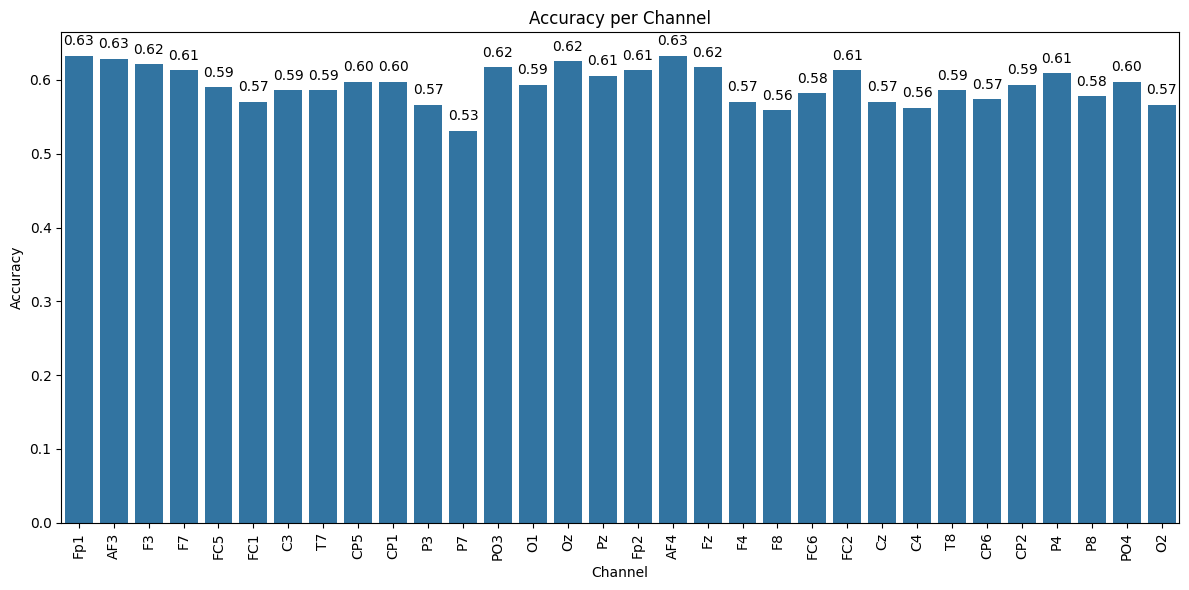

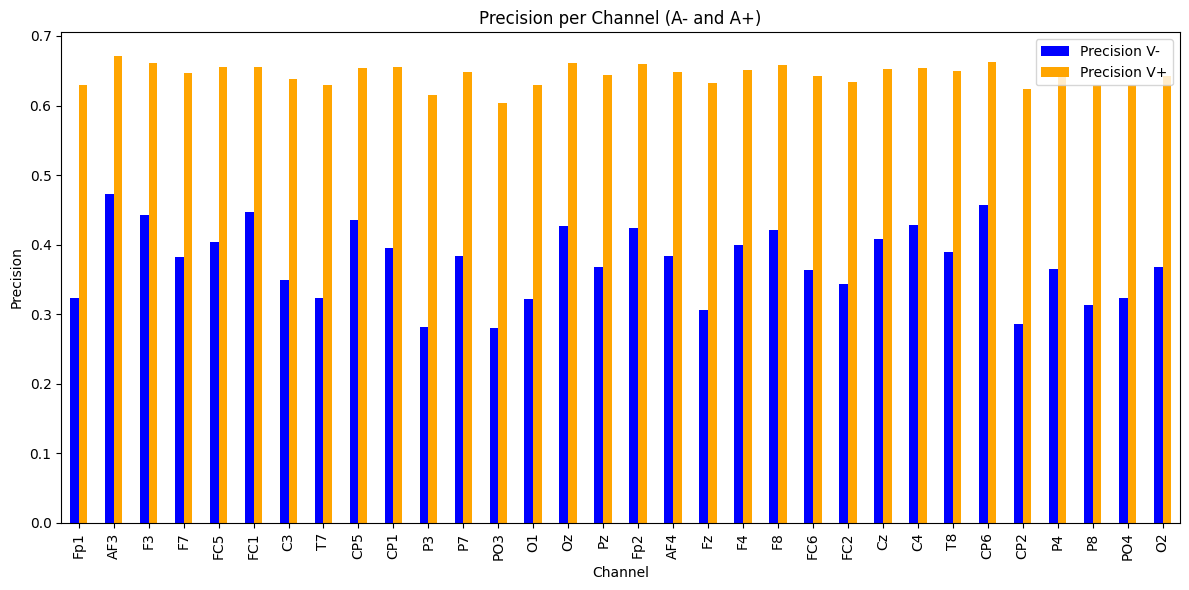

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

accuracies = []
precisions_a_minus = []
precisions_a_plus = []
channel_names = []

scaler = StandardScaler()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        print(f"Processing channel: {ch_name}")
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_rf = grid_search.best_estimator_

        y_pred = best_rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=None)

        accuracies.append(accuracy)
        precisions_a_minus.append(precision[0])
        precisions_a_plus.append(precision[1])

channels = channel_names

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=channels, y=accuracies)
plt.title("Accuracy per Channel")
plt.xlabel("Channel")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)

for i, value in enumerate(accuracies):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

precision_df = pd.DataFrame({
    'Channel': channels,
    'Precision V-': precisions_v_minus,
    'Precision V+': precisions_v_plus
})

precision_df.set_index('Channel', inplace=True)
precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

plt.title("Precision per Channel (A- and A+)")
plt.xlabel("Channel")
plt.ylabel("Precision")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Accuracy after probabilistic fusion: 0.61
Accuracy after majority vote fusion: 0.62
Accuracy after belief-based fusion: 0.61


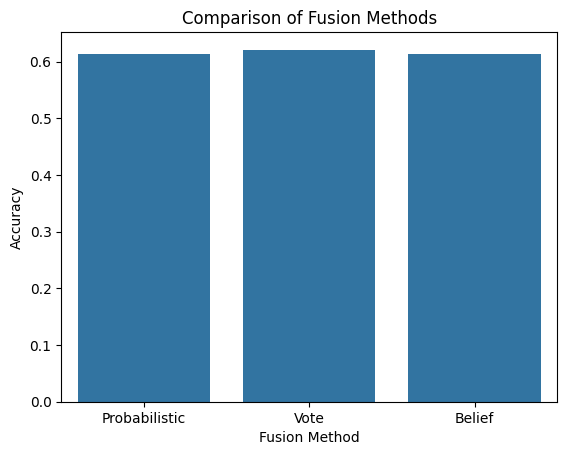

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

accuracies = []
precisions_a_minus = []
precisions_a_plus = []
channel_names = []
probabilities_list = []
predictions_list = []

scaler = StandardScaler()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        fused_beliefs = fused_beliefs * probs / (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
    return fused_beliefs

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_rf = grid_search.best_estimator_

        y_pred = best_rf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=None)

        accuracies.append(accuracy)
        precisions_a_minus.append(precision[0])
        precisions_a_plus.append(precision[1])

        probabilities = best_rf.predict_proba(X_test)[:, 1]
        predictions = y_pred

        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

channels = channel_names


fused_probabilities = fusion_probabiliste(probabilities_list)
fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
accuracy_prob = accuracy_score(y_test, fused_predictions_prob)
print(f"Accuracy after probabilistic fusion: {accuracy_prob:.2f}")

fused_predictions_vote = fusion_par_vote(predictions_list)
accuracy_vote = accuracy_score(y_test, fused_predictions_vote)
print(f"Accuracy after majority vote fusion: {accuracy_vote:.2f}")

fused_beliefs = fusion_bba(probabilities_list)
fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
accuracy_bba = accuracy_score(y_test, fused_predictions_bba)
print(f"Accuracy after belief-based fusion: {accuracy_bba:.2f}")

fusion_results = pd.DataFrame({
    'Fusion Method': ['Probabilistic', 'Vote', 'Belief'],
    'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
})

sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
plt.title('Comparison of Fusion Methods')
plt.ylabel('Accuracy')
plt.show()


# KNN

1. Valence

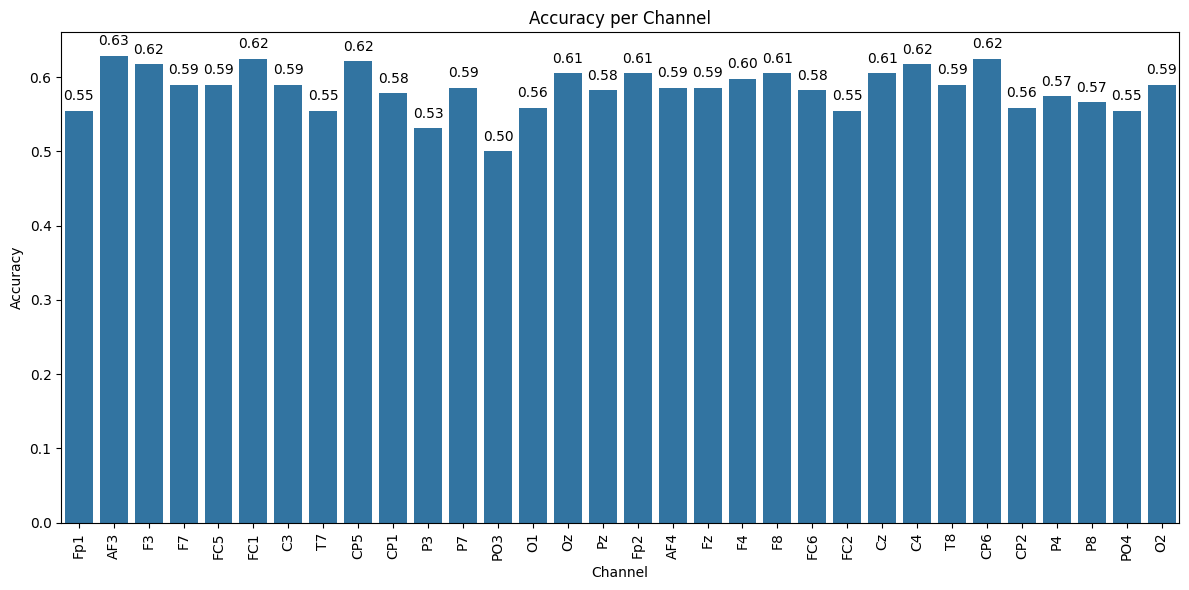

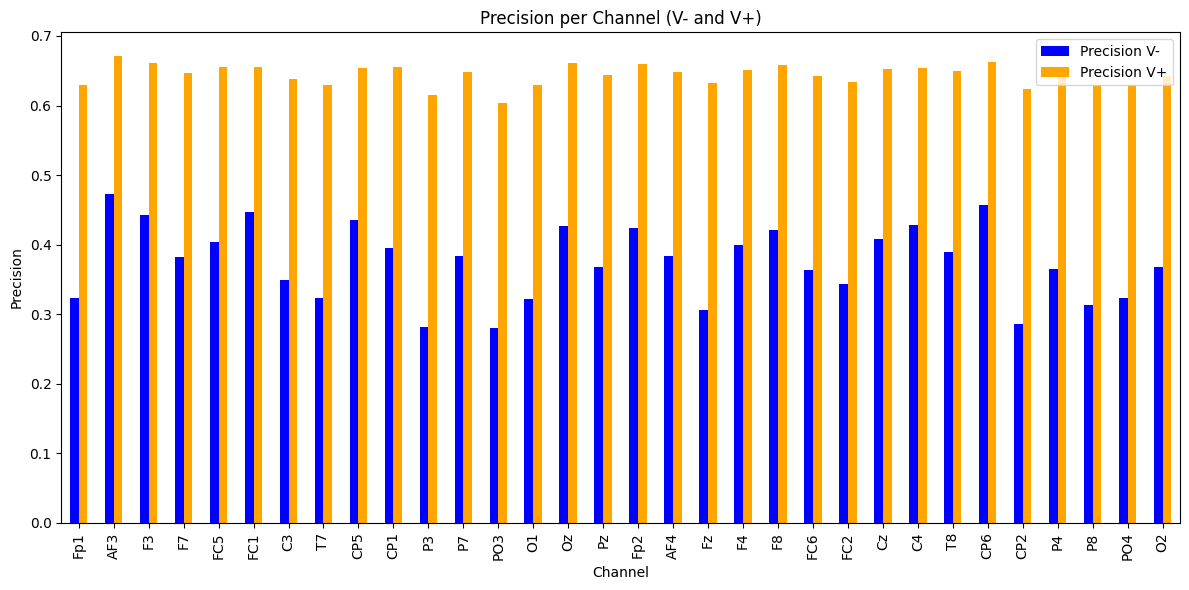

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

accuracies = []
precisions_v_minus = []
precisions_v_plus = []
channel_names = []

scaler = StandardScaler()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        knn = KNeighborsClassifier()
        grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_knn = grid_search.best_estimator_

        y_pred = best_knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=None)

        accuracies.append(accuracy)
        precisions_v_minus.append(precision[0])
        precisions_v_plus.append(precision[1])

channels = channel_names

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=channels, y=accuracies)
plt.title("Accuracy per Channel")
plt.xlabel("Channel")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)

for i, value in enumerate(accuracies):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

precision_df = pd.DataFrame({
    'Channel': channels,
    'Precision V-': precisions_v_minus,
    'Precision V+': precisions_v_plus
})

precision_df.set_index('Channel', inplace=True)
precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

plt.title("Precision per Channel (V- and V+)")
plt.xlabel("Channel")
plt.ylabel("Precision")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Accuracy after probabilistic fusion: 0.64
Accuracy after majority vote fusion: 0.67
Accuracy after belief-based fusion: 0.62


<ipython-input-16-6e86215d1cac>:21: RuntimeWarning: invalid value encountered in divide
  fused_beliefs = fused_beliefs * probs / (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))


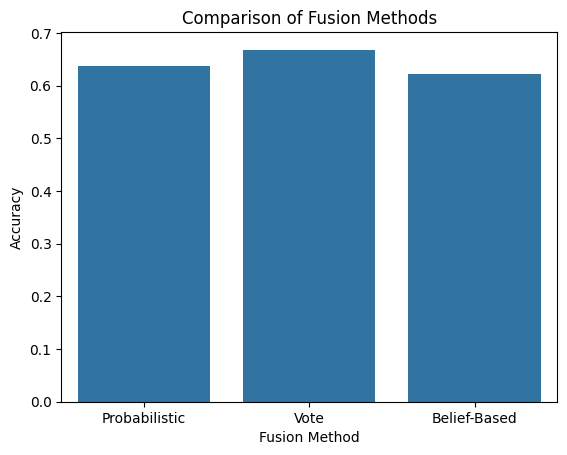

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        fused_beliefs = fused_beliefs * probs / (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
    return fused_beliefs

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
valence_targets = targets['Valence']
y = (valence_targets >= 4.5).astype(int)

scaler = StandardScaler()
accuracies = []
precisions_v_minus = []
precisions_v_plus = []
probabilities_list = []
predictions_list = []
channel_names = []

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        knn = KNeighborsClassifier()
        grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_knn = grid_search.best_estimator_

        y_pred = best_knn.predict(X_test)
        probabilities = best_knn.predict_proba(X_test)[:, 1]
        predictions = (probabilities > 0.5).astype(int)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions = precision_score(y_test, y_pred, average=None)
        precisions_v_minus.append(precisions[0])
        precisions_v_plus.append(precisions[1])
        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

fused_probabilities = fusion_probabiliste(probabilities_list)
fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
accuracy_prob = accuracy_score(y_test, fused_predictions_prob)
print(f"Accuracy after probabilistic fusion: {accuracy_prob:.2f}")

fused_predictions_vote = fusion_par_vote(predictions_list)
accuracy_vote = accuracy_score(y_test, fused_predictions_vote)
print(f"Accuracy after majority vote fusion: {accuracy_vote:.2f}")

fused_beliefs = fusion_bba(probabilities_list)
fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
accuracy_bba = accuracy_score(y_test, fused_predictions_bba)
print(f"Accuracy after belief-based fusion: {accuracy_bba:.2f}")

fusion_results = pd.DataFrame({
    'Fusion Method': ['Probabilistic', 'Vote', 'Belief-Based'],
    'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
})

sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
plt.title('Comparison of Fusion Methods')
plt.ylabel('Accuracy')
plt.show()

2. Arousal

Processing channel: Fp1
Processing channel: AF3
Processing channel: F3
Processing channel: F7
Processing channel: FC5
Processing channel: FC1
Processing channel: C3
Processing channel: T7
Processing channel: CP5
Processing channel: CP1
Processing channel: P3
Processing channel: P7
Processing channel: PO3
Processing channel: O1
Processing channel: Oz
Processing channel: Pz
Processing channel: Fp2
Processing channel: AF4
Processing channel: Fz
Processing channel: F4
Processing channel: F8
Processing channel: FC6
Processing channel: FC2
Processing channel: Cz
Processing channel: C4
Processing channel: T8
Processing channel: CP6
Processing channel: CP2
Processing channel: P4
Processing channel: P8
Processing channel: PO4
Processing channel: O2


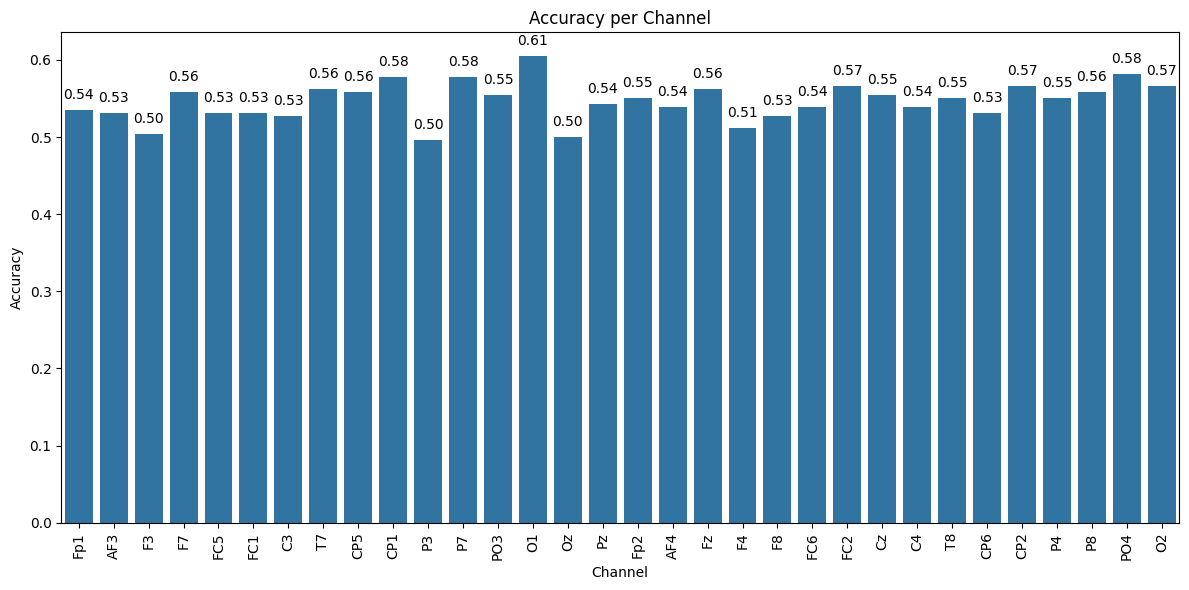

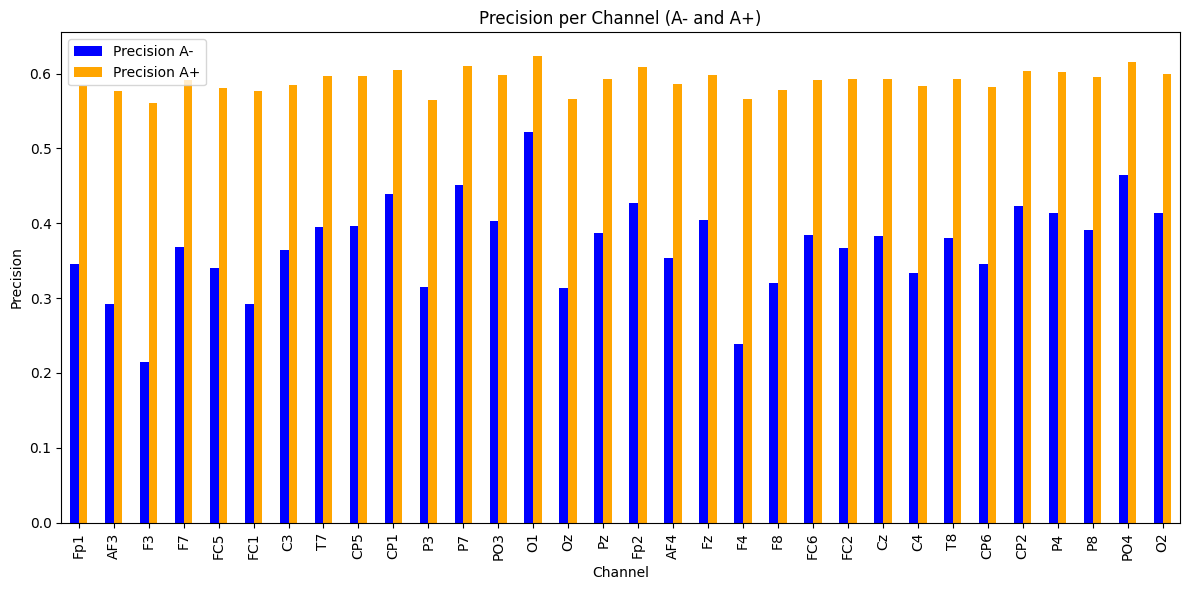

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

accuracies = []
precisions_a_minus = []
precisions_a_plus = []
channel_names = []

scaler = StandardScaler()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        print(f"Processing channel: {ch_name}")
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        knn = KNeighborsClassifier()
        grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_knn = grid_search.best_estimator_

        y_pred = best_knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=None)

        accuracies.append(accuracy)
        precisions_a_minus.append(precision[0])
        precisions_a_plus.append(precision[1])

channels = channel_names

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=channels, y=accuracies)
plt.title("Accuracy per Channel")
plt.xlabel("Channel")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)

for i, value in enumerate(accuracies):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

precision_df = pd.DataFrame({
    'Channel': channels,
    'Precision A-': precisions_a_minus,
    'Precision A+': precisions_a_plus
})

precision_df.set_index('Channel', inplace=True)
precision_df.plot(kind='bar', figsize=(12, 6), color=['blue', 'orange'])

plt.title("Precision per Channel (A- and A+)")
plt.xlabel("Channel")
plt.ylabel("Precision")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Accuracy after probabilistic fusion: 0.59
Accuracy after majority vote fusion: 0.58
Accuracy after belief-based fusion: 0.58


<ipython-input-22-e0b134e34ae8>:41: RuntimeWarning: invalid value encountered in divide
  fused_beliefs = fused_beliefs * probs / (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))


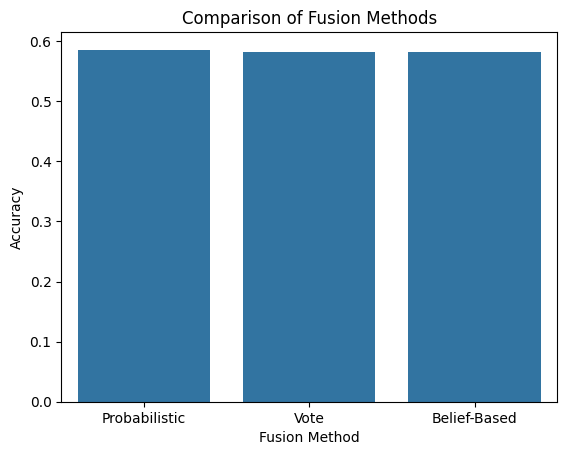

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

folder_path = '/content/drive/MyDrive/DEAP/eeg_band_power'
targets = pd.read_csv('Participant_rating.csv', index_col=0)
arousal_targets = targets['Arousal']
y = (arousal_targets >= 4.5).astype(int)

accuracies = []
precisions_a_minus = []
precisions_a_plus = []
probabilities_list = []
predictions_list = []
channel_names = []

scaler = StandardScaler()

param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

def fusion_probabiliste(probabilities_list):
    return np.mean(probabilities_list, axis=0)

def fusion_par_vote(predictions_list):
    predictions_array = np.array(predictions_list)
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions_array)

def fusion_bba(probabilities_list):
    fused_beliefs = probabilities_list[0]
    for probs in probabilities_list[1:]:
        fused_beliefs = fused_beliefs * probs / (fused_beliefs * probs + (1 - fused_beliefs) * (1 - probs))
    return fused_beliefs

for ch_name in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, ch_name)):
        channel_names.append(ch_name)

        ch_data = []
        for file_name in os.listdir(os.path.join(folder_path, ch_name)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, ch_name, file_name)
                file_data = pd.read_csv(file_path)
                ch_data.append(file_data)

        ch_data = pd.concat(ch_data, axis=0, ignore_index=True)
        X = ch_data.values
        X_scaled = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        knn = KNeighborsClassifier()
        grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', cv=5, verbose=0, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_knn = grid_search.best_estimator_

        y_pred = best_knn.predict(X_test)
        probabilities = best_knn.predict_proba(X_test)[:, 1]
        predictions = (probabilities > 0.5).astype(int)

        accuracies.append(accuracy_score(y_test, y_pred))
        precisions = precision_score(y_test, y_pred, average=None)
        precisions_a_minus.append(precisions[0])
        precisions_a_plus.append(precisions[1])
        probabilities_list.append(probabilities)
        predictions_list.append(predictions)

fused_probabilities = fusion_probabiliste(probabilities_list)
fused_predictions_prob = (fused_probabilities > 0.5).astype(int)
accuracy_prob = accuracy_score(y_test, fused_predictions_prob)

fused_predictions_vote = fusion_par_vote(predictions_list)
accuracy_vote = accuracy_score(y_test, fused_predictions_vote)

fused_beliefs = fusion_bba(probabilities_list)
fused_predictions_bba = (fused_beliefs > 0.5).astype(int)
accuracy_bba = accuracy_score(y_test, fused_predictions_bba)

print(f"Accuracy after probabilistic fusion: {accuracy_prob:.2f}")
print(f"Accuracy after majority vote fusion: {accuracy_vote:.2f}")
print(f"Accuracy after belief-based fusion: {accuracy_bba:.2f}")

fusion_results = pd.DataFrame({
    'Fusion Method': ['Probabilistic', 'Vote', 'Belief-Based'],
    'Accuracy': [accuracy_prob, accuracy_vote, accuracy_bba]
})

sns.barplot(data=fusion_results, x='Fusion Method', y='Accuracy')
plt.title("Comparison of Fusion Methods")
plt.ylabel("Accuracy")
plt.show()

# Fusion au niveau des caractéristiques (Features Fusion)


# **Feature Extraction and labeling**

In [ ]:
eeg_data = data[:,:32,:]
print(eeg_data.shape)

(1280, 32, 8064)


In [ ]:
from scipy.signal import welch
from scipy.integrate import simps
def bandpower(data, sf, band):
    band = np.asarray(band)
    low, high = band
    nperseg = (2 / low) * sf
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    bp = simps(psd[idx_band], dx=freq_res)
    return bp

def get_band_power(people, channel, band):
    bd = (0,0)
    if (band == "alpha"):
        bd = (8,12)
    elif (band == "beta"):
        bd = (12,30)
    elif (band == "gamma"):
        bd = (30,64)
    return bandpower(eeg_data[people,channel], 128, bd)

In [ ]:
eeg_band = []
for i in range (len(eeg_data)):
    for j in range (len(eeg_data[0])):
        eeg_band.append(get_band_power(i,j,"alpha"))
        eeg_band.append(get_band_power(i,j,"beta"))
        eeg_band.append(get_band_power(i,j,"gamma"))

print(eeg_band)

<ipython-input-19-c81f77656bcb>:10: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  bp = simps(psd[idx_band], dx=freq_res)


[3.362791493370197, 5.815233520756526, 1.2166033836665515, 3.9444520352853933, 6.646148630091014, 1.2613360583111093, 4.485899535322619, 7.240252641569191, 1.3777141305770404, 4.550864946404401, 6.17307619426514, 1.3628766567061827, 2.405287571767463, 3.214780958650517, 0.8125313337017548, 2.195663017110851, 3.7151825083143564, 0.8069150108773735, 3.0132749631395415, 3.714193171775194, 0.8899287655860659, 4.847536783501715, 7.135176344162965, 3.041731403197622, 3.6592612610774413, 4.457323622256803, 1.0191596407544297, 1.948840567994361, 2.7643646638222608, 0.5384573629515371, 5.814227292101414, 6.679902739976402, 1.348346562723081, 5.5707159194829226, 7.165019523884713, 2.099579632374412, 6.327640401719285, 7.020348641661248, 1.3791037489406748, 5.31290629900557, 6.998365674133781, 2.2133800005599373, 4.764141092129503, 5.8724085772717975, 1.1957784210441051, 2.9003151403641985, 3.7156420823573475, 0.5787025131011767, 4.427388053331896, 6.400833776012127, 1.3028300368742318, 3.8347937

In [ ]:
eeg_band = np.array(eeg_band)
eeg_band = eeg_band.reshape((1280,96)) # 5×32
print(eeg_band.shape)
print(eeg_band)

(1280, 96)
[[ 3.36279149  5.81523352  1.21660338 ...  5.36959551  6.28655627
   0.98791596]
 [ 4.15979656  6.39537379  1.45017406 ...  6.85017834  6.79591151
   1.15246953]
 [ 4.29442575  6.7214236   1.54199937 ...  8.20932022  8.42977741
   1.41079136]
 ...
 [ 3.38117549  5.04944328  2.48641567 ... 17.65654419 12.39233743
   4.49802931]
 [ 4.21561764 10.32887456  8.26667992 ... 13.22258992 10.60470145
   4.59401036]
 [ 3.71835627  5.5672111   2.56312175 ... 17.48662794 11.05951434
   3.42741801]]


In [ ]:
np.save("eeg_band.npy", eeg_band)
eeg_band = np.load("eeg_band.npy")
print(eeg_band.shape)

(1280, 96)


## Construire les données de l’étiquette

In [ ]:
import pandas as pd
df_label = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1],
                        'Dominance': labels[:,2], 'Liking': labels[:,3]})
df_label

Valence  Arousal  Dominance  Liking
0        7.71     7.60       6.90    7.83
1        8.10     7.31       7.28    8.47
2        8.58     7.54       9.00    7.08
3        4.94     6.01       6.12    8.06
4        6.96     3.92       7.19    6.05
...       ...      ...        ...     ...
1275     3.91     6.96       5.82    3.12
1276     2.81     6.13       6.06    1.04
1277     3.05     7.01       5.10    1.10
1278     3.99     7.17       4.85    1.00
1279     7.15     4.03       9.00    1.88

[1280 rows x 4 columns]

In [ ]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Valence    1280 non-null   float64
 1   Arousal    1280 non-null   float64
 2   Dominance  1280 non-null   float64
 3   Liking     1280 non-null   float64
dtypes: float64(4)
memory usage: 40.1 KB


In [ ]:
df_label.describe()

Valence      Arousal    Dominance       Liking
count  1280.000000  1280.000000  1280.000000  1280.000000
mean      5.254313     5.156711     5.382750     5.518133
std       2.130816     2.020499     2.096321     2.282780
min       1.000000     1.000000     1.000000     1.000000
25%       3.867500     3.762500     3.932500     3.960000
50%       5.040000     5.230000     5.240000     6.050000
75%       7.050000     6.950000     7.040000     7.090000
max       9.000000     9.000000     9.000000     9.000000

In [ ]:
label_name = ["valence","arousal"]
labels_valence = []
labels_arousal = []
for la in labels:
    l = []
    if la[0]>4.5:
        labels_valence.append(1)
    else:
        labels_valence.append(0)
    if la[1]>4.5:
        labels_arousal.append(1)
    else:
        labels_arousal.append(0)


# Création de modèles, formation, tests et optimisation

# **Classification**

In [ ]:
#Données X
data_x = eeg_band
print(data_x.shape)
#Données Y
label_y0 = labels_valence
label_y1 = labels_arousal
trainscores = []
testscores = []

(1280, 96)


## KNN

##Vanlence

In [ ]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

poly = preprocessing.PolynomialFeatures(degree=1)
X = poly.fit_transform(data_x)

scaler = preprocessing.StandardScaler()  # Standardisation
X = scaler.fit_transform(X)

# Réduction de la dimensionnalité
pca = PCA(n_components=0.95)  # Ajuster pour conserver 95% de la variance
X = pca.fit_transform(X)
print(X.shape)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, label_y0, test_size=0.20, random_state=42)

# Recherche des hyperparamètres
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

# Modèle optimisé
knn_best = grid_search.best_estimator_
train_score_V_KNN = knn_best.score(X_train, y_train)
test_score_V_KNN = knn_best.score(X_test, y_test)

print("Score de l’ensemble d’entraînement :", train_score_V_KNN)
print("Score de l’ensemble de tests :", test_score_V_KNN)

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(knn_best, X, label_y0, cv=5, scoring='accuracy')
print("Scores de validation croisée :", cv_scores)
print("Score moyen de validation croisée :", cv_scores.mean())


(1280, 11)
Meilleurs paramètres : {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Score de l’ensemble d’entraînement : 0.7197265625
Score de l’ensemble de tests : 0.6640625
Scores de validation croisée : [0.63671875 0.4921875  0.484375   0.5078125  0.46875   ]
Score moyen de validation croisée : 0.51796875


##Arousal

In [ ]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Prétraitement
poly = preprocessing.PolynomialFeatures(degree=1)  # Réduction du degré
X = poly.fit_transform(data_x)

scaler = preprocessing.StandardScaler()  # Standardisation
X = scaler.fit_transform(X)

# Réduction de la dimensionnalité
pca = PCA(n_components=0.95)  # Ajuster pour conserver 95% de la variance
X = pca.fit_transform(X)
print(X.shape)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, label_y1, test_size=0.20, random_state=42)

# Recherche des hyperparamètres
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres :", grid_search.best_params_)

# Modèle optimisé
knn_best = grid_search.best_estimator_
train_score_A_KNN = knn_best.score(X_train, y_train)
test_score_A_KNN = knn_best.score(X_test, y_test)

print("Score de l’ensemble d’entraînement :", train_score_A_KNN)
print("Score de l’ensemble de tests :", test_score_A_KNN)


from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(knn_best, X, label_y1, cv=5, scoring='accuracy')
print("Scores de validation croisée :", cv_scores)
print("Score moyen de validation croisée :", cv_scores.mean())


(1280, 11)
Meilleurs paramètres : {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Score de l’ensemble d’entraînement : 0.724609375
Score de l’ensemble de tests : 0.63671875
Scores de validation croisée : [0.39453125 0.34765625 0.54296875 0.55859375 0.49609375]
Score moyen de validation croisée : 0.46796875


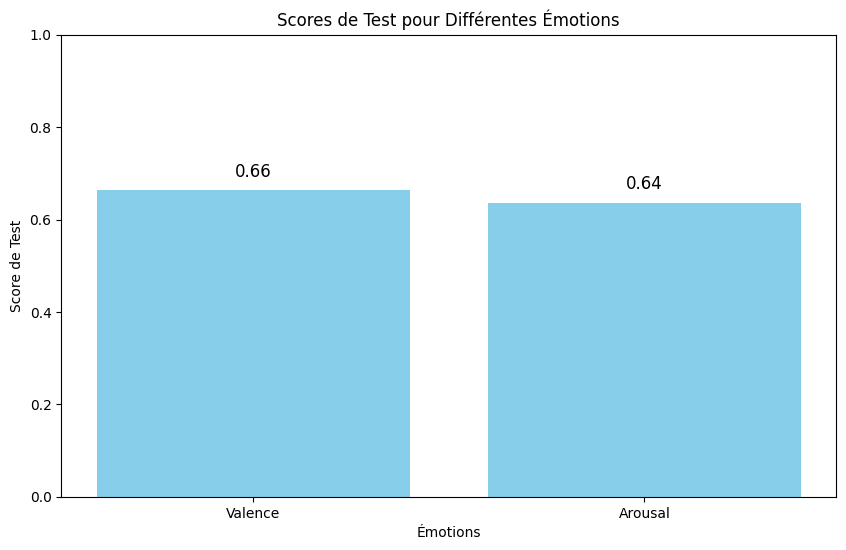

In [ ]:
import matplotlib.pyplot as plt
emotions = ['Valence', 'Arousal']
testscores = [test_score_V_KNN, test_score_A_KNN]
plt.figure(figsize=(10,6))
bars = plt.bar(emotions, testscores, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Score de Test')
plt.title('Scores de Test pour Différentes Émotions')
plt.ylim(0, 1)

for bar, score in zip(bars, testscores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

## SVM

##Valence

In [ ]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import numpy as np

poly = preprocessing.PolynomialFeatures(degree=1)
X = poly.fit_transform(data_x)

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X = pca.fit_transform(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, label_y0, test_size=0.20, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")

svc = grid_search.best_estimator_
train_score_V_SVM = svc.score(X_train, y_train)
test_score_V_SVM = svc.score(X_test, y_test)

print(f"Score de l’ensemble d’entraînement : {train_score_V_SVM}")
print(f"Score de l’ensemble de tests : {test_score_V_SVM}")



(1280, 11)
Meilleurs paramètres : {'C': 100, 'gamma': 'auto', 'kernel': 'poly'}
Score de l’ensemble d’entraînement : 0.748046875
Score de l’ensemble de tests : 0.609375


##Arousal

In [ ]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import numpy as np

poly = preprocessing.PolynomialFeatures(degree=1)
X = poly.fit_transform(data_x)

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X = pca.fit_transform(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, label_y1, test_size=0.20, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear', 'poly']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")

svc = grid_search.best_estimator_
train_score_A_SVM = svc.score(X_train, y_train)
test_score_A_SVM = svc.score(X_test, y_test)

print(f"Score de l’ensemble d’entraînement : {train_score_A_SVM}")
print(f"Score de l’ensemble de tests : {test_score_A_SVM}")



(1280, 11)
Meilleurs paramètres : {'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
Score de l’ensemble d’entraînement : 0.65234375
Score de l’ensemble de tests : 0.65234375


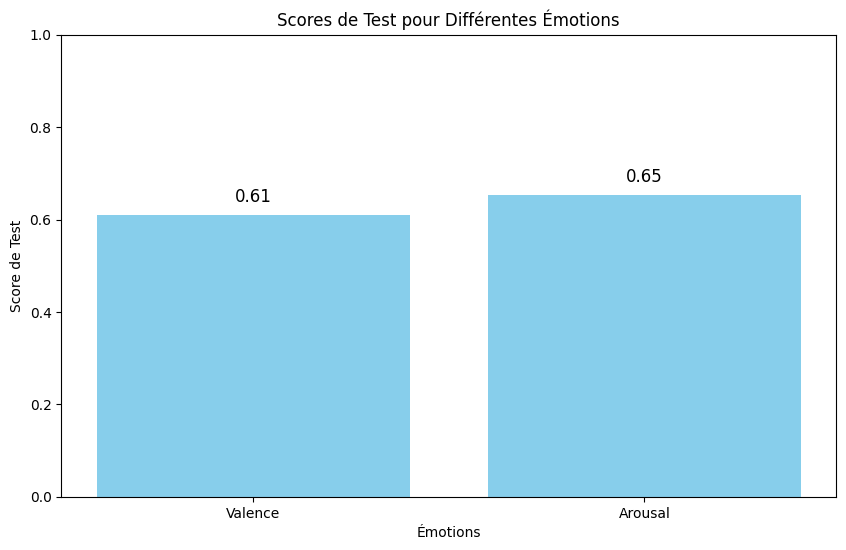

In [ ]:
import matplotlib.pyplot as plt
emotions = ['Valence', 'Arousal']
testscores1 = [test_score_V_SVM, test_score_A_SVM]
plt.figure(figsize=(10,6))
bars = plt.bar(emotions, testscores1, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Score de Test')
plt.title('Scores de Test pour Différentes Émotions')
plt.ylim(0, 1)

for bar, score in zip(bars, testscores1):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

## Arbre de décision

##Valence

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Prétraitement
scaler = StandardScaler()
X = scaler.fit_transform(data_x)

pca = PCA(n_components=0.95)  # Conserver 95% de la variance
X = pca.fit_transform(X)
print("Nouvelle forme des données :", X.shape)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, label_y0, test_size=0.20, random_state=42)

# Recherche des hyperparamètres
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 2, 5]
}

dtree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Modèle optimisé
dtree_best = grid_search.best_estimator_
train_score_V_AD = dtree_best.score(X_train, y_train)
test_score_V_AD = dtree_best.score(X_test, y_test)

print("Score de l’ensemble d’entraînement :", train_score_V_AD)
print("Score de l’ensemble de tests :", test_score_V_AD)

# Validation croisée
cv_scores = cross_val_score(dtree_best, X, label_y0, cv=5, scoring='accuracy')
print("Scores de validation croisée :", cv_scores)
print("Score moyen :", cv_scores.mean())


Nouvelle forme des données : (1280, 11)
Meilleurs hyperparamètres : {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Score de l’ensemble d’entraînement : 0.798828125
Score de l’ensemble de tests : 0.6015625
Scores de validation croisée : [0.5859375  0.61328125 0.46484375 0.421875   0.41796875]
Score moyen : 0.50078125


##Arousal

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Prétraitement
scaler = StandardScaler()
X = scaler.fit_transform(data_x)

pca = PCA(n_components=0.95)  # Conserver 95% de la variance
X = pca.fit_transform(X)
print("Nouvelle forme des données :", X.shape)

# Division des données
X_train, X_test, y_train, y_test = train_test_split(X, label_y1, test_size=0.20, random_state=42)

# Recherche des hyperparamètres
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [1, 2, 5]
}

dtree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Modèle optimisé
dtree_best = grid_search.best_estimator_
train_score_A_AD = dtree_best.score(X_train, y_train)
test_score_A_AD = dtree_best.score(X_test, y_test)

print("Score de l’ensemble d’entraînement :", train_score_A_AD)
print("Score de l’ensemble de tests :", test_score_A_AD)

# Validation croisée
cv_scores = cross_val_score(dtree_best, X, label_y1, cv=5, scoring='accuracy')
print("Scores de validation croisée :", cv_scores)
print("Score moyen :", cv_scores.mean())


Nouvelle forme des données : (1280, 11)
Meilleurs hyperparamètres : {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}
Score de l’ensemble d’entraînement : 0.9677734375
Score de l’ensemble de tests : 0.546875
Scores de validation croisée : [0.41015625 0.40625    0.38671875 0.61328125 0.4765625 ]
Score moyen : 0.45859375


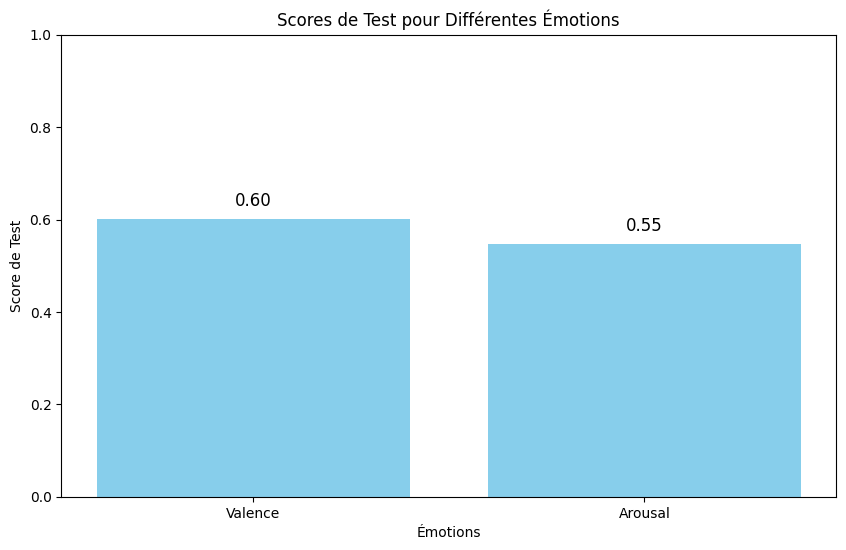

In [ ]:
import matplotlib.pyplot as plt
emotions = ['Valence', 'Arousal']
testscores1 = [test_score_V_AD, test_score_A_AD]
plt.figure(figsize=(10,6))
bars = plt.bar(emotions, testscores1, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Score de Test')
plt.title('Scores de Test pour Différentes Émotions')
plt.ylim(0, 1)

for bar, score in zip(bars, testscores1):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

## Random Forest


##Valence

In [ ]:
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


poly = preprocessing.PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_x)

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_poly)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

n_components = 100
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, label_y0, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Meilleurs hyperparamètres :", grid_search.best_params_)

train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print("Score de l’ensemble d’entraînement :", train_score)
print("Score de l’ensemble de test :", test_score)

cv_scores = cross_val_score(best_model, X_reduced, label_y0, cv=5, scoring='accuracy')
print("Scores de validation croisée :", cv_scores)
print("Score moyen :", cv_scores.mean())

y_pred = best_model.predict(X_test)
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Score de l’ensemble d’entraînement : 0.9267578125
Score de l’ensemble de test : 0.6875
Scores de validation croisée : [0.640625   0.54296875 0.53515625 0.55078125 0.59765625]
Score moyen : 0.5734375
Matrice de confusion :
[[ 27  64]
 [ 16 149]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.63      0.30      0.40        91
           1       0.70      0.90      0.79       165

    accuracy                           0.69       256
   macro avg       0.66      0.60      0.60       256
weighted avg       0.67      0.69      0.65       256



##Arousal

In [ ]:
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

poly = preprocessing.PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_x)

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X_poly)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)


n_components = 100
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, label_y1, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Meilleurs hyperparamètres :", grid_search.best_params_)

train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print("Score de l’ensemble d’entraînement :", train_score)
print("Score de l’ensemble de test :", test_score)

cv_scores = cross_val_score(best_model, X_reduced, label_y1, cv=5, scoring='accuracy')
print("Scores de validation croisée :", cv_scores)
print("Score moyen :", cv_scores.mean())

y_pred = best_model.predict(X_test)
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


Meilleurs hyperparamètres : {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Score de l’ensemble d’entraînement : 0.96875
Score de l’ensemble de test : 0.64453125
Scores de validation croisée : [0.40625    0.40625    0.50390625 0.61328125 0.58984375]
Score moyen : 0.50390625
Matrice de confusion :
[[ 26  64]
 [ 27 139]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.49      0.29      0.36        90
           1       0.68      0.84      0.75       166

    accuracy                           0.64       256
   macro avg       0.59      0.56      0.56       256
weighted avg       0.62      0.64      0.62       256



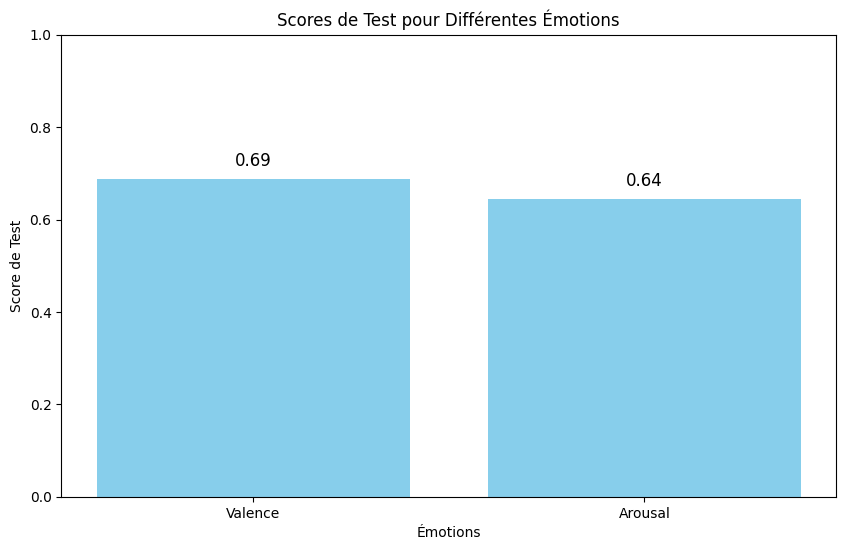

In [ ]:
import matplotlib.pyplot as plt
emotions = ['Valence', 'Arousal']
testscores1 = [0.6875, 0.64453125]
plt.figure(figsize=(10,6))
bars = plt.bar(emotions, testscores1, color='skyblue')
plt.xlabel('Émotions')
plt.ylabel('Score de Test')
plt.title('Scores de Test pour Différentes Émotions')
plt.ylim(0, 1)

for bar, score in zip(bars, testscores1):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

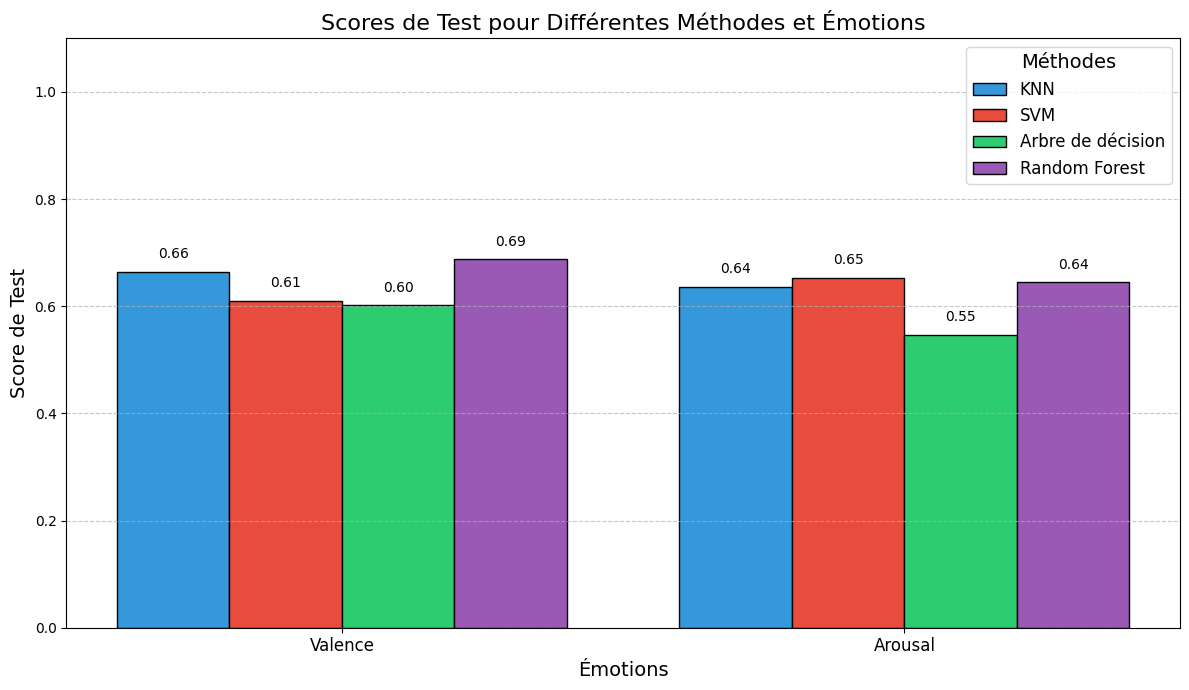

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Données
emotions = ['Valence', 'Arousal']
methods = ['KNN', 'SVM', 'Arbre de décision', 'Random Forest']
scores = {
    'KNN': [test_score_V_KNN, test_score_A_KNN],
    'SVM': [test_score_V_SVM, test_score_A_SVM],
    'Arbre de décision': [test_score_V_AD, test_score_A_AD],
    'Random Forest': [0.6875, 0.64453125]
}

# Paramètres du graphique
x = np.arange(len(emotions))
bar_width = 0.2
offsets = np.arange(len(methods)) * bar_width - (len(methods) - 1) * bar_width / 2
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']  # Couleurs des barres

plt.figure(figsize=(12, 7))

# Création des barres
for i, (method, method_scores) in enumerate(scores.items()):
    plt.bar(
        x + offsets[i],
        method_scores,
        bar_width,
        label=method,
        color=colors[i],
        edgecolor='black'  # Bordures noires pour chaque barre
    )

# Configuration des axes
plt.xticks(x, emotions, fontsize=12)
plt.xlabel('Émotions', fontsize=14)
plt.ylabel('Score de Test', fontsize=14)
plt.title('Scores de Test pour Différentes Méthodes et Émotions', fontsize=16)
plt.ylim(0, 1.1)  # Laisser de l'espace au-dessus des barres

# Ajout des annotations
for i, (method, method_scores) in enumerate(scores.items()):
    for j, score in enumerate(method_scores):
        plt.text(
            x[j] + offsets[i],
            score + 0.02,
            f'{score:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

# Ajout de la légende
plt.legend(title='Méthodes', fontsize=12, title_fontsize=14)

# Optimisation de l'affichage
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Grille horizontale pour faciliter la lecture
plt.tight_layout()

# Affichage
plt.show()
